In [2]:
# xarray to read NETCDF
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
# Opening all netCDF files
CanESM5 = xr.open_mfdataset('data/NMME/CanESM5/prec/*.nc')
CanESM5 = CanESM5.assign_coords(X=(((CanESM5.X + 180) % 360) - 180))

CCSM4 = xr.open_mfdataset('data/NMME/COLA-RSMAS-CCSM4/prec/*.nc')
CCSM4 = CCSM4.assign_coords(X=(((CCSM4.X + 180) % 360) - 180))

CESM1 = xr.open_mfdataset('data/NMME/COLA-RSMAS-CESM1/prec/*.nc')
CESM1 = CESM1.assign_coords(X=(((CESM1.X + 180) % 360) - 180))

GEM5 = xr.open_mfdataset('data/NMME/GEM5.2-NEMO/prec/*.nc')
GEM5 = GEM5.assign_coords(X=(((GEM5.X + 180) % 360) - 180))

GFDL = xr.open_mfdataset('data/NMME/GFDL-SPEAR/prec/*.nc')
GFDL = GFDL.assign_coords(X=(((GFDL.X + 180) % 360) - 180))

NASA = xr.open_mfdataset('data/NMME/NASA-GEOSS2S/prec/*.nc')
NASA = NASA.assign_coords(X=(((NASA.X + 180) % 360) - 180))

NCEP = xr.open_mfdataset('data/NMME/NCEP-CFSv2/prec/*.nc')
NCEP = NCEP.assign_coords(X=(((NCEP.X + 180) % 360) - 180))

chirps = xr.open_dataset('data/CHIRPS/chirps-v2.0.monthly.nc')

OSError: no files to open

In [9]:
# Subset the South Sudan Region CanESM5
CanESM5_south_sudan = (CanESM5.sel(Y=slice(3.5, 12.5), X=slice(25, 35))
                       .rename({'Y': 'latitude', 'X': 'longitude', 'prec': 'predicted precip', 'S': 'date of prediction', 'L': 'lead time'}))

# Interpolate and subset CHIRPS to match spatial resolution of NMME
chirps_south_sudan = (chirps.sel(latitude=slice(3.5,12.5), longitude=slice(24,36)) # One degree of resolution must be added for interpolation
                    .interp_like(CanESM5_south_sudan, method='nearest'))

# Calculate realized dates for CanESM5, convert to dataframe
CanESM5_south_sudan_df = CanESM5_south_sudan.to_dataframe().reset_index()
CanESM5_south_sudan_df['realization_time'] = CanESM5_south_sudan_df.apply(lambda x: x['date of prediction'] + pd.DateOffset(months=int(x['lead time'])), axis=1)

# Convert CHIRPS to dataframe
chirps_south_sudan_df = chirps_south_sudan.to_dataframe().reset_index()

# Merge CHIRPS and CanESM5 dataframe
south_sudan_merged_df = CanESM5_south_sudan_df.merge(chirps_south_sudan_df, how='left', left_on=['realization_time', 'latitude', 'longitude'], right_on=['time', 'latitude', 'longitude']).dropna()

# Save to .csv
south_sudan_merged_df.to_csv('data/csv/south_sudan_CanESM5_merged.csv')

# Drop date of prediction, latitude, longitude
south_sudan_merged_df = south_sudan_merged_df.drop(columns=['date of prediction', 'latitude', 'longitude'])
# make a new column month that extracts month from realization time
south_sudan_merged_df['month'] = south_sudan_merged_df['realization_time'].dt.month

# Make calculations on the merged dataframe for plotting
corr_clean = south_sudan_merged_df.drop(['realization_time', 'time'], axis = 1).groupby(['month', 'lead time', 'M']).corr(method='pearson').drop('precip', axis = 1).droplevel(level=3).reset_index()
corr_clean_1 = corr_clean.drop(corr_clean.index[::2])

# Make calculations on the merged dataframe for plotting
corr_clean = south_sudan_merged_df.drop(['realization_time', 'time'], axis = 1).groupby(['month', 'lead time', 'M']).corr(method='pearson').drop('precip', axis = 1).droplevel(level=3).reset_index()
corr_clean_1 = corr_clean.drop(corr_clean.index[::2])

stat_south_sudan = (south_sudan_merged_df.drop(['realization_time', 'time'], axis = 1)
        .groupby(['month', 'lead time', 'M']).agg(['mean', 'std']).reset_index())
stat_south_sudan.columns = stat_south_sudan.columns.droplevel()
stat_south_sudan.columns = ['month', 'lead time', 'M', 'pred mean', 'pred std', 'actual mean', 'actual std']
stat_south_sudan_clean = stat_south_sudan.merge(corr_clean_1.reset_index(), on = ['month', 'lead time', 'M'], how = 'left').drop("index", axis = 1)
stat_south_sudan_clean.columns = ['month', 'lead time', 'M', 'pred mean', 'pred std', 'actual mean', 'actual std', 'corr']
stat_south_sudan_clean['conditional bias'] = stat_south_sudan_clean.apply(lambda x: np.power(x['corr'] - x['pred std']/x['actual std'],2), axis = 1)
stat_south_sudan_clean['unconditional bias'] = stat_south_sudan_clean.apply(lambda x: np.power((x['pred mean'] - x['actual mean'])/x['actual std'],2), axis = 1)
stat_south_sudan_clean['potential skill'] = stat_south_sudan_clean.apply(lambda x: np.power(x['corr'],2), axis = 1)
stat_south_sudan_clean = stat_south_sudan_clean.drop(['corr','pred mean', 'pred std', 'actual mean', 'actual std'], axis = 1)
stat_south_sudan_clean['skill score'] = stat_south_sudan_clean.apply(lambda x: x['potential skill'] - x['conditional bias'] - x['unconditional bias'], axis = 1)
stat_south_sudan_clean = stat_south_sudan_clean.groupby(['month', 'lead time']).mean().drop('M', axis=1).reset_index()
stat_south_sudan_clean['region'] = 'South Sudan'

# Subset the Eastern East Africa Region CanESM5
CanESM5_eastern_east_africa = (CanESM5.sel(Y=slice(-3.5, 8), X=slice(38, 50))
                               .rename(
    {'Y': 'latitude', 'X': 'longitude', 'prec': 'predicted precip', 'S': 'date of prediction', 'L': 'lead time'}))

# Interpolate and subset CHIRPS to match spatial resolution of CanESM5
chirps_eastern_east_africa = (chirps.sel(latitude=slice(-3.5, 9), longitude=slice(37,
                                                                                  51))  # One degree of resolution must be added for interpolation
                              .interp_like(CanESM5_eastern_east_africa, method='nearest'))

# Calculate realized dates for CanESM5, convert to dataframe
CanESM5_eastern_east_africa_df = CanESM5_eastern_east_africa.to_dataframe().reset_index()
CanESM5_eastern_east_africa_df['realization_time'] = CanESM5_eastern_east_africa_df.apply(
    lambda x: x['date of prediction'] + pd.DateOffset(months=int(x['lead time'])), axis=1)

# Convert CHIRPS to dataframe
chirps_eastern_east_africa_df = chirps_eastern_east_africa.to_dataframe().reset_index()

# Merge CHIRPS and CanESM5 dataframe
eastern_east_africa_merged_df = CanESM5_eastern_east_africa_df.merge(chirps_eastern_east_africa_df, how='left',
                                                                     left_on=['realization_time', 'latitude',
                                                                              'longitude'],
                                                                     right_on=['time', 'latitude',
                                                                               'longitude']).dropna()

# Save to .csv
eastern_east_africa_merged_df.to_csv('data/csv/eastern_east_africa_CanESM5_merged.csv')

# Drop date of prediction, latitude, longitude
eastern_east_africa_merged_df = eastern_east_africa_merged_df.drop(
    columns=['date of prediction', 'latitude', 'longitude'])
# make a new column month that extracts month from realization time
eastern_east_africa_merged_df['month'] = eastern_east_africa_merged_df['realization_time'].dt.month

# Make calculations on the merged dataframe for plotting
corr_clean = eastern_east_africa_merged_df.drop(['realization_time', 'time'], axis=1).groupby(
    ['month', 'lead time', 'M']).corr(method='pearson').drop('precip', axis=1).droplevel(level=3).reset_index()
corr_clean_1 = corr_clean.drop(corr_clean.index[::2])

stat_eastern_east_africa = (eastern_east_africa_merged_df.drop(['realization_time', 'time'], axis=1)
                            .groupby(['month', 'lead time', 'M']).agg(['mean', 'std']).reset_index())
stat_eastern_east_africa.columns = stat_eastern_east_africa.columns.droplevel()
stat_eastern_east_africa.columns = ['month', 'lead time', 'M', 'pred mean', 'pred std', 'actual mean', 'actual std']
stat_eastern_east_africa_clean = stat_eastern_east_africa.merge(corr_clean_1.reset_index(),
                                                                on=['month', 'lead time', 'M'], how='left').drop(
    "index", axis=1)
stat_eastern_east_africa_clean.columns = ['month', 'lead time', 'M', 'pred mean', 'pred std', 'actual mean',
                                          'actual std', 'corr']
stat_eastern_east_africa_clean['conditional bias'] = stat_eastern_east_africa_clean.apply(
    lambda x: np.power(x['corr'] - x['pred std'] / x['actual std'], 2), axis=1)
stat_eastern_east_africa_clean['unconditional bias'] = stat_eastern_east_africa_clean.apply(
    lambda x: np.power((x['pred mean'] - x['actual mean']) / x['actual std'], 2), axis=1)
stat_eastern_east_africa_clean['potential skill'] = stat_eastern_east_africa_clean.apply(
    lambda x: np.power(x['corr'], 2), axis=1)
stat_eastern_east_africa_clean = stat_eastern_east_africa_clean.drop(
    ['corr', 'pred mean', 'pred std', 'actual mean', 'actual std'], axis=1)
stat_eastern_east_africa_clean['skill score'] = stat_eastern_east_africa_clean.apply(
    lambda x: x['potential skill'] - x['conditional bias'] - x['unconditional bias'], axis=1)
stat_eastern_east_africa_clean = stat_eastern_east_africa_clean.groupby(['month', 'lead time']).mean().drop('M',
                                                                                                            axis=1).reset_index()
stat_eastern_east_africa_clean['region'] = 'Eastern East Africa'

# Subset the Eastern Ukraine Region CanESM5
CanESM5_eastern_ukraine = (CanESM5.sel(Y=slice(45, 51), X=slice(31, 40))
                           .rename(
    {'Y': 'latitude', 'X': 'longitude', 'prec': 'predicted precip', 'S': 'date of prediction', 'L': 'lead time'}))

# Interpolate and subset CHIRPS to match spatial resolution of NMME
chirps_eastern_ukraine = (chirps.sel(latitude=slice(44, 52), longitude=slice(30,
                                                                             41))  # One degree of resolution must be added for interpolation
                          .interp_like(CanESM5_eastern_ukraine, method='nearest'))

# Calculate realized dates for CanESM5, convert to dataframe
CanESM5_eastern_ukraine_df = CanESM5_eastern_ukraine.to_dataframe().reset_index()
CanESM5_eastern_ukraine_df['realization_time'] = CanESM5_eastern_ukraine_df.apply(
    lambda x: x['date of prediction'] + pd.DateOffset(months=int(x['lead time'])), axis=1)

# Convert CHIRPS to dataframe
chirps_eastern_ukraine_df = chirps_eastern_ukraine.to_dataframe().reset_index()

# Merge CHIRPS and CanESM5 dataframe
eastern_ukraine_merged_df = CanESM5_eastern_ukraine_df.merge(chirps_eastern_ukraine_df, how='left',
                                                             left_on=['realization_time', 'latitude', 'longitude'],
                                                             right_on=['time', 'latitude', 'longitude']).dropna()

# Save to .csv
eastern_ukraine_merged_df.to_csv('data/csv/eastern_ukraine_CanESM5_merged.csv')

# Drop date of prediction, latitude, longitude
eastern_ukraine_merged_df = eastern_ukraine_merged_df.drop(columns=['date of prediction', 'latitude', 'longitude'])
# make a new column month that extracts month from realization time
eastern_ukraine_merged_df['month'] = eastern_ukraine_merged_df['realization_time'].dt.month

# Make calculations on the merged dataframe for plotting
corr_clean = eastern_ukraine_merged_df.drop(['realization_time', 'time'], axis=1).groupby(
    ['month', 'lead time', 'M']).corr(method='pearson').drop('precip', axis=1).droplevel(level=3).reset_index()
corr_clean_1 = corr_clean.drop(corr_clean.index[::2])

stat_eastern_ukraine = (eastern_ukraine_merged_df.drop(['realization_time', 'time'], axis=1)
                        .groupby(['month', 'lead time', 'M']).agg(['mean', 'std']).reset_index())
stat_eastern_ukraine.columns = stat_eastern_ukraine.columns.droplevel()
stat_eastern_ukraine.columns = ['month', 'lead time', 'M', 'pred mean', 'pred std', 'actual mean', 'actual std']
stat_eastern_ukraine_clean = stat_eastern_ukraine.merge(corr_clean_1.reset_index(), on=['month', 'lead time', 'M'],
                                                        how='left').drop("index", axis=1)
stat_eastern_ukraine_clean.columns = ['month', 'lead time', 'M', 'pred mean', 'pred std', 'actual mean', 'actual std',
                                      'corr']
stat_eastern_ukraine_clean['conditional bias'] = stat_eastern_ukraine_clean.apply(
    lambda x: np.power(x['corr'] - x['pred std'] / x['actual std'], 2), axis=1)
stat_eastern_ukraine_clean['unconditional bias'] = stat_eastern_ukraine_clean.apply(
    lambda x: np.power((x['pred mean'] - x['actual mean']) / x['actual std'], 2), axis=1)
stat_eastern_ukraine_clean['potential skill'] = stat_eastern_ukraine_clean.apply(lambda x: np.power(x['corr'], 2),
                                                                                 axis=1)
stat_eastern_ukraine_clean = stat_eastern_ukraine_clean.drop(
    ['corr', 'pred mean', 'pred std', 'actual mean', 'actual std'], axis=1)
stat_eastern_ukraine_clean['skill score'] = stat_eastern_ukraine_clean.apply(
    lambda x: x['potential skill'] - x['conditional bias'] - x['unconditional bias'], axis=1)
stat_eastern_ukraine_clean = stat_eastern_ukraine_clean.groupby(['month', 'lead time']).mean().drop('M',
                                                                                                    axis=1).reset_index()
stat_eastern_ukraine_clean['region'] = 'Eastern Ukraine'
# Subset the Southern Africa Region CanESM5
CanESM5_southern_africa = (CanESM5.sel(Y=slice(-23, -15), X=slice(25, 34))
                           .rename(
    {'Y': 'latitude', 'X': 'longitude', 'prec': 'predicted precip', 'S': 'date of prediction', 'L': 'lead time'}))

# Interpolate and subset CHIRPS to match spatial resolution of NMME
chirps_southern_africa = (chirps.sel(latitude=slice(-24, -14), longitude=slice(24,
                                                                               35))  # One degree of resolution must be added for interpolation
                          .interp_like(CanESM5_southern_africa, method='nearest'))

# Calculate realized dates for CanESM5, convert to dataframe
CanESM5_southern_africa_df = CanESM5_southern_africa.to_dataframe().reset_index()
CanESM5_southern_africa_df['realization_time'] = CanESM5_southern_africa_df.apply(
    lambda x: x['date of prediction'] + pd.DateOffset(months=int(x['lead time'])), axis=1)

# Convert CHIRPS to dataframe
chirps_southern_africa_df = chirps_southern_africa.to_dataframe().reset_index()

# Merge CHIRPS and CanESM5 dataframe
southern_africa_merged_df = CanESM5_southern_africa_df.merge(chirps_southern_africa_df, how='left',
                                                             left_on=['realization_time', 'latitude', 'longitude'],
                                                             right_on=['time', 'latitude', 'longitude']).dropna()

# Save to .csv
southern_africa_merged_df.to_csv('data/csv/southern_africa_CanESM5_merged.csv')

# Drop date of prediction, latitude, longitude
southern_africa_merged_df = southern_africa_merged_df.drop(columns=['date of prediction', 'latitude', 'longitude'])
# make a new column month that extracts month from realization time
southern_africa_merged_df['month'] = southern_africa_merged_df['realization_time'].dt.month

# Make calculations on the merged dataframe for plotting
corr_clean = southern_africa_merged_df.drop(['realization_time', 'time'], axis=1).groupby(
    ['month', 'lead time', 'M']).corr(method='pearson').drop('precip', axis=1).droplevel(level=3).reset_index()
corr_clean_1 = corr_clean.drop(corr_clean.index[::2])

stat_southern_africa = (southern_africa_merged_df.drop(['realization_time', 'time'], axis=1)
                        .groupby(['month', 'lead time', 'M']).agg(['mean', 'std']).reset_index())
stat_southern_africa.columns = stat_southern_africa.columns.droplevel()
stat_southern_africa.columns = ['month', 'lead time', 'M', 'pred mean', 'pred std', 'actual mean', 'actual std']
stat_southern_africa_clean = stat_southern_africa.merge(corr_clean_1.reset_index(), on=['month', 'lead time', 'M'],
                                                        how='left').drop("index", axis=1)
stat_southern_africa_clean.columns = ['month', 'lead time', 'M', 'pred mean', 'pred std', 'actual mean', 'actual std',
                                      'corr']
stat_southern_africa_clean['conditional bias'] = stat_southern_africa_clean.apply(
    lambda x: np.power(x['corr'] - x['pred std'] / x['actual std'], 2), axis=1)
stat_southern_africa_clean['unconditional bias'] = stat_southern_africa_clean.apply(
    lambda x: np.power((x['pred mean'] - x['actual mean']) / x['actual std'], 2), axis=1)
stat_southern_africa_clean['potential skill'] = stat_southern_africa_clean.apply(lambda x: np.power(x['corr'], 2),
                                                                                 axis=1)
stat_southern_africa_clean = stat_southern_africa_clean.drop(
    ['corr', 'pred mean', 'pred std', 'actual mean', 'actual std'], axis=1)
stat_southern_africa_clean['skill score'] = stat_southern_africa_clean.apply(
    lambda x: x['potential skill'] - x['conditional bias'] - x['unconditional bias'], axis=1)
stat_southern_africa_clean = stat_southern_africa_clean.groupby(['month', 'lead time']).mean().drop('M',
                                                                                                    axis=1).reset_index()
stat_southern_africa_clean['region'] = 'Southern Africa'
# Subset the West Africa Region CanESM5
CanESM5_west_africa = (CanESM5.sel(Y=slice(10, 13.5), X=slice(-10, 0))
                       .rename(
    {'Y': 'latitude', 'X': 'longitude', 'prec': 'predicted precip', 'S': 'date of prediction', 'L': 'lead time'}))

# Interpolate and subset CHIRPS to match spatial resolution of NMME
chirps_west_africa = (chirps.sel(latitude=slice(9, 13.5),
                                 longitude=slice(-11, 1))  # One degree of resolution must be added for interpolation
                      .interp_like(CanESM5_west_africa, method='nearest'))

# Calculate realized dates for CanESM5, convert to dataframe
CanESM5_west_africa_df = CanESM5_west_africa.to_dataframe().reset_index()
CanESM5_west_africa_df['realization_time'] = CanESM5_west_africa_df.apply(
    lambda x: x['date of prediction'] + pd.DateOffset(months=int(x['lead time'])), axis=1)

# Convert CHIRPS to dataframe
chirps_west_africa_df = chirps_west_africa.to_dataframe().reset_index()

# Merge CHIRPS and CanESM5 dataframe
west_africa_merged_df = CanESM5_west_africa_df.merge(chirps_west_africa_df, how='left',
                                                     left_on=['realization_time', 'latitude', 'longitude'],
                                                     right_on=['time', 'latitude', 'longitude']).dropna()

# Save to .csv
west_africa_merged_df.to_csv('data/csv/west_africa_CanESM5_merged.csv')

# Drop date of prediction, latitude, longitude
west_africa_merged_df = west_africa_merged_df.drop(columns=['date of prediction', 'latitude', 'longitude'])
# make a new column month that extracts month from realization time
west_africa_merged_df['month'] = west_africa_merged_df['realization_time'].dt.month

# Make calculations on the merged dataframe for plotting
corr_clean = west_africa_merged_df.drop(['realization_time', 'time'], axis=1).groupby(['month', 'lead time', 'M']).corr(
    method='pearson').drop('precip', axis=1).droplevel(level=3).reset_index()
corr_clean_1 = corr_clean.drop(corr_clean.index[::2])

stat_west_africa = (west_africa_merged_df.drop(['realization_time', 'time'], axis=1)
                    .groupby(['month', 'lead time', 'M']).agg(['mean', 'std']).reset_index())
stat_west_africa.columns = stat_west_africa.columns.droplevel()
stat_west_africa.columns = ['month', 'lead time', 'M', 'pred mean', 'pred std', 'actual mean', 'actual std']
stat_west_africa_clean = stat_west_africa.merge(corr_clean_1.reset_index(), on=['month', 'lead time', 'M'],
                                                how='left').drop("index", axis=1)
stat_west_africa_clean.columns = ['month', 'lead time', 'M', 'pred mean', 'pred std', 'actual mean', 'actual std',
                                  'corr']
stat_west_africa_clean['conditional bias'] = stat_west_africa_clean.apply(
    lambda x: np.power(x['corr'] - x['pred std'] / x['actual std'], 2), axis=1)
stat_west_africa_clean['unconditional bias'] = stat_west_africa_clean.apply(
    lambda x: np.power((x['pred mean'] - x['actual mean']) / x['actual std'], 2), axis=1)
stat_west_africa_clean['potential skill'] = stat_west_africa_clean.apply(lambda x: np.power(x['corr'], 2), axis=1)
stat_west_africa_clean = stat_west_africa_clean.drop(['corr', 'pred mean', 'pred std', 'actual mean', 'actual std'],
                                                     axis=1)
stat_west_africa_clean['skill score'] = stat_west_africa_clean.apply(
    lambda x: x['potential skill'] - x['conditional bias'] - x['unconditional bias'], axis=1)
stat_west_africa_clean = stat_west_africa_clean.groupby(['month', 'lead time']).mean().drop('M', axis=1).reset_index()
stat_west_africa_clean['region'] = 'West Africa'
# Subset the Sri Lanka Region CanESM5
CanESM5_sri_lanka = (CanESM5.sel(Y=slice(5.5, 10), X=slice(79.5, 82))
                     .rename(
    {'Y': 'latitude', 'X': 'longitude', 'prec': 'predicted precip', 'S': 'date of prediction', 'L': 'lead time'}))

# Interpolate and subset CHIRPS to match spatial resolution of NMME
chirps_sri_lanka = (chirps.sel(latitude=slice(5.5, 11),
                               longitude=slice(79.5, 83))  # One degree of resolution must be added for interpolation
                    .interp_like(CanESM5_sri_lanka, method='nearest'))

# Calculate realized dates for CanESM5, convert to dataframe
CanESM5_sri_lanka_df = CanESM5_sri_lanka.to_dataframe().reset_index()
CanESM5_sri_lanka_df['realization_time'] = CanESM5_sri_lanka_df.apply(
    lambda x: x['date of prediction'] + pd.DateOffset(months=int(x['lead time'])), axis=1)

# Convert CHIRPS to dataframe
chirps_sri_lanka_df = chirps_sri_lanka.to_dataframe().reset_index()

# Merge CHIRPS and CanESM5 dataframe
sri_lanka_merged_df = CanESM5_sri_lanka_df.merge(chirps_sri_lanka_df, how='left',
                                                 left_on=['realization_time', 'latitude', 'longitude'],
                                                 right_on=['time', 'latitude', 'longitude']).dropna()

# Save to .csv
sri_lanka_merged_df.to_csv('data/csv/sri_lanka_CanESM5_merged.csv')

# Drop date of prediction, latitude, longitude
sri_lanka_merged_df = sri_lanka_merged_df.drop(columns=['date of prediction', 'latitude', 'longitude'])
# make a new column month that extracts month from realization time
sri_lanka_merged_df['month'] = sri_lanka_merged_df['realization_time'].dt.month

# Make calculations on the merged dataframe for plotting
corr_clean = sri_lanka_merged_df.drop(['realization_time', 'time'], axis=1).groupby(['month', 'lead time', 'M']).corr(
    method='pearson').drop('precip', axis=1).droplevel(level=3).reset_index()
corr_clean_1 = corr_clean.drop(corr_clean.index[::2])

stat_sri_lanka = (sri_lanka_merged_df.drop(['realization_time', 'time'], axis=1)
                  .groupby(['month', 'lead time', 'M']).agg(['mean', 'std']).reset_index())
stat_sri_lanka.columns = stat_sri_lanka.columns.droplevel()
stat_sri_lanka.columns = ['month', 'lead time', 'M', 'pred mean', 'pred std', 'actual mean', 'actual std']
stat_sri_lanka_clean = stat_sri_lanka.merge(corr_clean_1.reset_index(), on=['month', 'lead time', 'M'],
                                            how='left').drop("index", axis=1)
stat_sri_lanka_clean.columns = ['month', 'lead time', 'M', 'pred mean', 'pred std', 'actual mean', 'actual std', 'corr']
stat_sri_lanka_clean['conditional bias'] = stat_sri_lanka_clean.apply(
    lambda x: np.power(x['corr'] - x['pred std'] / x['actual std'], 2), axis=1)
stat_sri_lanka_clean['unconditional bias'] = stat_sri_lanka_clean.apply(
    lambda x: np.power((x['pred mean'] - x['actual mean']) / x['actual std'], 2), axis=1)
stat_sri_lanka_clean['potential skill'] = stat_sri_lanka_clean.apply(lambda x: np.power(x['corr'], 2), axis=1)
stat_sri_lanka_clean = stat_sri_lanka_clean.drop(['corr', 'pred mean', 'pred std', 'actual mean', 'actual std'], axis=1)
stat_sri_lanka_clean['skill score'] = stat_sri_lanka_clean.apply(
    lambda x: x['potential skill'] - x['conditional bias'] - x['unconditional bias'], axis=1)
stat_sri_lanka_clean = stat_sri_lanka_clean.groupby(['month', 'lead time']).mean().drop('M', axis=1).reset_index()
stat_sri_lanka_clean['region'] = 'Sri Lanka'

df_list = [stat_south_sudan_clean, stat_sri_lanka_clean, stat_eastern_east_africa_clean, stat_eastern_ukraine_clean, stat_west_africa_clean, stat_southern_africa_clean]
CanESM5_stat_final = pd.concat(df_list)
CanESM5_stat_final['model'] = 'CanESM5'

In [10]:
# Subset the South Sudan Region COLA-RSMAS-CESM1
CESM1_south_sudan = (CESM1.sel(Y=slice(3.5, 12.5), X=slice(25, 35))
                       .rename({'Y': 'latitude', 'X': 'longitude', 'prec': 'predicted precip', 'S': 'date of prediction', 'L': 'lead time'}))

# Interpolate and subset CHIRPS to match spatial resolution of NMME
chirps_south_sudan = (chirps.sel(latitude=slice(3.5,12.5), longitude=slice(24,36)) # One degree of resolution must be added for interpolation
                    .interp_like(CESM1_south_sudan, method='nearest'))

# Calculate realized dates for COLA-RSMAS-CESM1, convert to dataframe
CESM1_south_sudan_df = CESM1_south_sudan.to_dataframe().reset_index()
CESM1_south_sudan_df['realization_time'] = CESM1_south_sudan_df.apply(lambda x: x['date of prediction'] + pd.DateOffset(months=int(x['lead time'])), axis=1)

# Convert CHIRPS to dataframe
chirps_south_sudan_df = chirps_south_sudan.to_dataframe().reset_index()

# Merge CHIRPS and COLA-RSMAS-CESM1 dataframe
south_sudan_merged_df = CESM1_south_sudan_df.merge(chirps_south_sudan_df, how='left', left_on=['realization_time', 'latitude', 'longitude'], right_on=['time', 'latitude', 'longitude']).dropna()

# Save to .csv
south_sudan_merged_df.to_csv('data/csv/south_sudan_CESM1_merged.csv')

# Drop date of prediction, latitude, longitude
south_sudan_merged_df = south_sudan_merged_df.drop(columns=['date of prediction', 'latitude', 'longitude'])
# make a new column month that extracts month from realization time
south_sudan_merged_df['month'] = south_sudan_merged_df['realization_time'].dt.month

# Make calculations on the merged dataframe for plotting
corr_clean = south_sudan_merged_df.drop(['realization_time', 'time'], axis = 1).groupby(['month', 'lead time', 'M']).corr(method='pearson').drop('precip', axis = 1).droplevel(level=3).reset_index()
corr_clean_1 = corr_clean.drop(corr_clean.index[::2])

# Make calculations on the merged dataframe for plotting
corr_clean = south_sudan_merged_df.drop(['realization_time', 'time'], axis = 1).groupby(['month', 'lead time', 'M']).corr(method='pearson').drop('precip', axis = 1).droplevel(level=3).reset_index()
corr_clean_1 = corr_clean.drop(corr_clean.index[::2])

stat_south_sudan = (south_sudan_merged_df.drop(['realization_time', 'time'], axis = 1)
        .groupby(['month', 'lead time', 'M']).agg(['mean', 'std']).reset_index())
stat_south_sudan.columns = stat_south_sudan.columns.droplevel()
stat_south_sudan.columns = ['month', 'lead time', 'M', 'pred mean', 'pred std', 'actual mean', 'actual std']
stat_south_sudan_clean = stat_south_sudan.merge(corr_clean_1.reset_index(), on = ['month', 'lead time', 'M'], how = 'left').drop("index", axis = 1)
stat_south_sudan_clean.columns = ['month', 'lead time', 'M', 'pred mean', 'pred std', 'actual mean', 'actual std', 'corr']
stat_south_sudan_clean['conditional bias'] = stat_south_sudan_clean.apply(lambda x: np.power(x['corr'] - x['pred std']/x['actual std'],2), axis = 1)
stat_south_sudan_clean['unconditional bias'] = stat_south_sudan_clean.apply(lambda x: np.power((x['pred mean'] - x['actual mean'])/x['actual std'],2), axis = 1)
stat_south_sudan_clean['potential skill'] = stat_south_sudan_clean.apply(lambda x: np.power(x['corr'],2), axis = 1)
stat_south_sudan_clean = stat_south_sudan_clean.drop(['corr','pred mean', 'pred std', 'actual mean', 'actual std'], axis = 1)
stat_south_sudan_clean['skill score'] = stat_south_sudan_clean.apply(lambda x: x['potential skill'] - x['conditional bias'] - x['unconditional bias'], axis = 1)
stat_south_sudan_clean = stat_south_sudan_clean.groupby(['month', 'lead time']).mean().drop('M', axis=1).reset_index()
stat_south_sudan_clean['region'] = 'South Sudan'

# Subset the Eastern East Africa Region COLA-RSMAS-CESM1
CESM1_eastern_east_africa = (CESM1.sel(Y=slice(-3.5, 8), X=slice(38, 50))
                               .rename(
    {'Y': 'latitude', 'X': 'longitude', 'prec': 'predicted precip', 'S': 'date of prediction', 'L': 'lead time'}))

# Interpolate and subset CHIRPS to match spatial resolution of COLA-RSMAS-CESM1
chirps_eastern_east_africa = (chirps.sel(latitude=slice(-3.5, 9), longitude=slice(37,
                                                                                  51))  # One degree of resolution must be added for interpolation
                              .interp_like(CESM1_eastern_east_africa, method='nearest'))

# Calculate realized dates for COLA-RSMAS-CESM1, convert to dataframe
CESM1_eastern_east_africa_df = CESM1_eastern_east_africa.to_dataframe().reset_index()
CESM1_eastern_east_africa_df['realization_time'] = CESM1_eastern_east_africa_df.apply(
    lambda x: x['date of prediction'] + pd.DateOffset(months=int(x['lead time'])), axis=1)

# Convert CHIRPS to dataframe
chirps_eastern_east_africa_df = chirps_eastern_east_africa.to_dataframe().reset_index()

# Merge CHIRPS and COLA-RSMAS-CESM1 dataframe
eastern_east_africa_merged_df = CESM1_eastern_east_africa_df.merge(chirps_eastern_east_africa_df, how='left',
                                                                     left_on=['realization_time', 'latitude',
                                                                              'longitude'],
                                                                     right_on=['time', 'latitude',
                                                                               'longitude']).dropna()

# Save to .csv
eastern_east_africa_merged_df.to_csv('data/csv/eastern_east_africa_CESM1_merged.csv')

# Drop date of prediction, latitude, longitude
eastern_east_africa_merged_df = eastern_east_africa_merged_df.drop(
    columns=['date of prediction', 'latitude', 'longitude'])
# make a new column month that extracts month from realization time
eastern_east_africa_merged_df['month'] = eastern_east_africa_merged_df['realization_time'].dt.month

# Make calculations on the merged dataframe for plotting
corr_clean = eastern_east_africa_merged_df.drop(['realization_time', 'time'], axis=1).groupby(
    ['month', 'lead time', 'M']).corr(method='pearson').drop('precip', axis=1).droplevel(level=3).reset_index()
corr_clean_1 = corr_clean.drop(corr_clean.index[::2])

stat_eastern_east_africa = (eastern_east_africa_merged_df.drop(['realization_time', 'time'], axis=1)
                            .groupby(['month', 'lead time', 'M']).agg(['mean', 'std']).reset_index())
stat_eastern_east_africa.columns = stat_eastern_east_africa.columns.droplevel()
stat_eastern_east_africa.columns = ['month', 'lead time', 'M', 'pred mean', 'pred std', 'actual mean', 'actual std']
stat_eastern_east_africa_clean = stat_eastern_east_africa.merge(corr_clean_1.reset_index(),
                                                                on=['month', 'lead time', 'M'], how='left').drop(
    "index", axis=1)
stat_eastern_east_africa_clean.columns = ['month', 'lead time', 'M', 'pred mean', 'pred std', 'actual mean',
                                          'actual std', 'corr']
stat_eastern_east_africa_clean['conditional bias'] = stat_eastern_east_africa_clean.apply(
    lambda x: np.power(x['corr'] - x['pred std'] / x['actual std'], 2), axis=1)
stat_eastern_east_africa_clean['unconditional bias'] = stat_eastern_east_africa_clean.apply(
    lambda x: np.power((x['pred mean'] - x['actual mean']) / x['actual std'], 2), axis=1)
stat_eastern_east_africa_clean['potential skill'] = stat_eastern_east_africa_clean.apply(
    lambda x: np.power(x['corr'], 2), axis=1)
stat_eastern_east_africa_clean = stat_eastern_east_africa_clean.drop(
    ['corr', 'pred mean', 'pred std', 'actual mean', 'actual std'], axis=1)
stat_eastern_east_africa_clean['skill score'] = stat_eastern_east_africa_clean.apply(
    lambda x: x['potential skill'] - x['conditional bias'] - x['unconditional bias'], axis=1)
stat_eastern_east_africa_clean = stat_eastern_east_africa_clean.groupby(['month', 'lead time']).mean().drop('M',
                                                                                                            axis=1).reset_index()
stat_eastern_east_africa_clean['region'] = 'Eastern East Africa'

# Subset the Eastern Ukraine Region COLA-RSMAS-CESM1
CESM1_eastern_ukraine = (CESM1.sel(Y=slice(45, 51), X=slice(31, 40))
                           .rename(
    {'Y': 'latitude', 'X': 'longitude', 'prec': 'predicted precip', 'S': 'date of prediction', 'L': 'lead time'}))

# Interpolate and subset CHIRPS to match spatial resolution of NMME
chirps_eastern_ukraine = (chirps.sel(latitude=slice(44, 52), longitude=slice(30,
                                                                             41))  # One degree of resolution must be added for interpolation
                          .interp_like(CESM1_eastern_ukraine, method='nearest'))

# Calculate realized dates for COLA-RSMAS-CESM1, convert to dataframe
CESM1_eastern_ukraine_df = CESM1_eastern_ukraine.to_dataframe().reset_index()
CESM1_eastern_ukraine_df['realization_time'] = CESM1_eastern_ukraine_df.apply(
    lambda x: x['date of prediction'] + pd.DateOffset(months=int(x['lead time'])), axis=1)

# Convert CHIRPS to dataframe
chirps_eastern_ukraine_df = chirps_eastern_ukraine.to_dataframe().reset_index()

# Merge CHIRPS and COLA-RSMAS-CESM1 dataframe
eastern_ukraine_merged_df = CESM1_eastern_ukraine_df.merge(chirps_eastern_ukraine_df, how='left',
                                                             left_on=['realization_time', 'latitude', 'longitude'],
                                                             right_on=['time', 'latitude', 'longitude']).dropna()

# Save to .csv
eastern_ukraine_merged_df.to_csv('data/csv/eastern_ukraine_CESM1_merged.csv')

# Drop date of prediction, latitude, longitude
eastern_ukraine_merged_df = eastern_ukraine_merged_df.drop(columns=['date of prediction', 'latitude', 'longitude'])
# make a new column month that extracts month from realization time
eastern_ukraine_merged_df['month'] = eastern_ukraine_merged_df['realization_time'].dt.month

# Make calculations on the merged dataframe for plotting
corr_clean = eastern_ukraine_merged_df.drop(['realization_time', 'time'], axis=1).groupby(
    ['month', 'lead time', 'M']).corr(method='pearson').drop('precip', axis=1).droplevel(level=3).reset_index()
corr_clean_1 = corr_clean.drop(corr_clean.index[::2])

stat_eastern_ukraine = (eastern_ukraine_merged_df.drop(['realization_time', 'time'], axis=1)
                        .groupby(['month', 'lead time', 'M']).agg(['mean', 'std']).reset_index())
stat_eastern_ukraine.columns = stat_eastern_ukraine.columns.droplevel()
stat_eastern_ukraine.columns = ['month', 'lead time', 'M', 'pred mean', 'pred std', 'actual mean', 'actual std']
stat_eastern_ukraine_clean = stat_eastern_ukraine.merge(corr_clean_1.reset_index(), on=['month', 'lead time', 'M'],
                                                        how='left').drop("index", axis=1)
stat_eastern_ukraine_clean.columns = ['month', 'lead time', 'M', 'pred mean', 'pred std', 'actual mean', 'actual std',
                                      'corr']
stat_eastern_ukraine_clean['conditional bias'] = stat_eastern_ukraine_clean.apply(
    lambda x: np.power(x['corr'] - x['pred std'] / x['actual std'], 2), axis=1)
stat_eastern_ukraine_clean['unconditional bias'] = stat_eastern_ukraine_clean.apply(
    lambda x: np.power((x['pred mean'] - x['actual mean']) / x['actual std'], 2), axis=1)
stat_eastern_ukraine_clean['potential skill'] = stat_eastern_ukraine_clean.apply(lambda x: np.power(x['corr'], 2),
                                                                                 axis=1)
stat_eastern_ukraine_clean = stat_eastern_ukraine_clean.drop(
    ['corr', 'pred mean', 'pred std', 'actual mean', 'actual std'], axis=1)
stat_eastern_ukraine_clean['skill score'] = stat_eastern_ukraine_clean.apply(
    lambda x: x['potential skill'] - x['conditional bias'] - x['unconditional bias'], axis=1)
stat_eastern_ukraine_clean = stat_eastern_ukraine_clean.groupby(['month', 'lead time']).mean().drop('M',
                                                                                                    axis=1).reset_index()
stat_eastern_ukraine_clean['region'] = 'Eastern Ukraine'
# Subset the Southern Africa Region COLA-RSMAS-CESM1
CESM1_southern_africa = (CESM1.sel(Y=slice(-23, -15), X=slice(25, 34))
                           .rename(
    {'Y': 'latitude', 'X': 'longitude', 'prec': 'predicted precip', 'S': 'date of prediction', 'L': 'lead time'}))

# Interpolate and subset CHIRPS to match spatial resolution of NMME
chirps_southern_africa = (chirps.sel(latitude=slice(-24, -14), longitude=slice(24,
                                                                               35))  # One degree of resolution must be added for interpolation
                          .interp_like(CESM1_southern_africa, method='nearest'))

# Calculate realized dates for COLA-RSMAS-CESM1, convert to dataframe
CESM1_southern_africa_df = CESM1_southern_africa.to_dataframe().reset_index()
CESM1_southern_africa_df['realization_time'] = CESM1_southern_africa_df.apply(
    lambda x: x['date of prediction'] + pd.DateOffset(months=int(x['lead time'])), axis=1)

# Convert CHIRPS to dataframe
chirps_southern_africa_df = chirps_southern_africa.to_dataframe().reset_index()

# Merge CHIRPS and COLA-RSMAS-CESM1 dataframe
southern_africa_merged_df = CESM1_southern_africa_df.merge(chirps_southern_africa_df, how='left',
                                                             left_on=['realization_time', 'latitude', 'longitude'],
                                                             right_on=['time', 'latitude', 'longitude']).dropna()

# Save to .csv
southern_africa_merged_df.to_csv('data/csv/southern_africa_CESM1_merged.csv')

# Drop date of prediction, latitude, longitude
southern_africa_merged_df = southern_africa_merged_df.drop(columns=['date of prediction', 'latitude', 'longitude'])
# make a new column month that extracts month from realization time
southern_africa_merged_df['month'] = southern_africa_merged_df['realization_time'].dt.month

# Make calculations on the merged dataframe for plotting
corr_clean = southern_africa_merged_df.drop(['realization_time', 'time'], axis=1).groupby(
    ['month', 'lead time', 'M']).corr(method='pearson').drop('precip', axis=1).droplevel(level=3).reset_index()
corr_clean_1 = corr_clean.drop(corr_clean.index[::2])

stat_southern_africa = (southern_africa_merged_df.drop(['realization_time', 'time'], axis=1)
                        .groupby(['month', 'lead time', 'M']).agg(['mean', 'std']).reset_index())
stat_southern_africa.columns = stat_southern_africa.columns.droplevel()
stat_southern_africa.columns = ['month', 'lead time', 'M', 'pred mean', 'pred std', 'actual mean', 'actual std']
stat_southern_africa_clean = stat_southern_africa.merge(corr_clean_1.reset_index(), on=['month', 'lead time', 'M'],
                                                        how='left').drop("index", axis=1)
stat_southern_africa_clean.columns = ['month', 'lead time', 'M', 'pred mean', 'pred std', 'actual mean', 'actual std',
                                      'corr']
stat_southern_africa_clean['conditional bias'] = stat_southern_africa_clean.apply(
    lambda x: np.power(x['corr'] - x['pred std'] / x['actual std'], 2), axis=1)
stat_southern_africa_clean['unconditional bias'] = stat_southern_africa_clean.apply(
    lambda x: np.power((x['pred mean'] - x['actual mean']) / x['actual std'], 2), axis=1)
stat_southern_africa_clean['potential skill'] = stat_southern_africa_clean.apply(lambda x: np.power(x['corr'], 2),
                                                                                 axis=1)
stat_southern_africa_clean = stat_southern_africa_clean.drop(
    ['corr', 'pred mean', 'pred std', 'actual mean', 'actual std'], axis=1)
stat_southern_africa_clean['skill score'] = stat_southern_africa_clean.apply(
    lambda x: x['potential skill'] - x['conditional bias'] - x['unconditional bias'], axis=1)
stat_southern_africa_clean = stat_southern_africa_clean.groupby(['month', 'lead time']).mean().drop('M',
                                                                                                    axis=1).reset_index()
stat_southern_africa_clean['region'] = 'Southern Africa'
# Subset the West Africa Region COLA-RSMAS-CESM1
CESM1_west_africa = (CESM1.sel(Y=slice(10, 13.5), X=slice(-10, 0))
                       .rename(
    {'Y': 'latitude', 'X': 'longitude', 'prec': 'predicted precip', 'S': 'date of prediction', 'L': 'lead time'}))

# Interpolate and subset CHIRPS to match spatial resolution of NMME
chirps_west_africa = (chirps.sel(latitude=slice(9, 13.5),
                                 longitude=slice(-11, 1))  # One degree of resolution must be added for interpolation
                      .interp_like(CESM1_west_africa, method='nearest'))

# Calculate realized dates for COLA-RSMAS-CESM1, convert to dataframe
CESM1_west_africa_df = CESM1_west_africa.to_dataframe().reset_index()
CESM1_west_africa_df['realization_time'] = CESM1_west_africa_df.apply(
    lambda x: x['date of prediction'] + pd.DateOffset(months=int(x['lead time'])), axis=1)

# Convert CHIRPS to dataframe
chirps_west_africa_df = chirps_west_africa.to_dataframe().reset_index()

# Merge CHIRPS and COLA-RSMAS-CESM1 dataframe
west_africa_merged_df = CESM1_west_africa_df.merge(chirps_west_africa_df, how='left',
                                                     left_on=['realization_time', 'latitude', 'longitude'],
                                                     right_on=['time', 'latitude', 'longitude']).dropna()

# Save to .csv
west_africa_merged_df.to_csv('data/csv/west_africa_CESM1_merged.csv')

# Drop date of prediction, latitude, longitude
west_africa_merged_df = west_africa_merged_df.drop(columns=['date of prediction', 'latitude', 'longitude'])
# make a new column month that extracts month from realization time
west_africa_merged_df['month'] = west_africa_merged_df['realization_time'].dt.month

# Make calculations on the merged dataframe for plotting
corr_clean = west_africa_merged_df.drop(['realization_time', 'time'], axis=1).groupby(['month', 'lead time', 'M']).corr(
    method='pearson').drop('precip', axis=1).droplevel(level=3).reset_index()
corr_clean_1 = corr_clean.drop(corr_clean.index[::2])

stat_west_africa = (west_africa_merged_df.drop(['realization_time', 'time'], axis=1)
                    .groupby(['month', 'lead time', 'M']).agg(['mean', 'std']).reset_index())
stat_west_africa.columns = stat_west_africa.columns.droplevel()
stat_west_africa.columns = ['month', 'lead time', 'M', 'pred mean', 'pred std', 'actual mean', 'actual std']
stat_west_africa_clean = stat_west_africa.merge(corr_clean_1.reset_index(), on=['month', 'lead time', 'M'],
                                                how='left').drop("index", axis=1)
stat_west_africa_clean.columns = ['month', 'lead time', 'M', 'pred mean', 'pred std', 'actual mean', 'actual std',
                                  'corr']
stat_west_africa_clean['conditional bias'] = stat_west_africa_clean.apply(
    lambda x: np.power(x['corr'] - x['pred std'] / x['actual std'], 2), axis=1)
stat_west_africa_clean['unconditional bias'] = stat_west_africa_clean.apply(
    lambda x: np.power((x['pred mean'] - x['actual mean']) / x['actual std'], 2), axis=1)
stat_west_africa_clean['potential skill'] = stat_west_africa_clean.apply(lambda x: np.power(x['corr'], 2), axis=1)
stat_west_africa_clean = stat_west_africa_clean.drop(['corr', 'pred mean', 'pred std', 'actual mean', 'actual std'],
                                                     axis=1)
stat_west_africa_clean['skill score'] = stat_west_africa_clean.apply(
    lambda x: x['potential skill'] - x['conditional bias'] - x['unconditional bias'], axis=1)
stat_west_africa_clean = stat_west_africa_clean.groupby(['month', 'lead time']).mean().drop('M', axis=1).reset_index()
stat_west_africa_clean['region'] = 'West Africa'
# Subset the Sri Lanka Region COLA-RSMAS-CESM1
CESM1_sri_lanka = (CESM1.sel(Y=slice(5.5, 10), X=slice(79.5, 82))
                     .rename(
    {'Y': 'latitude', 'X': 'longitude', 'prec': 'predicted precip', 'S': 'date of prediction', 'L': 'lead time'}))

# Interpolate and subset CHIRPS to match spatial resolution of NMME
chirps_sri_lanka = (chirps.sel(latitude=slice(5.5, 11),
                               longitude=slice(79.5, 83))  # One degree of resolution must be added for interpolation
                    .interp_like(CESM1_sri_lanka, method='nearest'))

# Calculate realized dates for COLA-RSMAS-CESM1, convert to dataframe
CESM1_sri_lanka_df = CESM1_sri_lanka.to_dataframe().reset_index()
CESM1_sri_lanka_df['realization_time'] = CESM1_sri_lanka_df.apply(
    lambda x: x['date of prediction'] + pd.DateOffset(months=int(x['lead time'])), axis=1)

# Convert CHIRPS to dataframe
chirps_sri_lanka_df = chirps_sri_lanka.to_dataframe().reset_index()

# Merge CHIRPS and COLA-RSMAS-CESM1 dataframe
sri_lanka_merged_df = CESM1_sri_lanka_df.merge(chirps_sri_lanka_df, how='left',
                                                 left_on=['realization_time', 'latitude', 'longitude'],
                                                 right_on=['time', 'latitude', 'longitude']).dropna()

# Save to .csv
sri_lanka_merged_df.to_csv('data/csv/sri_lanka_CESM1_merged.csv')

# Drop date of prediction, latitude, longitude
sri_lanka_merged_df = sri_lanka_merged_df.drop(columns=['date of prediction', 'latitude', 'longitude'])
# make a new column month that extracts month from realization time
sri_lanka_merged_df['month'] = sri_lanka_merged_df['realization_time'].dt.month

# Make calculations on the merged dataframe for plotting
corr_clean = sri_lanka_merged_df.drop(['realization_time', 'time'], axis=1).groupby(['month', 'lead time', 'M']).corr(
    method='pearson').drop('precip', axis=1).droplevel(level=3).reset_index()
corr_clean_1 = corr_clean.drop(corr_clean.index[::2])

stat_sri_lanka = (sri_lanka_merged_df.drop(['realization_time', 'time'], axis=1)
                  .groupby(['month', 'lead time', 'M']).agg(['mean', 'std']).reset_index())
stat_sri_lanka.columns = stat_sri_lanka.columns.droplevel()
stat_sri_lanka.columns = ['month', 'lead time', 'M', 'pred mean', 'pred std', 'actual mean', 'actual std']
stat_sri_lanka_clean = stat_sri_lanka.merge(corr_clean_1.reset_index(), on=['month', 'lead time', 'M'],
                                            how='left').drop("index", axis=1)
stat_sri_lanka_clean.columns = ['month', 'lead time', 'M', 'pred mean', 'pred std', 'actual mean', 'actual std', 'corr']
stat_sri_lanka_clean['conditional bias'] = stat_sri_lanka_clean.apply(
    lambda x: np.power(x['corr'] - x['pred std'] / x['actual std'], 2), axis=1)
stat_sri_lanka_clean['unconditional bias'] = stat_sri_lanka_clean.apply(
    lambda x: np.power((x['pred mean'] - x['actual mean']) / x['actual std'], 2), axis=1)
stat_sri_lanka_clean['potential skill'] = stat_sri_lanka_clean.apply(lambda x: np.power(x['corr'], 2), axis=1)
stat_sri_lanka_clean = stat_sri_lanka_clean.drop(['corr', 'pred mean', 'pred std', 'actual mean', 'actual std'], axis=1)
stat_sri_lanka_clean['skill score'] = stat_sri_lanka_clean.apply(
    lambda x: x['potential skill'] - x['conditional bias'] - x['unconditional bias'], axis=1)
stat_sri_lanka_clean = stat_sri_lanka_clean.groupby(['month', 'lead time']).mean().drop('M', axis=1).reset_index()
stat_sri_lanka_clean['region'] = 'Sri Lanka'

df_list = [stat_south_sudan_clean, stat_sri_lanka_clean, stat_eastern_east_africa_clean, stat_eastern_ukraine_clean, stat_west_africa_clean, stat_southern_africa_clean]
CESM1_stat_final = pd.concat(df_list)
CESM1_stat_final['model'] = 'CESM1'

In [11]:
# Subset the South Sudan Region COLA-RSMAS-CCSM4
CCSM4_south_sudan = (CCSM4.sel(Y=slice(3.5, 12.5), X=slice(25, 35))
                       .rename({'Y': 'latitude', 'X': 'longitude', 'prec': 'predicted precip', 'S': 'date of prediction', 'L': 'lead time'}))

# Interpolate and subset CHIRPS to match spatial resolution of NMME
chirps_south_sudan = (chirps.sel(latitude=slice(3.5,12.5), longitude=slice(24,36)) # One degree of resolution must be added for interpolation
                    .interp_like(CCSM4_south_sudan, method='nearest'))

# Calculate realized dates for COLA-RSMAS-CCSM4, convert to dataframe
CCSM4_south_sudan_df = CCSM4_south_sudan.to_dataframe().reset_index()
CCSM4_south_sudan_df['realization_time'] = CCSM4_south_sudan_df.apply(lambda x: x['date of prediction'] + pd.DateOffset(months=int(x['lead time'])), axis=1)

# Convert CHIRPS to dataframe
chirps_south_sudan_df = chirps_south_sudan.to_dataframe().reset_index()

# Merge CHIRPS and COLA-RSMAS-CCSM4 dataframe
south_sudan_merged_df = CCSM4_south_sudan_df.merge(chirps_south_sudan_df, how='left', left_on=['realization_time', 'latitude', 'longitude'], right_on=['time', 'latitude', 'longitude']).dropna()

# Save to .csv
south_sudan_merged_df.to_csv('data/csv/south_sudan_CCSM4_merged.csv')

# Drop date of prediction, latitude, longitude
south_sudan_merged_df = south_sudan_merged_df.drop(columns=['date of prediction', 'latitude', 'longitude'])
# make a new column month that extracts month from realization time
south_sudan_merged_df['month'] = south_sudan_merged_df['realization_time'].dt.month

# Make calculations on the merged dataframe for plotting
corr_clean = south_sudan_merged_df.drop(['realization_time', 'time'], axis = 1).groupby(['month', 'lead time', 'M']).corr(method='pearson').drop('precip', axis = 1).droplevel(level=3).reset_index()
corr_clean_1 = corr_clean.drop(corr_clean.index[::2])

# Make calculations on the merged dataframe for plotting
corr_clean = south_sudan_merged_df.drop(['realization_time', 'time'], axis = 1).groupby(['month', 'lead time', 'M']).corr(method='pearson').drop('precip', axis = 1).droplevel(level=3).reset_index()
corr_clean_1 = corr_clean.drop(corr_clean.index[::2])

stat_south_sudan = (south_sudan_merged_df.drop(['realization_time', 'time'], axis = 1)
        .groupby(['month', 'lead time', 'M']).agg(['mean', 'std']).reset_index())
stat_south_sudan.columns = stat_south_sudan.columns.droplevel()
stat_south_sudan.columns = ['month', 'lead time', 'M', 'pred mean', 'pred std', 'actual mean', 'actual std']
stat_south_sudan_clean = stat_south_sudan.merge(corr_clean_1.reset_index(), on = ['month', 'lead time', 'M'], how = 'left').drop("index", axis = 1)
stat_south_sudan_clean.columns = ['month', 'lead time', 'M', 'pred mean', 'pred std', 'actual mean', 'actual std', 'corr']
stat_south_sudan_clean['conditional bias'] = stat_south_sudan_clean.apply(lambda x: np.power(x['corr'] - x['pred std']/x['actual std'],2), axis = 1)
stat_south_sudan_clean['unconditional bias'] = stat_south_sudan_clean.apply(lambda x: np.power((x['pred mean'] - x['actual mean'])/x['actual std'],2), axis = 1)
stat_south_sudan_clean['potential skill'] = stat_south_sudan_clean.apply(lambda x: np.power(x['corr'],2), axis = 1)
stat_south_sudan_clean = stat_south_sudan_clean.drop(['corr','pred mean', 'pred std', 'actual mean', 'actual std'], axis = 1)
stat_south_sudan_clean['skill score'] = stat_south_sudan_clean.apply(lambda x: x['potential skill'] - x['conditional bias'] - x['unconditional bias'], axis = 1)
stat_south_sudan_clean = stat_south_sudan_clean.groupby(['month', 'lead time']).mean().drop('M', axis=1).reset_index()
stat_south_sudan_clean['region'] = 'South Sudan'

# Subset the Eastern East Africa Region COLA-RSMAS-CCSM4
CCSM4_eastern_east_africa = (CCSM4.sel(Y=slice(-3.5, 8), X=slice(38, 50))
                               .rename(
    {'Y': 'latitude', 'X': 'longitude', 'prec': 'predicted precip', 'S': 'date of prediction', 'L': 'lead time'}))

# Interpolate and subset CHIRPS to match spatial resolution of COLA-RSMAS-CCSM4
chirps_eastern_east_africa = (chirps.sel(latitude=slice(-3.5, 9), longitude=slice(37,
                                                                                  51))  # One degree of resolution must be added for interpolation
                              .interp_like(CCSM4_eastern_east_africa, method='nearest'))

# Calculate realized dates for COLA-RSMAS-CCSM4, convert to dataframe
CCSM4_eastern_east_africa_df = CCSM4_eastern_east_africa.to_dataframe().reset_index()
CCSM4_eastern_east_africa_df['realization_time'] = CCSM4_eastern_east_africa_df.apply(
    lambda x: x['date of prediction'] + pd.DateOffset(months=int(x['lead time'])), axis=1)

# Convert CHIRPS to dataframe
chirps_eastern_east_africa_df = chirps_eastern_east_africa.to_dataframe().reset_index()

# Merge CHIRPS and COLA-RSMAS-CCSM4 dataframe
eastern_east_africa_merged_df = CCSM4_eastern_east_africa_df.merge(chirps_eastern_east_africa_df, how='left',
                                                                     left_on=['realization_time', 'latitude',
                                                                              'longitude'],
                                                                     right_on=['time', 'latitude',
                                                                               'longitude']).dropna()

# Save to .csv
eastern_east_africa_merged_df.to_csv('data/csv/eastern_east_africa_CCSM4_merged.csv')

# Drop date of prediction, latitude, longitude
eastern_east_africa_merged_df = eastern_east_africa_merged_df.drop(
    columns=['date of prediction', 'latitude', 'longitude'])
# make a new column month that extracts month from realization time
eastern_east_africa_merged_df['month'] = eastern_east_africa_merged_df['realization_time'].dt.month

# Make calculations on the merged dataframe for plotting
corr_clean = eastern_east_africa_merged_df.drop(['realization_time', 'time'], axis=1).groupby(
    ['month', 'lead time', 'M']).corr(method='pearson').drop('precip', axis=1).droplevel(level=3).reset_index()
corr_clean_1 = corr_clean.drop(corr_clean.index[::2])

stat_eastern_east_africa = (eastern_east_africa_merged_df.drop(['realization_time', 'time'], axis=1)
                            .groupby(['month', 'lead time', 'M']).agg(['mean', 'std']).reset_index())
stat_eastern_east_africa.columns = stat_eastern_east_africa.columns.droplevel()
stat_eastern_east_africa.columns = ['month', 'lead time', 'M', 'pred mean', 'pred std', 'actual mean', 'actual std']
stat_eastern_east_africa_clean = stat_eastern_east_africa.merge(corr_clean_1.reset_index(),
                                                                on=['month', 'lead time', 'M'], how='left').drop(
    "index", axis=1)
stat_eastern_east_africa_clean.columns = ['month', 'lead time', 'M', 'pred mean', 'pred std', 'actual mean',
                                          'actual std', 'corr']
stat_eastern_east_africa_clean['conditional bias'] = stat_eastern_east_africa_clean.apply(
    lambda x: np.power(x['corr'] - x['pred std'] / x['actual std'], 2), axis=1)
stat_eastern_east_africa_clean['unconditional bias'] = stat_eastern_east_africa_clean.apply(
    lambda x: np.power((x['pred mean'] - x['actual mean']) / x['actual std'], 2), axis=1)
stat_eastern_east_africa_clean['potential skill'] = stat_eastern_east_africa_clean.apply(
    lambda x: np.power(x['corr'], 2), axis=1)
stat_eastern_east_africa_clean = stat_eastern_east_africa_clean.drop(
    ['corr', 'pred mean', 'pred std', 'actual mean', 'actual std'], axis=1)
stat_eastern_east_africa_clean['skill score'] = stat_eastern_east_africa_clean.apply(
    lambda x: x['potential skill'] - x['conditional bias'] - x['unconditional bias'], axis=1)
stat_eastern_east_africa_clean = stat_eastern_east_africa_clean.groupby(['month', 'lead time']).mean().drop('M',
                                                                                                            axis=1).reset_index()
stat_eastern_east_africa_clean['region'] = 'Eastern East Africa'

# Subset the Eastern Ukraine Region COLA-RSMAS-CCSM4
CCSM4_eastern_ukraine = (CCSM4.sel(Y=slice(45, 51), X=slice(31, 40))
                           .rename(
    {'Y': 'latitude', 'X': 'longitude', 'prec': 'predicted precip', 'S': 'date of prediction', 'L': 'lead time'}))

# Interpolate and subset CHIRPS to match spatial resolution of NMME
chirps_eastern_ukraine = (chirps.sel(latitude=slice(44, 52), longitude=slice(30,
                                                                             41))  # One degree of resolution must be added for interpolation
                          .interp_like(CCSM4_eastern_ukraine, method='nearest'))

# Calculate realized dates for COLA-RSMAS-CCSM4, convert to dataframe
CCSM4_eastern_ukraine_df = CCSM4_eastern_ukraine.to_dataframe().reset_index()
CCSM4_eastern_ukraine_df['realization_time'] = CCSM4_eastern_ukraine_df.apply(
    lambda x: x['date of prediction'] + pd.DateOffset(months=int(x['lead time'])), axis=1)

# Convert CHIRPS to dataframe
chirps_eastern_ukraine_df = chirps_eastern_ukraine.to_dataframe().reset_index()

# Merge CHIRPS and COLA-RSMAS-CCSM4 dataframe
eastern_ukraine_merged_df = CCSM4_eastern_ukraine_df.merge(chirps_eastern_ukraine_df, how='left',
                                                             left_on=['realization_time', 'latitude', 'longitude'],
                                                             right_on=['time', 'latitude', 'longitude']).dropna()

# Save to .csv
eastern_ukraine_merged_df.to_csv('data/csv/eastern_ukraine_CCSM4_merged.csv')

# Drop date of prediction, latitude, longitude
eastern_ukraine_merged_df = eastern_ukraine_merged_df.drop(columns=['date of prediction', 'latitude', 'longitude'])
# make a new column month that extracts month from realization time
eastern_ukraine_merged_df['month'] = eastern_ukraine_merged_df['realization_time'].dt.month

# Make calculations on the merged dataframe for plotting
corr_clean = eastern_ukraine_merged_df.drop(['realization_time', 'time'], axis=1).groupby(
    ['month', 'lead time', 'M']).corr(method='pearson').drop('precip', axis=1).droplevel(level=3).reset_index()
corr_clean_1 = corr_clean.drop(corr_clean.index[::2])

stat_eastern_ukraine = (eastern_ukraine_merged_df.drop(['realization_time', 'time'], axis=1)
                        .groupby(['month', 'lead time', 'M']).agg(['mean', 'std']).reset_index())
stat_eastern_ukraine.columns = stat_eastern_ukraine.columns.droplevel()
stat_eastern_ukraine.columns = ['month', 'lead time', 'M', 'pred mean', 'pred std', 'actual mean', 'actual std']
stat_eastern_ukraine_clean = stat_eastern_ukraine.merge(corr_clean_1.reset_index(), on=['month', 'lead time', 'M'],
                                                        how='left').drop("index", axis=1)
stat_eastern_ukraine_clean.columns = ['month', 'lead time', 'M', 'pred mean', 'pred std', 'actual mean', 'actual std',
                                      'corr']
stat_eastern_ukraine_clean['conditional bias'] = stat_eastern_ukraine_clean.apply(
    lambda x: np.power(x['corr'] - x['pred std'] / x['actual std'], 2), axis=1)
stat_eastern_ukraine_clean['unconditional bias'] = stat_eastern_ukraine_clean.apply(
    lambda x: np.power((x['pred mean'] - x['actual mean']) / x['actual std'], 2), axis=1)
stat_eastern_ukraine_clean['potential skill'] = stat_eastern_ukraine_clean.apply(lambda x: np.power(x['corr'], 2),
                                                                                 axis=1)
stat_eastern_ukraine_clean = stat_eastern_ukraine_clean.drop(
    ['corr', 'pred mean', 'pred std', 'actual mean', 'actual std'], axis=1)
stat_eastern_ukraine_clean['skill score'] = stat_eastern_ukraine_clean.apply(
    lambda x: x['potential skill'] - x['conditional bias'] - x['unconditional bias'], axis=1)
stat_eastern_ukraine_clean = stat_eastern_ukraine_clean.groupby(['month', 'lead time']).mean().drop('M',
                                                                                                    axis=1).reset_index()
stat_eastern_ukraine_clean['region'] = 'Eastern Ukraine'
# Subset the Southern Africa Region COLA-RSMAS-CCSM4
CCSM4_southern_africa = (CCSM4.sel(Y=slice(-23, -15), X=slice(25, 34))
                           .rename(
    {'Y': 'latitude', 'X': 'longitude', 'prec': 'predicted precip', 'S': 'date of prediction', 'L': 'lead time'}))

# Interpolate and subset CHIRPS to match spatial resolution of NMME
chirps_southern_africa = (chirps.sel(latitude=slice(-24, -14), longitude=slice(24,
                                                                               35))  # One degree of resolution must be added for interpolation
                          .interp_like(CCSM4_southern_africa, method='nearest'))

# Calculate realized dates for COLA-RSMAS-CCSM4, convert to dataframe
CCSM4_southern_africa_df = CCSM4_southern_africa.to_dataframe().reset_index()
CCSM4_southern_africa_df['realization_time'] = CCSM4_southern_africa_df.apply(
    lambda x: x['date of prediction'] + pd.DateOffset(months=int(x['lead time'])), axis=1)

# Convert CHIRPS to dataframe
chirps_southern_africa_df = chirps_southern_africa.to_dataframe().reset_index()

# Merge CHIRPS and COLA-RSMAS-CCSM4 dataframe
southern_africa_merged_df = CCSM4_southern_africa_df.merge(chirps_southern_africa_df, how='left',
                                                             left_on=['realization_time', 'latitude', 'longitude'],
                                                             right_on=['time', 'latitude', 'longitude']).dropna()

# Save to .csv
southern_africa_merged_df.to_csv('data/csv/southern_africa_CCSM4_merged.csv')

# Drop date of prediction, latitude, longitude
southern_africa_merged_df = southern_africa_merged_df.drop(columns=['date of prediction', 'latitude', 'longitude'])
# make a new column month that extracts month from realization time
southern_africa_merged_df['month'] = southern_africa_merged_df['realization_time'].dt.month

# Make calculations on the merged dataframe for plotting
corr_clean = southern_africa_merged_df.drop(['realization_time', 'time'], axis=1).groupby(
    ['month', 'lead time', 'M']).corr(method='pearson').drop('precip', axis=1).droplevel(level=3).reset_index()
corr_clean_1 = corr_clean.drop(corr_clean.index[::2])

stat_southern_africa = (southern_africa_merged_df.drop(['realization_time', 'time'], axis=1)
                        .groupby(['month', 'lead time', 'M']).agg(['mean', 'std']).reset_index())
stat_southern_africa.columns = stat_southern_africa.columns.droplevel()
stat_southern_africa.columns = ['month', 'lead time', 'M', 'pred mean', 'pred std', 'actual mean', 'actual std']
stat_southern_africa_clean = stat_southern_africa.merge(corr_clean_1.reset_index(), on=['month', 'lead time', 'M'],
                                                        how='left').drop("index", axis=1)
stat_southern_africa_clean.columns = ['month', 'lead time', 'M', 'pred mean', 'pred std', 'actual mean', 'actual std',
                                      'corr']
stat_southern_africa_clean['conditional bias'] = stat_southern_africa_clean.apply(
    lambda x: np.power(x['corr'] - x['pred std'] / x['actual std'], 2), axis=1)
stat_southern_africa_clean['unconditional bias'] = stat_southern_africa_clean.apply(
    lambda x: np.power((x['pred mean'] - x['actual mean']) / x['actual std'], 2), axis=1)
stat_southern_africa_clean['potential skill'] = stat_southern_africa_clean.apply(lambda x: np.power(x['corr'], 2),
                                                                                 axis=1)
stat_southern_africa_clean = stat_southern_africa_clean.drop(
    ['corr', 'pred mean', 'pred std', 'actual mean', 'actual std'], axis=1)
stat_southern_africa_clean['skill score'] = stat_southern_africa_clean.apply(
    lambda x: x['potential skill'] - x['conditional bias'] - x['unconditional bias'], axis=1)
stat_southern_africa_clean = stat_southern_africa_clean.groupby(['month', 'lead time']).mean().drop('M',
                                                                                                    axis=1).reset_index()
stat_southern_africa_clean['region'] = 'Southern Africa'
# Subset the West Africa Region COLA-RSMAS-CCSM4
CCSM4_west_africa = (CCSM4.sel(Y=slice(10, 13.5), X=slice(-10, 0))
                       .rename(
    {'Y': 'latitude', 'X': 'longitude', 'prec': 'predicted precip', 'S': 'date of prediction', 'L': 'lead time'}))

# Interpolate and subset CHIRPS to match spatial resolution of NMME
chirps_west_africa = (chirps.sel(latitude=slice(9, 13.5),
                                 longitude=slice(-11, 1))  # One degree of resolution must be added for interpolation
                      .interp_like(CCSM4_west_africa, method='nearest'))

# Calculate realized dates for COLA-RSMAS-CCSM4, convert to dataframe
CCSM4_west_africa_df = CCSM4_west_africa.to_dataframe().reset_index()
CCSM4_west_africa_df['realization_time'] = CCSM4_west_africa_df.apply(
    lambda x: x['date of prediction'] + pd.DateOffset(months=int(x['lead time'])), axis=1)

# Convert CHIRPS to dataframe
chirps_west_africa_df = chirps_west_africa.to_dataframe().reset_index()

# Merge CHIRPS and COLA-RSMAS-CCSM4 dataframe
west_africa_merged_df = CCSM4_west_africa_df.merge(chirps_west_africa_df, how='left',
                                                     left_on=['realization_time', 'latitude', 'longitude'],
                                                     right_on=['time', 'latitude', 'longitude']).dropna()

# Save to .csv
west_africa_merged_df.to_csv('data/csv/west_africa_CCSM4_merged.csv')

# Drop date of prediction, latitude, longitude
west_africa_merged_df = west_africa_merged_df.drop(columns=['date of prediction', 'latitude', 'longitude'])
# make a new column month that extracts month from realization time
west_africa_merged_df['month'] = west_africa_merged_df['realization_time'].dt.month

# Make calculations on the merged dataframe for plotting
corr_clean = west_africa_merged_df.drop(['realization_time', 'time'], axis=1).groupby(['month', 'lead time', 'M']).corr(
    method='pearson').drop('precip', axis=1).droplevel(level=3).reset_index()
corr_clean_1 = corr_clean.drop(corr_clean.index[::2])

stat_west_africa = (west_africa_merged_df.drop(['realization_time', 'time'], axis=1)
                    .groupby(['month', 'lead time', 'M']).agg(['mean', 'std']).reset_index())
stat_west_africa.columns = stat_west_africa.columns.droplevel()
stat_west_africa.columns = ['month', 'lead time', 'M', 'pred mean', 'pred std', 'actual mean', 'actual std']
stat_west_africa_clean = stat_west_africa.merge(corr_clean_1.reset_index(), on=['month', 'lead time', 'M'],
                                                how='left').drop("index", axis=1)
stat_west_africa_clean.columns = ['month', 'lead time', 'M', 'pred mean', 'pred std', 'actual mean', 'actual std',
                                  'corr']
stat_west_africa_clean['conditional bias'] = stat_west_africa_clean.apply(
    lambda x: np.power(x['corr'] - x['pred std'] / x['actual std'], 2), axis=1)
stat_west_africa_clean['unconditional bias'] = stat_west_africa_clean.apply(
    lambda x: np.power((x['pred mean'] - x['actual mean']) / x['actual std'], 2), axis=1)
stat_west_africa_clean['potential skill'] = stat_west_africa_clean.apply(lambda x: np.power(x['corr'], 2), axis=1)
stat_west_africa_clean = stat_west_africa_clean.drop(['corr', 'pred mean', 'pred std', 'actual mean', 'actual std'],
                                                     axis=1)
stat_west_africa_clean['skill score'] = stat_west_africa_clean.apply(
    lambda x: x['potential skill'] - x['conditional bias'] - x['unconditional bias'], axis=1)
stat_west_africa_clean = stat_west_africa_clean.groupby(['month', 'lead time']).mean().drop('M', axis=1).reset_index()
stat_west_africa_clean['region'] = 'West Africa'
# Subset the Sri Lanka Region COLA-RSMAS-CCSM4
CCSM4_sri_lanka = (CCSM4.sel(Y=slice(5.5, 10), X=slice(79.5, 82))
                     .rename(
    {'Y': 'latitude', 'X': 'longitude', 'prec': 'predicted precip', 'S': 'date of prediction', 'L': 'lead time'}))

# Interpolate and subset CHIRPS to match spatial resolution of NMME
chirps_sri_lanka = (chirps.sel(latitude=slice(5.5, 11),
                               longitude=slice(79.5, 83))  # One degree of resolution must be added for interpolation
                    .interp_like(CCSM4_sri_lanka, method='nearest'))

# Calculate realized dates for COLA-RSMAS-CCSM4, convert to dataframe
CCSM4_sri_lanka_df = CCSM4_sri_lanka.to_dataframe().reset_index()
CCSM4_sri_lanka_df['realization_time'] = CCSM4_sri_lanka_df.apply(
    lambda x: x['date of prediction'] + pd.DateOffset(months=int(x['lead time'])), axis=1)

# Convert CHIRPS to dataframe
chirps_sri_lanka_df = chirps_sri_lanka.to_dataframe().reset_index()

# Merge CHIRPS and COLA-RSMAS-CCSM4 dataframe
sri_lanka_merged_df = CCSM4_sri_lanka_df.merge(chirps_sri_lanka_df, how='left',
                                                 left_on=['realization_time', 'latitude', 'longitude'],
                                                 right_on=['time', 'latitude', 'longitude']).dropna()

# Save to .csv
sri_lanka_merged_df.to_csv('data/csv/sri_lanka_CCSM4_merged.csv')

# Drop date of prediction, latitude, longitude
sri_lanka_merged_df = sri_lanka_merged_df.drop(columns=['date of prediction', 'latitude', 'longitude'])
# make a new column month that extracts month from realization time
sri_lanka_merged_df['month'] = sri_lanka_merged_df['realization_time'].dt.month

# Make calculations on the merged dataframe for plotting
corr_clean = sri_lanka_merged_df.drop(['realization_time', 'time'], axis=1).groupby(['month', 'lead time', 'M']).corr(
    method='pearson').drop('precip', axis=1).droplevel(level=3).reset_index()
corr_clean_1 = corr_clean.drop(corr_clean.index[::2])

stat_sri_lanka = (sri_lanka_merged_df.drop(['realization_time', 'time'], axis=1)
                  .groupby(['month', 'lead time', 'M']).agg(['mean', 'std']).reset_index())
stat_sri_lanka.columns = stat_sri_lanka.columns.droplevel()
stat_sri_lanka.columns = ['month', 'lead time', 'M', 'pred mean', 'pred std', 'actual mean', 'actual std']
stat_sri_lanka_clean = stat_sri_lanka.merge(corr_clean_1.reset_index(), on=['month', 'lead time', 'M'],
                                            how='left').drop("index", axis=1)
stat_sri_lanka_clean.columns = ['month', 'lead time', 'M', 'pred mean', 'pred std', 'actual mean', 'actual std', 'corr']
stat_sri_lanka_clean['conditional bias'] = stat_sri_lanka_clean.apply(
    lambda x: np.power(x['corr'] - x['pred std'] / x['actual std'], 2), axis=1)
stat_sri_lanka_clean['unconditional bias'] = stat_sri_lanka_clean.apply(
    lambda x: np.power((x['pred mean'] - x['actual mean']) / x['actual std'], 2), axis=1)
stat_sri_lanka_clean['potential skill'] = stat_sri_lanka_clean.apply(lambda x: np.power(x['corr'], 2), axis=1)
stat_sri_lanka_clean = stat_sri_lanka_clean.drop(['corr', 'pred mean', 'pred std', 'actual mean', 'actual std'], axis=1)
stat_sri_lanka_clean['skill score'] = stat_sri_lanka_clean.apply(
    lambda x: x['potential skill'] - x['conditional bias'] - x['unconditional bias'], axis=1)
stat_sri_lanka_clean = stat_sri_lanka_clean.groupby(['month', 'lead time']).mean().drop('M', axis=1).reset_index()
stat_sri_lanka_clean['region'] = 'Sri Lanka'

df_list = [stat_south_sudan_clean, stat_sri_lanka_clean, stat_eastern_east_africa_clean, stat_eastern_ukraine_clean, stat_west_africa_clean, stat_southern_africa_clean]
CCSM4_stat_final = pd.concat(df_list)
CCSM4_stat_final['model'] = 'CCSM4'

In [12]:
# Subset the South Sudan Region GEM5
GEM5_south_sudan = (GEM5.sel(Y=slice(3.5, 12.5), X=slice(25, 35))
                       .rename({'Y': 'latitude', 'X': 'longitude', 'prec': 'predicted precip', 'S': 'date of prediction', 'L': 'lead time'}))

# Interpolate and subset CHIRPS to match spatial resolution of NMME
chirps_south_sudan = (chirps.sel(latitude=slice(3.5,12.5), longitude=slice(24,36)) # One degree of resolution must be added for interpolation
                    .interp_like(GEM5_south_sudan, method='nearest'))

# Calculate realized dates for GEM5, convert to dataframe
GEM5_south_sudan_df = GEM5_south_sudan.to_dataframe().reset_index()
GEM5_south_sudan_df['realization_time'] = GEM5_south_sudan_df.apply(lambda x: x['date of prediction'] + pd.DateOffset(months=int(x['lead time'])), axis=1)

# Convert CHIRPS to dataframe
chirps_south_sudan_df = chirps_south_sudan.to_dataframe().reset_index()

# Merge CHIRPS and GEM5 dataframe
south_sudan_merged_df = GEM5_south_sudan_df.merge(chirps_south_sudan_df, how='left', left_on=['realization_time', 'latitude', 'longitude'], right_on=['time', 'latitude', 'longitude']).dropna()

# Save to .csv
south_sudan_merged_df.to_csv('data/csv/south_sudan_GEM5_merged.csv')

# Drop date of prediction, latitude, longitude
south_sudan_merged_df = south_sudan_merged_df.drop(columns=['date of prediction', 'latitude', 'longitude'])
# make a new column month that extracts month from realization time
south_sudan_merged_df['month'] = south_sudan_merged_df['realization_time'].dt.month

# Make calculations on the merged dataframe for plotting
corr_clean = south_sudan_merged_df.drop(['realization_time', 'time'], axis = 1).groupby(['month', 'lead time', 'M']).corr(method='pearson').drop('precip', axis = 1).droplevel(level=3).reset_index()
corr_clean_1 = corr_clean.drop(corr_clean.index[::2])

# Make calculations on the merged dataframe for plotting
corr_clean = south_sudan_merged_df.drop(['realization_time', 'time'], axis = 1).groupby(['month', 'lead time', 'M']).corr(method='pearson').drop('precip', axis = 1).droplevel(level=3).reset_index()
corr_clean_1 = corr_clean.drop(corr_clean.index[::2])

stat_south_sudan = (south_sudan_merged_df.drop(['realization_time', 'time'], axis = 1)
        .groupby(['month', 'lead time', 'M']).agg(['mean', 'std']).reset_index())
stat_south_sudan.columns = stat_south_sudan.columns.droplevel()
stat_south_sudan.columns = ['month', 'lead time', 'M', 'pred mean', 'pred std', 'actual mean', 'actual std']
stat_south_sudan_clean = stat_south_sudan.merge(corr_clean_1.reset_index(), on = ['month', 'lead time', 'M'], how = 'left').drop("index", axis = 1)
stat_south_sudan_clean.columns = ['month', 'lead time', 'M', 'pred mean', 'pred std', 'actual mean', 'actual std', 'corr']
stat_south_sudan_clean['conditional bias'] = stat_south_sudan_clean.apply(lambda x: np.power(x['corr'] - x['pred std']/x['actual std'],2), axis = 1)
stat_south_sudan_clean['unconditional bias'] = stat_south_sudan_clean.apply(lambda x: np.power((x['pred mean'] - x['actual mean'])/x['actual std'],2), axis = 1)
stat_south_sudan_clean['potential skill'] = stat_south_sudan_clean.apply(lambda x: np.power(x['corr'],2), axis = 1)
stat_south_sudan_clean = stat_south_sudan_clean.drop(['corr','pred mean', 'pred std', 'actual mean', 'actual std'], axis = 1)
stat_south_sudan_clean['skill score'] = stat_south_sudan_clean.apply(lambda x: x['potential skill'] - x['conditional bias'] - x['unconditional bias'], axis = 1)
stat_south_sudan_clean = stat_south_sudan_clean.groupby(['month', 'lead time']).mean().drop('M', axis=1).reset_index()
stat_south_sudan_clean['region'] = 'South Sudan'

# Subset the Eastern East Africa Region GEM5
GEM5_eastern_east_africa = (GEM5.sel(Y=slice(-3.5, 8), X=slice(38, 50))
                               .rename(
    {'Y': 'latitude', 'X': 'longitude', 'prec': 'predicted precip', 'S': 'date of prediction', 'L': 'lead time'}))

# Interpolate and subset CHIRPS to match spatial resolution of GEM5
chirps_eastern_east_africa = (chirps.sel(latitude=slice(-3.5, 9), longitude=slice(37,
                                                                                  51))  # One degree of resolution must be added for interpolation
                              .interp_like(GEM5_eastern_east_africa, method='nearest'))

# Calculate realized dates for GEM5, convert to dataframe
GEM5_eastern_east_africa_df = GEM5_eastern_east_africa.to_dataframe().reset_index()
GEM5_eastern_east_africa_df['realization_time'] = GEM5_eastern_east_africa_df.apply(
    lambda x: x['date of prediction'] + pd.DateOffset(months=int(x['lead time'])), axis=1)

# Convert CHIRPS to dataframe
chirps_eastern_east_africa_df = chirps_eastern_east_africa.to_dataframe().reset_index()

# Merge CHIRPS and GEM5 dataframe
eastern_east_africa_merged_df = GEM5_eastern_east_africa_df.merge(chirps_eastern_east_africa_df, how='left',
                                                                     left_on=['realization_time', 'latitude',
                                                                              'longitude'],
                                                                     right_on=['time', 'latitude',
                                                                               'longitude']).dropna()

# Save to .csv
eastern_east_africa_merged_df.to_csv('data/csv/eastern_east_africa_GEM5_merged.csv')

# Drop date of prediction, latitude, longitude
eastern_east_africa_merged_df = eastern_east_africa_merged_df.drop(
    columns=['date of prediction', 'latitude', 'longitude'])
# make a new column month that extracts month from realization time
eastern_east_africa_merged_df['month'] = eastern_east_africa_merged_df['realization_time'].dt.month

# Make calculations on the merged dataframe for plotting
corr_clean = eastern_east_africa_merged_df.drop(['realization_time', 'time'], axis=1).groupby(
    ['month', 'lead time', 'M']).corr(method='pearson').drop('precip', axis=1).droplevel(level=3).reset_index()
corr_clean_1 = corr_clean.drop(corr_clean.index[::2])

stat_eastern_east_africa = (eastern_east_africa_merged_df.drop(['realization_time', 'time'], axis=1)
                            .groupby(['month', 'lead time', 'M']).agg(['mean', 'std']).reset_index())
stat_eastern_east_africa.columns = stat_eastern_east_africa.columns.droplevel()
stat_eastern_east_africa.columns = ['month', 'lead time', 'M', 'pred mean', 'pred std', 'actual mean', 'actual std']
stat_eastern_east_africa_clean = stat_eastern_east_africa.merge(corr_clean_1.reset_index(),
                                                                on=['month', 'lead time', 'M'], how='left').drop(
    "index", axis=1)
stat_eastern_east_africa_clean.columns = ['month', 'lead time', 'M', 'pred mean', 'pred std', 'actual mean',
                                          'actual std', 'corr']
stat_eastern_east_africa_clean['conditional bias'] = stat_eastern_east_africa_clean.apply(
    lambda x: np.power(x['corr'] - x['pred std'] / x['actual std'], 2), axis=1)
stat_eastern_east_africa_clean['unconditional bias'] = stat_eastern_east_africa_clean.apply(
    lambda x: np.power((x['pred mean'] - x['actual mean']) / x['actual std'], 2), axis=1)
stat_eastern_east_africa_clean['potential skill'] = stat_eastern_east_africa_clean.apply(
    lambda x: np.power(x['corr'], 2), axis=1)
stat_eastern_east_africa_clean = stat_eastern_east_africa_clean.drop(
    ['corr', 'pred mean', 'pred std', 'actual mean', 'actual std'], axis=1)
stat_eastern_east_africa_clean['skill score'] = stat_eastern_east_africa_clean.apply(
    lambda x: x['potential skill'] - x['conditional bias'] - x['unconditional bias'], axis=1)
stat_eastern_east_africa_clean = stat_eastern_east_africa_clean.groupby(['month', 'lead time']).mean().drop('M',
                                                                                                            axis=1).reset_index()
stat_eastern_east_africa_clean['region'] = 'Eastern East Africa'

# Subset the Eastern Ukraine Region GEM5
GEM5_eastern_ukraine = (GEM5.sel(Y=slice(45, 51), X=slice(31, 40))
                           .rename(
    {'Y': 'latitude', 'X': 'longitude', 'prec': 'predicted precip', 'S': 'date of prediction', 'L': 'lead time'}))

# Interpolate and subset CHIRPS to match spatial resolution of NMME
chirps_eastern_ukraine = (chirps.sel(latitude=slice(44, 52), longitude=slice(30,
                                                                             41))  # One degree of resolution must be added for interpolation
                          .interp_like(GEM5_eastern_ukraine, method='nearest'))

# Calculate realized dates for GEM5, convert to dataframe
GEM5_eastern_ukraine_df = GEM5_eastern_ukraine.to_dataframe().reset_index()
GEM5_eastern_ukraine_df['realization_time'] = GEM5_eastern_ukraine_df.apply(
    lambda x: x['date of prediction'] + pd.DateOffset(months=int(x['lead time'])), axis=1)

# Convert CHIRPS to dataframe
chirps_eastern_ukraine_df = chirps_eastern_ukraine.to_dataframe().reset_index()

# Merge CHIRPS and GEM5 dataframe
eastern_ukraine_merged_df = GEM5_eastern_ukraine_df.merge(chirps_eastern_ukraine_df, how='left',
                                                             left_on=['realization_time', 'latitude', 'longitude'],
                                                             right_on=['time', 'latitude', 'longitude']).dropna()

# Save to .csv
eastern_ukraine_merged_df.to_csv('data/csv/eastern_ukraine_GEM5_merged.csv')

# Drop date of prediction, latitude, longitude
eastern_ukraine_merged_df = eastern_ukraine_merged_df.drop(columns=['date of prediction', 'latitude', 'longitude'])
# make a new column month that extracts month from realization time
eastern_ukraine_merged_df['month'] = eastern_ukraine_merged_df['realization_time'].dt.month

# Make calculations on the merged dataframe for plotting
corr_clean = eastern_ukraine_merged_df.drop(['realization_time', 'time'], axis=1).groupby(
    ['month', 'lead time', 'M']).corr(method='pearson').drop('precip', axis=1).droplevel(level=3).reset_index()
corr_clean_1 = corr_clean.drop(corr_clean.index[::2])

stat_eastern_ukraine = (eastern_ukraine_merged_df.drop(['realization_time', 'time'], axis=1)
                        .groupby(['month', 'lead time', 'M']).agg(['mean', 'std']).reset_index())
stat_eastern_ukraine.columns = stat_eastern_ukraine.columns.droplevel()
stat_eastern_ukraine.columns = ['month', 'lead time', 'M', 'pred mean', 'pred std', 'actual mean', 'actual std']
stat_eastern_ukraine_clean = stat_eastern_ukraine.merge(corr_clean_1.reset_index(), on=['month', 'lead time', 'M'],
                                                        how='left').drop("index", axis=1)
stat_eastern_ukraine_clean.columns = ['month', 'lead time', 'M', 'pred mean', 'pred std', 'actual mean', 'actual std',
                                      'corr']
stat_eastern_ukraine_clean['conditional bias'] = stat_eastern_ukraine_clean.apply(
    lambda x: np.power(x['corr'] - x['pred std'] / x['actual std'], 2), axis=1)
stat_eastern_ukraine_clean['unconditional bias'] = stat_eastern_ukraine_clean.apply(
    lambda x: np.power((x['pred mean'] - x['actual mean']) / x['actual std'], 2), axis=1)
stat_eastern_ukraine_clean['potential skill'] = stat_eastern_ukraine_clean.apply(lambda x: np.power(x['corr'], 2),
                                                                                 axis=1)
stat_eastern_ukraine_clean = stat_eastern_ukraine_clean.drop(
    ['corr', 'pred mean', 'pred std', 'actual mean', 'actual std'], axis=1)
stat_eastern_ukraine_clean['skill score'] = stat_eastern_ukraine_clean.apply(
    lambda x: x['potential skill'] - x['conditional bias'] - x['unconditional bias'], axis=1)
stat_eastern_ukraine_clean = stat_eastern_ukraine_clean.groupby(['month', 'lead time']).mean().drop('M',
                                                                                                    axis=1).reset_index()
stat_eastern_ukraine_clean['region'] = 'Eastern Ukraine'
# Subset the Southern Africa Region GEM5
GEM5_southern_africa = (GEM5.sel(Y=slice(-23, -15), X=slice(25, 34))
                           .rename(
    {'Y': 'latitude', 'X': 'longitude', 'prec': 'predicted precip', 'S': 'date of prediction', 'L': 'lead time'}))

# Interpolate and subset CHIRPS to match spatial resolution of NMME
chirps_southern_africa = (chirps.sel(latitude=slice(-24, -14), longitude=slice(24,
                                                                               35))  # One degree of resolution must be added for interpolation
                          .interp_like(GEM5_southern_africa, method='nearest'))

# Calculate realized dates for GEM5, convert to dataframe
GEM5_southern_africa_df = GEM5_southern_africa.to_dataframe().reset_index()
GEM5_southern_africa_df['realization_time'] = GEM5_southern_africa_df.apply(
    lambda x: x['date of prediction'] + pd.DateOffset(months=int(x['lead time'])), axis=1)

# Convert CHIRPS to dataframe
chirps_southern_africa_df = chirps_southern_africa.to_dataframe().reset_index()

# Merge CHIRPS and GEM5 dataframe
southern_africa_merged_df = GEM5_southern_africa_df.merge(chirps_southern_africa_df, how='left',
                                                             left_on=['realization_time', 'latitude', 'longitude'],
                                                             right_on=['time', 'latitude', 'longitude']).dropna()

# Save to .csv
southern_africa_merged_df.to_csv('data/csv/southern_africa_GEM5_merged.csv')

# Drop date of prediction, latitude, longitude
southern_africa_merged_df = southern_africa_merged_df.drop(columns=['date of prediction', 'latitude', 'longitude'])
# make a new column month that extracts month from realization time
southern_africa_merged_df['month'] = southern_africa_merged_df['realization_time'].dt.month

# Make calculations on the merged dataframe for plotting
corr_clean = southern_africa_merged_df.drop(['realization_time', 'time'], axis=1).groupby(
    ['month', 'lead time', 'M']).corr(method='pearson').drop('precip', axis=1).droplevel(level=3).reset_index()
corr_clean_1 = corr_clean.drop(corr_clean.index[::2])

stat_southern_africa = (southern_africa_merged_df.drop(['realization_time', 'time'], axis=1)
                        .groupby(['month', 'lead time', 'M']).agg(['mean', 'std']).reset_index())
stat_southern_africa.columns = stat_southern_africa.columns.droplevel()
stat_southern_africa.columns = ['month', 'lead time', 'M', 'pred mean', 'pred std', 'actual mean', 'actual std']
stat_southern_africa_clean = stat_southern_africa.merge(corr_clean_1.reset_index(), on=['month', 'lead time', 'M'],
                                                        how='left').drop("index", axis=1)
stat_southern_africa_clean.columns = ['month', 'lead time', 'M', 'pred mean', 'pred std', 'actual mean', 'actual std',
                                      'corr']
stat_southern_africa_clean['conditional bias'] = stat_southern_africa_clean.apply(
    lambda x: np.power(x['corr'] - x['pred std'] / x['actual std'], 2), axis=1)
stat_southern_africa_clean['unconditional bias'] = stat_southern_africa_clean.apply(
    lambda x: np.power((x['pred mean'] - x['actual mean']) / x['actual std'], 2), axis=1)
stat_southern_africa_clean['potential skill'] = stat_southern_africa_clean.apply(lambda x: np.power(x['corr'], 2),
                                                                                 axis=1)
stat_southern_africa_clean = stat_southern_africa_clean.drop(
    ['corr', 'pred mean', 'pred std', 'actual mean', 'actual std'], axis=1)
stat_southern_africa_clean['skill score'] = stat_southern_africa_clean.apply(
    lambda x: x['potential skill'] - x['conditional bias'] - x['unconditional bias'], axis=1)
stat_southern_africa_clean = stat_southern_africa_clean.groupby(['month', 'lead time']).mean().drop('M',
                                                                                                    axis=1).reset_index()
stat_southern_africa_clean['region'] = 'Southern Africa'
# Subset the West Africa Region GEM5
GEM5_west_africa = (GEM5.sel(Y=slice(10, 13.5), X=slice(-10, 0))
                       .rename(
    {'Y': 'latitude', 'X': 'longitude', 'prec': 'predicted precip', 'S': 'date of prediction', 'L': 'lead time'}))

# Interpolate and subset CHIRPS to match spatial resolution of NMME
chirps_west_africa = (chirps.sel(latitude=slice(9, 13.5),
                                 longitude=slice(-11, 1))  # One degree of resolution must be added for interpolation
                      .interp_like(GEM5_west_africa, method='nearest'))

# Calculate realized dates for GEM5, convert to dataframe
GEM5_west_africa_df = GEM5_west_africa.to_dataframe().reset_index()
GEM5_west_africa_df['realization_time'] = GEM5_west_africa_df.apply(
    lambda x: x['date of prediction'] + pd.DateOffset(months=int(x['lead time'])), axis=1)

# Convert CHIRPS to dataframe
chirps_west_africa_df = chirps_west_africa.to_dataframe().reset_index()

# Merge CHIRPS and GEM5 dataframe
west_africa_merged_df = GEM5_west_africa_df.merge(chirps_west_africa_df, how='left',
                                                     left_on=['realization_time', 'latitude', 'longitude'],
                                                     right_on=['time', 'latitude', 'longitude']).dropna()

# Save to .csv
west_africa_merged_df.to_csv('data/csv/west_africa_GEM5_merged.csv')

# Drop date of prediction, latitude, longitude
west_africa_merged_df = west_africa_merged_df.drop(columns=['date of prediction', 'latitude', 'longitude'])
# make a new column month that extracts month from realization time
west_africa_merged_df['month'] = west_africa_merged_df['realization_time'].dt.month

# Make calculations on the merged dataframe for plotting
corr_clean = west_africa_merged_df.drop(['realization_time', 'time'], axis=1).groupby(['month', 'lead time', 'M']).corr(
    method='pearson').drop('precip', axis=1).droplevel(level=3).reset_index()
corr_clean_1 = corr_clean.drop(corr_clean.index[::2])

stat_west_africa = (west_africa_merged_df.drop(['realization_time', 'time'], axis=1)
                    .groupby(['month', 'lead time', 'M']).agg(['mean', 'std']).reset_index())
stat_west_africa.columns = stat_west_africa.columns.droplevel()
stat_west_africa.columns = ['month', 'lead time', 'M', 'pred mean', 'pred std', 'actual mean', 'actual std']
stat_west_africa_clean = stat_west_africa.merge(corr_clean_1.reset_index(), on=['month', 'lead time', 'M'],
                                                how='left').drop("index", axis=1)
stat_west_africa_clean.columns = ['month', 'lead time', 'M', 'pred mean', 'pred std', 'actual mean', 'actual std',
                                  'corr']
stat_west_africa_clean['conditional bias'] = stat_west_africa_clean.apply(
    lambda x: np.power(x['corr'] - x['pred std'] / x['actual std'], 2), axis=1)
stat_west_africa_clean['unconditional bias'] = stat_west_africa_clean.apply(
    lambda x: np.power((x['pred mean'] - x['actual mean']) / x['actual std'], 2), axis=1)
stat_west_africa_clean['potential skill'] = stat_west_africa_clean.apply(lambda x: np.power(x['corr'], 2), axis=1)
stat_west_africa_clean = stat_west_africa_clean.drop(['corr', 'pred mean', 'pred std', 'actual mean', 'actual std'],
                                                     axis=1)
stat_west_africa_clean['skill score'] = stat_west_africa_clean.apply(
    lambda x: x['potential skill'] - x['conditional bias'] - x['unconditional bias'], axis=1)
stat_west_africa_clean = stat_west_africa_clean.groupby(['month', 'lead time']).mean().drop('M', axis=1).reset_index()
stat_west_africa_clean['region'] = 'West Africa'
# Subset the Sri Lanka Region GEM5
GEM5_sri_lanka = (GEM5.sel(Y=slice(5.5, 10), X=slice(79.5, 82))
                     .rename(
    {'Y': 'latitude', 'X': 'longitude', 'prec': 'predicted precip', 'S': 'date of prediction', 'L': 'lead time'}))

# Interpolate and subset CHIRPS to match spatial resolution of NMME
chirps_sri_lanka = (chirps.sel(latitude=slice(5.5, 11),
                               longitude=slice(79.5, 83))  # One degree of resolution must be added for interpolation
                    .interp_like(GEM5_sri_lanka, method='nearest'))

# Calculate realized dates for GEM5, convert to dataframe
GEM5_sri_lanka_df = GEM5_sri_lanka.to_dataframe().reset_index()
GEM5_sri_lanka_df['realization_time'] = GEM5_sri_lanka_df.apply(
    lambda x: x['date of prediction'] + pd.DateOffset(months=int(x['lead time'])), axis=1)

# Convert CHIRPS to dataframe
chirps_sri_lanka_df = chirps_sri_lanka.to_dataframe().reset_index()

# Merge CHIRPS and GEM5 dataframe
sri_lanka_merged_df = GEM5_sri_lanka_df.merge(chirps_sri_lanka_df, how='left',
                                                 left_on=['realization_time', 'latitude', 'longitude'],
                                                 right_on=['time', 'latitude', 'longitude']).dropna()

# Save to .csv
sri_lanka_merged_df.to_csv('data/csv/sri_lanka_GEM5_merged.csv')

# Drop date of prediction, latitude, longitude
sri_lanka_merged_df = sri_lanka_merged_df.drop(columns=['date of prediction', 'latitude', 'longitude'])
# make a new column month that extracts month from realization time
sri_lanka_merged_df['month'] = sri_lanka_merged_df['realization_time'].dt.month

# Make calculations on the merged dataframe for plotting
corr_clean = sri_lanka_merged_df.drop(['realization_time', 'time'], axis=1).groupby(['month', 'lead time', 'M']).corr(
    method='pearson').drop('precip', axis=1).droplevel(level=3).reset_index()
corr_clean_1 = corr_clean.drop(corr_clean.index[::2])

stat_sri_lanka = (sri_lanka_merged_df.drop(['realization_time', 'time'], axis=1)
                  .groupby(['month', 'lead time', 'M']).agg(['mean', 'std']).reset_index())
stat_sri_lanka.columns = stat_sri_lanka.columns.droplevel()
stat_sri_lanka.columns = ['month', 'lead time', 'M', 'pred mean', 'pred std', 'actual mean', 'actual std']
stat_sri_lanka_clean = stat_sri_lanka.merge(corr_clean_1.reset_index(), on=['month', 'lead time', 'M'],
                                            how='left').drop("index", axis=1)
stat_sri_lanka_clean.columns = ['month', 'lead time', 'M', 'pred mean', 'pred std', 'actual mean', 'actual std', 'corr']
stat_sri_lanka_clean['conditional bias'] = stat_sri_lanka_clean.apply(
    lambda x: np.power(x['corr'] - x['pred std'] / x['actual std'], 2), axis=1)
stat_sri_lanka_clean['unconditional bias'] = stat_sri_lanka_clean.apply(
    lambda x: np.power((x['pred mean'] - x['actual mean']) / x['actual std'], 2), axis=1)
stat_sri_lanka_clean['potential skill'] = stat_sri_lanka_clean.apply(lambda x: np.power(x['corr'], 2), axis=1)
stat_sri_lanka_clean = stat_sri_lanka_clean.drop(['corr', 'pred mean', 'pred std', 'actual mean', 'actual std'], axis=1)
stat_sri_lanka_clean['skill score'] = stat_sri_lanka_clean.apply(
    lambda x: x['potential skill'] - x['conditional bias'] - x['unconditional bias'], axis=1)
stat_sri_lanka_clean = stat_sri_lanka_clean.groupby(['month', 'lead time']).mean().drop('M', axis=1).reset_index()
stat_sri_lanka_clean['region'] = 'Sri Lanka'

df_list = [stat_south_sudan_clean, stat_sri_lanka_clean, stat_eastern_east_africa_clean, stat_eastern_ukraine_clean, stat_west_africa_clean, stat_southern_africa_clean]
GEM5_stat_final = pd.concat(df_list)
GEM5_stat_final['model'] = 'GEM5'

In [13]:
# Subset the South Sudan Region GFDL
GFDL_south_sudan = (GFDL.sel(Y=slice(3.5, 12.5), X=slice(25, 35))
                       .rename({'Y': 'latitude', 'X': 'longitude', 'prec': 'predicted precip', 'S': 'date of prediction', 'L': 'lead time'}))

# Interpolate and subset CHIRPS to match spatial resolution of NMME
chirps_south_sudan = (chirps.sel(latitude=slice(3.5,12.5), longitude=slice(24,36)) # One degree of resolution must be added for interpolation
                    .interp_like(GFDL_south_sudan, method='nearest'))

# Calculate realized dates for GFDL, convert to dataframe
GFDL_south_sudan_df = GFDL_south_sudan.to_dataframe().reset_index()
GFDL_south_sudan_df['realization_time'] = GFDL_south_sudan_df.apply(lambda x: x['date of prediction'] + pd.DateOffset(months=int(x['lead time'])), axis=1)

# Convert CHIRPS to dataframe
chirps_south_sudan_df = chirps_south_sudan.to_dataframe().reset_index()

# Merge CHIRPS and GFDL dataframe
south_sudan_merged_df = GFDL_south_sudan_df.merge(chirps_south_sudan_df, how='left', left_on=['realization_time', 'latitude', 'longitude'], right_on=['time', 'latitude', 'longitude']).dropna()

# Save to .csv
south_sudan_merged_df.to_csv('data/csv/south_sudan_GFDL_merged.csv')

# Drop date of prediction, latitude, longitude
south_sudan_merged_df = south_sudan_merged_df.drop(columns=['date of prediction', 'latitude', 'longitude'])
# make a new column month that extracts month from realization time
south_sudan_merged_df['month'] = south_sudan_merged_df['realization_time'].dt.month

# Make calculations on the merged dataframe for plotting
corr_clean = south_sudan_merged_df.drop(['realization_time', 'time'], axis = 1).groupby(['month', 'lead time', 'M']).corr(method='pearson').drop('precip', axis = 1).droplevel(level=3).reset_index()
corr_clean_1 = corr_clean.drop(corr_clean.index[::2])

# Make calculations on the merged dataframe for plotting
corr_clean = south_sudan_merged_df.drop(['realization_time', 'time'], axis = 1).groupby(['month', 'lead time', 'M']).corr(method='pearson').drop('precip', axis = 1).droplevel(level=3).reset_index()
corr_clean_1 = corr_clean.drop(corr_clean.index[::2])

stat_south_sudan = (south_sudan_merged_df.drop(['realization_time', 'time'], axis = 1)
        .groupby(['month', 'lead time', 'M']).agg(['mean', 'std']).reset_index())
stat_south_sudan.columns = stat_south_sudan.columns.droplevel()
stat_south_sudan.columns = ['month', 'lead time', 'M', 'pred mean', 'pred std', 'actual mean', 'actual std']
stat_south_sudan_clean = stat_south_sudan.merge(corr_clean_1.reset_index(), on = ['month', 'lead time', 'M'], how = 'left').drop("index", axis = 1)
stat_south_sudan_clean.columns = ['month', 'lead time', 'M', 'pred mean', 'pred std', 'actual mean', 'actual std', 'corr']
stat_south_sudan_clean['conditional bias'] = stat_south_sudan_clean.apply(lambda x: np.power(x['corr'] - x['pred std']/x['actual std'],2), axis = 1)
stat_south_sudan_clean['unconditional bias'] = stat_south_sudan_clean.apply(lambda x: np.power((x['pred mean'] - x['actual mean'])/x['actual std'],2), axis = 1)
stat_south_sudan_clean['potential skill'] = stat_south_sudan_clean.apply(lambda x: np.power(x['corr'],2), axis = 1)
stat_south_sudan_clean = stat_south_sudan_clean.drop(['corr','pred mean', 'pred std', 'actual mean', 'actual std'], axis = 1)
stat_south_sudan_clean['skill score'] = stat_south_sudan_clean.apply(lambda x: x['potential skill'] - x['conditional bias'] - x['unconditional bias'], axis = 1)
stat_south_sudan_clean = stat_south_sudan_clean.groupby(['month', 'lead time']).mean().drop('M', axis=1).reset_index()
stat_south_sudan_clean['region'] = 'South Sudan'

# Subset the Eastern East Africa Region GFDL
GFDL_eastern_east_africa = (GFDL.sel(Y=slice(-3.5, 8), X=slice(38, 50))
                               .rename(
    {'Y': 'latitude', 'X': 'longitude', 'prec': 'predicted precip', 'S': 'date of prediction', 'L': 'lead time'}))

# Interpolate and subset CHIRPS to match spatial resolution of GFDL
chirps_eastern_east_africa = (chirps.sel(latitude=slice(-3.5, 9), longitude=slice(37,
                                                                                  51))  # One degree of resolution must be added for interpolation
                              .interp_like(GFDL_eastern_east_africa, method='nearest'))

# Calculate realized dates for GFDL, convert to dataframe
GFDL_eastern_east_africa_df = GFDL_eastern_east_africa.to_dataframe().reset_index()
GFDL_eastern_east_africa_df['realization_time'] = GFDL_eastern_east_africa_df.apply(
    lambda x: x['date of prediction'] + pd.DateOffset(months=int(x['lead time'])), axis=1)

# Convert CHIRPS to dataframe
chirps_eastern_east_africa_df = chirps_eastern_east_africa.to_dataframe().reset_index()

# Merge CHIRPS and GFDL dataframe
eastern_east_africa_merged_df = GFDL_eastern_east_africa_df.merge(chirps_eastern_east_africa_df, how='left',
                                                                     left_on=['realization_time', 'latitude',
                                                                              'longitude'],
                                                                     right_on=['time', 'latitude',
                                                                               'longitude']).dropna()

# Save to .csv
eastern_east_africa_merged_df.to_csv('data/csv/eastern_east_africa_GFDL_merged.csv')

# Drop date of prediction, latitude, longitude
eastern_east_africa_merged_df = eastern_east_africa_merged_df.drop(
    columns=['date of prediction', 'latitude', 'longitude'])
# make a new column month that extracts month from realization time
eastern_east_africa_merged_df['month'] = eastern_east_africa_merged_df['realization_time'].dt.month

# Make calculations on the merged dataframe for plotting
corr_clean = eastern_east_africa_merged_df.drop(['realization_time', 'time'], axis=1).groupby(
    ['month', 'lead time', 'M']).corr(method='pearson').drop('precip', axis=1).droplevel(level=3).reset_index()
corr_clean_1 = corr_clean.drop(corr_clean.index[::2])

stat_eastern_east_africa = (eastern_east_africa_merged_df.drop(['realization_time', 'time'], axis=1)
                            .groupby(['month', 'lead time', 'M']).agg(['mean', 'std']).reset_index())
stat_eastern_east_africa.columns = stat_eastern_east_africa.columns.droplevel()
stat_eastern_east_africa.columns = ['month', 'lead time', 'M', 'pred mean', 'pred std', 'actual mean', 'actual std']
stat_eastern_east_africa_clean = stat_eastern_east_africa.merge(corr_clean_1.reset_index(),
                                                                on=['month', 'lead time', 'M'], how='left').drop(
    "index", axis=1)
stat_eastern_east_africa_clean.columns = ['month', 'lead time', 'M', 'pred mean', 'pred std', 'actual mean',
                                          'actual std', 'corr']
stat_eastern_east_africa_clean['conditional bias'] = stat_eastern_east_africa_clean.apply(
    lambda x: np.power(x['corr'] - x['pred std'] / x['actual std'], 2), axis=1)
stat_eastern_east_africa_clean['unconditional bias'] = stat_eastern_east_africa_clean.apply(
    lambda x: np.power((x['pred mean'] - x['actual mean']) / x['actual std'], 2), axis=1)
stat_eastern_east_africa_clean['potential skill'] = stat_eastern_east_africa_clean.apply(
    lambda x: np.power(x['corr'], 2), axis=1)
stat_eastern_east_africa_clean = stat_eastern_east_africa_clean.drop(
    ['corr', 'pred mean', 'pred std', 'actual mean', 'actual std'], axis=1)
stat_eastern_east_africa_clean['skill score'] = stat_eastern_east_africa_clean.apply(
    lambda x: x['potential skill'] - x['conditional bias'] - x['unconditional bias'], axis=1)
stat_eastern_east_africa_clean = stat_eastern_east_africa_clean.groupby(['month', 'lead time']).mean().drop('M',
                                                                                                            axis=1).reset_index()
stat_eastern_east_africa_clean['region'] = 'Eastern East Africa'

# Subset the Eastern Ukraine Region GFDL
GFDL_eastern_ukraine = (GFDL.sel(Y=slice(45, 51), X=slice(31, 40))
                           .rename(
    {'Y': 'latitude', 'X': 'longitude', 'prec': 'predicted precip', 'S': 'date of prediction', 'L': 'lead time'}))

# Interpolate and subset CHIRPS to match spatial resolution of NMME
chirps_eastern_ukraine = (chirps.sel(latitude=slice(44, 52), longitude=slice(30,
                                                                             41))  # One degree of resolution must be added for interpolation
                          .interp_like(GFDL_eastern_ukraine, method='nearest'))

# Calculate realized dates for GFDL, convert to dataframe
GFDL_eastern_ukraine_df = GFDL_eastern_ukraine.to_dataframe().reset_index()
GFDL_eastern_ukraine_df['realization_time'] = GFDL_eastern_ukraine_df.apply(
    lambda x: x['date of prediction'] + pd.DateOffset(months=int(x['lead time'])), axis=1)

# Convert CHIRPS to dataframe
chirps_eastern_ukraine_df = chirps_eastern_ukraine.to_dataframe().reset_index()

# Merge CHIRPS and GFDL dataframe
eastern_ukraine_merged_df = GFDL_eastern_ukraine_df.merge(chirps_eastern_ukraine_df, how='left',
                                                             left_on=['realization_time', 'latitude', 'longitude'],
                                                             right_on=['time', 'latitude', 'longitude']).dropna()

# Save to .csv
eastern_ukraine_merged_df.to_csv('data/csv/eastern_ukraine_GFDL_merged.csv')

# Drop date of prediction, latitude, longitude
eastern_ukraine_merged_df = eastern_ukraine_merged_df.drop(columns=['date of prediction', 'latitude', 'longitude'])
# make a new column month that extracts month from realization time
eastern_ukraine_merged_df['month'] = eastern_ukraine_merged_df['realization_time'].dt.month

# Make calculations on the merged dataframe for plotting
corr_clean = eastern_ukraine_merged_df.drop(['realization_time', 'time'], axis=1).groupby(
    ['month', 'lead time', 'M']).corr(method='pearson').drop('precip', axis=1).droplevel(level=3).reset_index()
corr_clean_1 = corr_clean.drop(corr_clean.index[::2])

stat_eastern_ukraine = (eastern_ukraine_merged_df.drop(['realization_time', 'time'], axis=1)
                        .groupby(['month', 'lead time', 'M']).agg(['mean', 'std']).reset_index())
stat_eastern_ukraine.columns = stat_eastern_ukraine.columns.droplevel()
stat_eastern_ukraine.columns = ['month', 'lead time', 'M', 'pred mean', 'pred std', 'actual mean', 'actual std']
stat_eastern_ukraine_clean = stat_eastern_ukraine.merge(corr_clean_1.reset_index(), on=['month', 'lead time', 'M'],
                                                        how='left').drop("index", axis=1)
stat_eastern_ukraine_clean.columns = ['month', 'lead time', 'M', 'pred mean', 'pred std', 'actual mean', 'actual std',
                                      'corr']
stat_eastern_ukraine_clean['conditional bias'] = stat_eastern_ukraine_clean.apply(
    lambda x: np.power(x['corr'] - x['pred std'] / x['actual std'], 2), axis=1)
stat_eastern_ukraine_clean['unconditional bias'] = stat_eastern_ukraine_clean.apply(
    lambda x: np.power((x['pred mean'] - x['actual mean']) / x['actual std'], 2), axis=1)
stat_eastern_ukraine_clean['potential skill'] = stat_eastern_ukraine_clean.apply(lambda x: np.power(x['corr'], 2),
                                                                                 axis=1)
stat_eastern_ukraine_clean = stat_eastern_ukraine_clean.drop(
    ['corr', 'pred mean', 'pred std', 'actual mean', 'actual std'], axis=1)
stat_eastern_ukraine_clean['skill score'] = stat_eastern_ukraine_clean.apply(
    lambda x: x['potential skill'] - x['conditional bias'] - x['unconditional bias'], axis=1)
stat_eastern_ukraine_clean = stat_eastern_ukraine_clean.groupby(['month', 'lead time']).mean().drop('M',
                                                                                                    axis=1).reset_index()
stat_eastern_ukraine_clean['region'] = 'Eastern Ukraine'
# Subset the Southern Africa Region GFDL
GFDL_southern_africa = (GFDL.sel(Y=slice(-23, -15), X=slice(25, 34))
                           .rename(
    {'Y': 'latitude', 'X': 'longitude', 'prec': 'predicted precip', 'S': 'date of prediction', 'L': 'lead time'}))

# Interpolate and subset CHIRPS to match spatial resolution of NMME
chirps_southern_africa = (chirps.sel(latitude=slice(-24, -14), longitude=slice(24,
                                                                               35))  # One degree of resolution must be added for interpolation
                          .interp_like(GFDL_southern_africa, method='nearest'))

# Calculate realized dates for GFDL, convert to dataframe
GFDL_southern_africa_df = GFDL_southern_africa.to_dataframe().reset_index()
GFDL_southern_africa_df['realization_time'] = GFDL_southern_africa_df.apply(
    lambda x: x['date of prediction'] + pd.DateOffset(months=int(x['lead time'])), axis=1)

# Convert CHIRPS to dataframe
chirps_southern_africa_df = chirps_southern_africa.to_dataframe().reset_index()

# Merge CHIRPS and GFDL dataframe
southern_africa_merged_df = GFDL_southern_africa_df.merge(chirps_southern_africa_df, how='left',
                                                             left_on=['realization_time', 'latitude', 'longitude'],
                                                             right_on=['time', 'latitude', 'longitude']).dropna()

# Save to .csv
southern_africa_merged_df.to_csv('data/csv/southern_africa_GFDL_merged.csv')

# Drop date of prediction, latitude, longitude
southern_africa_merged_df = southern_africa_merged_df.drop(columns=['date of prediction', 'latitude', 'longitude'])
# make a new column month that extracts month from realization time
southern_africa_merged_df['month'] = southern_africa_merged_df['realization_time'].dt.month

# Make calculations on the merged dataframe for plotting
corr_clean = southern_africa_merged_df.drop(['realization_time', 'time'], axis=1).groupby(
    ['month', 'lead time', 'M']).corr(method='pearson').drop('precip', axis=1).droplevel(level=3).reset_index()
corr_clean_1 = corr_clean.drop(corr_clean.index[::2])

stat_southern_africa = (southern_africa_merged_df.drop(['realization_time', 'time'], axis=1)
                        .groupby(['month', 'lead time', 'M']).agg(['mean', 'std']).reset_index())
stat_southern_africa.columns = stat_southern_africa.columns.droplevel()
stat_southern_africa.columns = ['month', 'lead time', 'M', 'pred mean', 'pred std', 'actual mean', 'actual std']
stat_southern_africa_clean = stat_southern_africa.merge(corr_clean_1.reset_index(), on=['month', 'lead time', 'M'],
                                                        how='left').drop("index", axis=1)
stat_southern_africa_clean.columns = ['month', 'lead time', 'M', 'pred mean', 'pred std', 'actual mean', 'actual std',
                                      'corr']
stat_southern_africa_clean['conditional bias'] = stat_southern_africa_clean.apply(
    lambda x: np.power(x['corr'] - x['pred std'] / x['actual std'], 2), axis=1)
stat_southern_africa_clean['unconditional bias'] = stat_southern_africa_clean.apply(
    lambda x: np.power((x['pred mean'] - x['actual mean']) / x['actual std'], 2), axis=1)
stat_southern_africa_clean['potential skill'] = stat_southern_africa_clean.apply(lambda x: np.power(x['corr'], 2),
                                                                                 axis=1)
stat_southern_africa_clean = stat_southern_africa_clean.drop(
    ['corr', 'pred mean', 'pred std', 'actual mean', 'actual std'], axis=1)
stat_southern_africa_clean['skill score'] = stat_southern_africa_clean.apply(
    lambda x: x['potential skill'] - x['conditional bias'] - x['unconditional bias'], axis=1)
stat_southern_africa_clean = stat_southern_africa_clean.groupby(['month', 'lead time']).mean().drop('M',
                                                                                                    axis=1).reset_index()
stat_southern_africa_clean['region'] = 'Southern Africa'
# Subset the West Africa Region GFDL
GFDL_west_africa = (GFDL.sel(Y=slice(10, 13.5), X=slice(-10, 0))
                       .rename(
    {'Y': 'latitude', 'X': 'longitude', 'prec': 'predicted precip', 'S': 'date of prediction', 'L': 'lead time'}))

# Interpolate and subset CHIRPS to match spatial resolution of NMME
chirps_west_africa = (chirps.sel(latitude=slice(9, 13.5),
                                 longitude=slice(-11, 1))  # One degree of resolution must be added for interpolation
                      .interp_like(GFDL_west_africa, method='nearest'))

# Calculate realized dates for GFDL, convert to dataframe
GFDL_west_africa_df = GFDL_west_africa.to_dataframe().reset_index()
GFDL_west_africa_df['realization_time'] = GFDL_west_africa_df.apply(
    lambda x: x['date of prediction'] + pd.DateOffset(months=int(x['lead time'])), axis=1)

# Convert CHIRPS to dataframe
chirps_west_africa_df = chirps_west_africa.to_dataframe().reset_index()

# Merge CHIRPS and GFDL dataframe
west_africa_merged_df = GFDL_west_africa_df.merge(chirps_west_africa_df, how='left',
                                                     left_on=['realization_time', 'latitude', 'longitude'],
                                                     right_on=['time', 'latitude', 'longitude']).dropna()

# Save to .csv
west_africa_merged_df.to_csv('data/csv/west_africa_GFDL_merged.csv')

# Drop date of prediction, latitude, longitude
west_africa_merged_df = west_africa_merged_df.drop(columns=['date of prediction', 'latitude', 'longitude'])
# make a new column month that extracts month from realization time
west_africa_merged_df['month'] = west_africa_merged_df['realization_time'].dt.month

# Make calculations on the merged dataframe for plotting
corr_clean = west_africa_merged_df.drop(['realization_time', 'time'], axis=1).groupby(['month', 'lead time', 'M']).corr(
    method='pearson').drop('precip', axis=1).droplevel(level=3).reset_index()
corr_clean_1 = corr_clean.drop(corr_clean.index[::2])

stat_west_africa = (west_africa_merged_df.drop(['realization_time', 'time'], axis=1)
                    .groupby(['month', 'lead time', 'M']).agg(['mean', 'std']).reset_index())
stat_west_africa.columns = stat_west_africa.columns.droplevel()
stat_west_africa.columns = ['month', 'lead time', 'M', 'pred mean', 'pred std', 'actual mean', 'actual std']
stat_west_africa_clean = stat_west_africa.merge(corr_clean_1.reset_index(), on=['month', 'lead time', 'M'],
                                                how='left').drop("index", axis=1)
stat_west_africa_clean.columns = ['month', 'lead time', 'M', 'pred mean', 'pred std', 'actual mean', 'actual std',
                                  'corr']
stat_west_africa_clean['conditional bias'] = stat_west_africa_clean.apply(
    lambda x: np.power(x['corr'] - x['pred std'] / x['actual std'], 2), axis=1)
stat_west_africa_clean['unconditional bias'] = stat_west_africa_clean.apply(
    lambda x: np.power((x['pred mean'] - x['actual mean']) / x['actual std'], 2), axis=1)
stat_west_africa_clean['potential skill'] = stat_west_africa_clean.apply(lambda x: np.power(x['corr'], 2), axis=1)
stat_west_africa_clean = stat_west_africa_clean.drop(['corr', 'pred mean', 'pred std', 'actual mean', 'actual std'],
                                                     axis=1)
stat_west_africa_clean['skill score'] = stat_west_africa_clean.apply(
    lambda x: x['potential skill'] - x['conditional bias'] - x['unconditional bias'], axis=1)
stat_west_africa_clean = stat_west_africa_clean.groupby(['month', 'lead time']).mean().drop('M', axis=1).reset_index()
stat_west_africa_clean['region'] = 'West Africa'
# Subset the Sri Lanka Region GFDL
GFDL_sri_lanka = (GFDL.sel(Y=slice(5.5, 10), X=slice(79.5, 82))
                     .rename(
    {'Y': 'latitude', 'X': 'longitude', 'prec': 'predicted precip', 'S': 'date of prediction', 'L': 'lead time'}))

# Interpolate and subset CHIRPS to match spatial resolution of NMME
chirps_sri_lanka = (chirps.sel(latitude=slice(5.5, 11),
                               longitude=slice(79.5, 83))  # One degree of resolution must be added for interpolation
                    .interp_like(GFDL_sri_lanka, method='nearest'))

# Calculate realized dates for GFDL, convert to dataframe
GFDL_sri_lanka_df = GFDL_sri_lanka.to_dataframe().reset_index()
GFDL_sri_lanka_df['realization_time'] = GFDL_sri_lanka_df.apply(
    lambda x: x['date of prediction'] + pd.DateOffset(months=int(x['lead time'])), axis=1)

# Convert CHIRPS to dataframe
chirps_sri_lanka_df = chirps_sri_lanka.to_dataframe().reset_index()

# Merge CHIRPS and GFDL dataframe
sri_lanka_merged_df = GFDL_sri_lanka_df.merge(chirps_sri_lanka_df, how='left',
                                                 left_on=['realization_time', 'latitude', 'longitude'],
                                                 right_on=['time', 'latitude', 'longitude']).dropna()

# Save to .csv
sri_lanka_merged_df.to_csv('data/csv/sri_lanka_GFDL_merged.csv')

# Drop date of prediction, latitude, longitude
sri_lanka_merged_df = sri_lanka_merged_df.drop(columns=['date of prediction', 'latitude', 'longitude'])
# make a new column month that extracts month from realization time
sri_lanka_merged_df['month'] = sri_lanka_merged_df['realization_time'].dt.month

# Make calculations on the merged dataframe for plotting
corr_clean = sri_lanka_merged_df.drop(['realization_time', 'time'], axis=1).groupby(['month', 'lead time', 'M']).corr(
    method='pearson').drop('precip', axis=1).droplevel(level=3).reset_index()
corr_clean_1 = corr_clean.drop(corr_clean.index[::2])

stat_sri_lanka = (sri_lanka_merged_df.drop(['realization_time', 'time'], axis=1)
                  .groupby(['month', 'lead time', 'M']).agg(['mean', 'std']).reset_index())
stat_sri_lanka.columns = stat_sri_lanka.columns.droplevel()
stat_sri_lanka.columns = ['month', 'lead time', 'M', 'pred mean', 'pred std', 'actual mean', 'actual std']
stat_sri_lanka_clean = stat_sri_lanka.merge(corr_clean_1.reset_index(), on=['month', 'lead time', 'M'],
                                            how='left').drop("index", axis=1)
stat_sri_lanka_clean.columns = ['month', 'lead time', 'M', 'pred mean', 'pred std', 'actual mean', 'actual std', 'corr']
stat_sri_lanka_clean['conditional bias'] = stat_sri_lanka_clean.apply(
    lambda x: np.power(x['corr'] - x['pred std'] / x['actual std'], 2), axis=1)
stat_sri_lanka_clean['unconditional bias'] = stat_sri_lanka_clean.apply(
    lambda x: np.power((x['pred mean'] - x['actual mean']) / x['actual std'], 2), axis=1)
stat_sri_lanka_clean['potential skill'] = stat_sri_lanka_clean.apply(lambda x: np.power(x['corr'], 2), axis=1)
stat_sri_lanka_clean = stat_sri_lanka_clean.drop(['corr', 'pred mean', 'pred std', 'actual mean', 'actual std'], axis=1)
stat_sri_lanka_clean['skill score'] = stat_sri_lanka_clean.apply(
    lambda x: x['potential skill'] - x['conditional bias'] - x['unconditional bias'], axis=1)
stat_sri_lanka_clean = stat_sri_lanka_clean.groupby(['month', 'lead time']).mean().drop('M', axis=1).reset_index()
stat_sri_lanka_clean['region'] = 'Sri Lanka'

df_list = [stat_south_sudan_clean, stat_sri_lanka_clean, stat_eastern_east_africa_clean, stat_eastern_ukraine_clean, stat_west_africa_clean, stat_southern_africa_clean]
GFDL_stat_final = pd.concat(df_list)
GFDL_stat_final['model'] = 'GFDL'

In [14]:
# Subset the South Sudan Region NASA
NASA_south_sudan = (NASA.sel(Y=slice(3.5, 12.5), X=slice(25, 35))
                       .rename({'Y': 'latitude', 'X': 'longitude', 'prec': 'predicted precip', 'S': 'date of prediction', 'L': 'lead time'}))

# Interpolate and subset CHIRPS to match spatial resolution of NMME
chirps_south_sudan = (chirps.sel(latitude=slice(3.5,12.5), longitude=slice(24,36)) # One degree of resolution must be added for interpolation
                    .interp_like(NASA_south_sudan, method='nearest'))

# Calculate realized dates for NASA, convert to dataframe
NASA_south_sudan_df = NASA_south_sudan.to_dataframe().reset_index()
NASA_south_sudan_df['realization_time'] = NASA_south_sudan_df.apply(lambda x: x['date of prediction'] + pd.DateOffset(months=int(x['lead time'])), axis=1)

# Convert CHIRPS to dataframe
chirps_south_sudan_df = chirps_south_sudan.to_dataframe().reset_index()

# Merge CHIRPS and NASA dataframe
south_sudan_merged_df = NASA_south_sudan_df.merge(chirps_south_sudan_df, how='left', left_on=['realization_time', 'latitude', 'longitude'], right_on=['time', 'latitude', 'longitude']).dropna()

# Save to .csv
south_sudan_merged_df.to_csv('data/csv/south_sudan_NASA_merged.csv')

# Drop date of prediction, latitude, longitude
south_sudan_merged_df = south_sudan_merged_df.drop(columns=['date of prediction', 'latitude', 'longitude'])
# make a new column month that extracts month from realization time
south_sudan_merged_df['month'] = south_sudan_merged_df['realization_time'].dt.month

# Make calculations on the merged dataframe for plotting
corr_clean = south_sudan_merged_df.drop(['realization_time', 'time'], axis = 1).groupby(['month', 'lead time', 'M']).corr(method='pearson').drop('precip', axis = 1).droplevel(level=3).reset_index()
corr_clean_1 = corr_clean.drop(corr_clean.index[::2])

# Make calculations on the merged dataframe for plotting
corr_clean = south_sudan_merged_df.drop(['realization_time', 'time'], axis = 1).groupby(['month', 'lead time', 'M']).corr(method='pearson').drop('precip', axis = 1).droplevel(level=3).reset_index()
corr_clean_1 = corr_clean.drop(corr_clean.index[::2])

stat_south_sudan = (south_sudan_merged_df.drop(['realization_time', 'time'], axis = 1)
        .groupby(['month', 'lead time', 'M']).agg(['mean', 'std']).reset_index())
stat_south_sudan.columns = stat_south_sudan.columns.droplevel()
stat_south_sudan.columns = ['month', 'lead time', 'M', 'pred mean', 'pred std', 'actual mean', 'actual std']
stat_south_sudan_clean = stat_south_sudan.merge(corr_clean_1.reset_index(), on = ['month', 'lead time', 'M'], how = 'left').drop("index", axis = 1)
stat_south_sudan_clean.columns = ['month', 'lead time', 'M', 'pred mean', 'pred std', 'actual mean', 'actual std', 'corr']
stat_south_sudan_clean['conditional bias'] = stat_south_sudan_clean.apply(lambda x: np.power(x['corr'] - x['pred std']/x['actual std'],2), axis = 1)
stat_south_sudan_clean['unconditional bias'] = stat_south_sudan_clean.apply(lambda x: np.power((x['pred mean'] - x['actual mean'])/x['actual std'],2), axis = 1)
stat_south_sudan_clean['potential skill'] = stat_south_sudan_clean.apply(lambda x: np.power(x['corr'],2), axis = 1)
stat_south_sudan_clean = stat_south_sudan_clean.drop(['corr','pred mean', 'pred std', 'actual mean', 'actual std'], axis = 1)
stat_south_sudan_clean['skill score'] = stat_south_sudan_clean.apply(lambda x: x['potential skill'] - x['conditional bias'] - x['unconditional bias'], axis = 1)
stat_south_sudan_clean = stat_south_sudan_clean.groupby(['month', 'lead time']).mean().drop('M', axis=1).reset_index()
stat_south_sudan_clean['region'] = 'South Sudan'

# Subset the Eastern East Africa Region NASA
NASA_eastern_east_africa = (NASA.sel(Y=slice(-3.5, 8), X=slice(38, 50))
                               .rename(
    {'Y': 'latitude', 'X': 'longitude', 'prec': 'predicted precip', 'S': 'date of prediction', 'L': 'lead time'}))

# Interpolate and subset CHIRPS to match spatial resolution of NASA
chirps_eastern_east_africa = (chirps.sel(latitude=slice(-3.5, 9), longitude=slice(37,
                                                                                  51))  # One degree of resolution must be added for interpolation
                              .interp_like(NASA_eastern_east_africa, method='nearest'))

# Calculate realized dates for NASA, convert to dataframe
NASA_eastern_east_africa_df = NASA_eastern_east_africa.to_dataframe().reset_index()
NASA_eastern_east_africa_df['realization_time'] = NASA_eastern_east_africa_df.apply(
    lambda x: x['date of prediction'] + pd.DateOffset(months=int(x['lead time'])), axis=1)

# Convert CHIRPS to dataframe
chirps_eastern_east_africa_df = chirps_eastern_east_africa.to_dataframe().reset_index()

# Merge CHIRPS and NASA dataframe
eastern_east_africa_merged_df = NASA_eastern_east_africa_df.merge(chirps_eastern_east_africa_df, how='left',
                                                                     left_on=['realization_time', 'latitude',
                                                                              'longitude'],
                                                                     right_on=['time', 'latitude',
                                                                               'longitude']).dropna()

# Save to .csv
eastern_east_africa_merged_df.to_csv('data/csv/eastern_east_africa_NASA_merged.csv')

# Drop date of prediction, latitude, longitude
eastern_east_africa_merged_df = eastern_east_africa_merged_df.drop(
    columns=['date of prediction', 'latitude', 'longitude'])
# make a new column month that extracts month from realization time
eastern_east_africa_merged_df['month'] = eastern_east_africa_merged_df['realization_time'].dt.month

# Make calculations on the merged dataframe for plotting
corr_clean = eastern_east_africa_merged_df.drop(['realization_time', 'time'], axis=1).groupby(
    ['month', 'lead time', 'M']).corr(method='pearson').drop('precip', axis=1).droplevel(level=3).reset_index()
corr_clean_1 = corr_clean.drop(corr_clean.index[::2])

stat_eastern_east_africa = (eastern_east_africa_merged_df.drop(['realization_time', 'time'], axis=1)
                            .groupby(['month', 'lead time', 'M']).agg(['mean', 'std']).reset_index())
stat_eastern_east_africa.columns = stat_eastern_east_africa.columns.droplevel()
stat_eastern_east_africa.columns = ['month', 'lead time', 'M', 'pred mean', 'pred std', 'actual mean', 'actual std']
stat_eastern_east_africa_clean = stat_eastern_east_africa.merge(corr_clean_1.reset_index(),
                                                                on=['month', 'lead time', 'M'], how='left').drop(
    "index", axis=1)
stat_eastern_east_africa_clean.columns = ['month', 'lead time', 'M', 'pred mean', 'pred std', 'actual mean',
                                          'actual std', 'corr']
stat_eastern_east_africa_clean['conditional bias'] = stat_eastern_east_africa_clean.apply(
    lambda x: np.power(x['corr'] - x['pred std'] / x['actual std'], 2), axis=1)
stat_eastern_east_africa_clean['unconditional bias'] = stat_eastern_east_africa_clean.apply(
    lambda x: np.power((x['pred mean'] - x['actual mean']) / x['actual std'], 2), axis=1)
stat_eastern_east_africa_clean['potential skill'] = stat_eastern_east_africa_clean.apply(
    lambda x: np.power(x['corr'], 2), axis=1)
stat_eastern_east_africa_clean = stat_eastern_east_africa_clean.drop(
    ['corr', 'pred mean', 'pred std', 'actual mean', 'actual std'], axis=1)
stat_eastern_east_africa_clean['skill score'] = stat_eastern_east_africa_clean.apply(
    lambda x: x['potential skill'] - x['conditional bias'] - x['unconditional bias'], axis=1)
stat_eastern_east_africa_clean = stat_eastern_east_africa_clean.groupby(['month', 'lead time']).mean().drop('M',
                                                                                                            axis=1).reset_index()
stat_eastern_east_africa_clean['region'] = 'Eastern East Africa'

# Subset the Eastern Ukraine Region NASA
NASA_eastern_ukraine = (NASA.sel(Y=slice(45, 51), X=slice(31, 40))
                           .rename(
    {'Y': 'latitude', 'X': 'longitude', 'prec': 'predicted precip', 'S': 'date of prediction', 'L': 'lead time'}))

# Interpolate and subset CHIRPS to match spatial resolution of NMME
chirps_eastern_ukraine = (chirps.sel(latitude=slice(44, 52), longitude=slice(30,
                                                                             41))  # One degree of resolution must be added for interpolation
                          .interp_like(NASA_eastern_ukraine, method='nearest'))

# Calculate realized dates for NASA, convert to dataframe
NASA_eastern_ukraine_df = NASA_eastern_ukraine.to_dataframe().reset_index()
NASA_eastern_ukraine_df['realization_time'] = NASA_eastern_ukraine_df.apply(
    lambda x: x['date of prediction'] + pd.DateOffset(months=int(x['lead time'])), axis=1)

# Convert CHIRPS to dataframe
chirps_eastern_ukraine_df = chirps_eastern_ukraine.to_dataframe().reset_index()

# Merge CHIRPS and NASA dataframe
eastern_ukraine_merged_df = NASA_eastern_ukraine_df.merge(chirps_eastern_ukraine_df, how='left',
                                                             left_on=['realization_time', 'latitude', 'longitude'],
                                                             right_on=['time', 'latitude', 'longitude']).dropna()

# Save to .csv
eastern_ukraine_merged_df.to_csv('data/csv/eastern_ukraine_NASA_merged.csv')

# Drop date of prediction, latitude, longitude
eastern_ukraine_merged_df = eastern_ukraine_merged_df.drop(columns=['date of prediction', 'latitude', 'longitude'])
# make a new column month that extracts month from realization time
eastern_ukraine_merged_df['month'] = eastern_ukraine_merged_df['realization_time'].dt.month

# Make calculations on the merged dataframe for plotting
corr_clean = eastern_ukraine_merged_df.drop(['realization_time', 'time'], axis=1).groupby(
    ['month', 'lead time', 'M']).corr(method='pearson').drop('precip', axis=1).droplevel(level=3).reset_index()
corr_clean_1 = corr_clean.drop(corr_clean.index[::2])

stat_eastern_ukraine = (eastern_ukraine_merged_df.drop(['realization_time', 'time'], axis=1)
                        .groupby(['month', 'lead time', 'M']).agg(['mean', 'std']).reset_index())
stat_eastern_ukraine.columns = stat_eastern_ukraine.columns.droplevel()
stat_eastern_ukraine.columns = ['month', 'lead time', 'M', 'pred mean', 'pred std', 'actual mean', 'actual std']
stat_eastern_ukraine_clean = stat_eastern_ukraine.merge(corr_clean_1.reset_index(), on=['month', 'lead time', 'M'],
                                                        how='left').drop("index", axis=1)
stat_eastern_ukraine_clean.columns = ['month', 'lead time', 'M', 'pred mean', 'pred std', 'actual mean', 'actual std',
                                      'corr']
stat_eastern_ukraine_clean['conditional bias'] = stat_eastern_ukraine_clean.apply(
    lambda x: np.power(x['corr'] - x['pred std'] / x['actual std'], 2), axis=1)
stat_eastern_ukraine_clean['unconditional bias'] = stat_eastern_ukraine_clean.apply(
    lambda x: np.power((x['pred mean'] - x['actual mean']) / x['actual std'], 2), axis=1)
stat_eastern_ukraine_clean['potential skill'] = stat_eastern_ukraine_clean.apply(lambda x: np.power(x['corr'], 2),
                                                                                 axis=1)
stat_eastern_ukraine_clean = stat_eastern_ukraine_clean.drop(
    ['corr', 'pred mean', 'pred std', 'actual mean', 'actual std'], axis=1)
stat_eastern_ukraine_clean['skill score'] = stat_eastern_ukraine_clean.apply(
    lambda x: x['potential skill'] - x['conditional bias'] - x['unconditional bias'], axis=1)
stat_eastern_ukraine_clean = stat_eastern_ukraine_clean.groupby(['month', 'lead time']).mean().drop('M',
                                                                                                    axis=1).reset_index()
stat_eastern_ukraine_clean['region'] = 'Eastern Ukraine'
# Subset the Southern Africa Region NASA
NASA_southern_africa = (NASA.sel(Y=slice(-23, -15), X=slice(25, 34))
                           .rename(
    {'Y': 'latitude', 'X': 'longitude', 'prec': 'predicted precip', 'S': 'date of prediction', 'L': 'lead time'}))

# Interpolate and subset CHIRPS to match spatial resolution of NMME
chirps_southern_africa = (chirps.sel(latitude=slice(-24, -14), longitude=slice(24,
                                                                               35))  # One degree of resolution must be added for interpolation
                          .interp_like(NASA_southern_africa, method='nearest'))

# Calculate realized dates for NASA, convert to dataframe
NASA_southern_africa_df = NASA_southern_africa.to_dataframe().reset_index()
NASA_southern_africa_df['realization_time'] = NASA_southern_africa_df.apply(
    lambda x: x['date of prediction'] + pd.DateOffset(months=int(x['lead time'])), axis=1)

# Convert CHIRPS to dataframe
chirps_southern_africa_df = chirps_southern_africa.to_dataframe().reset_index()

# Merge CHIRPS and NASA dataframe
southern_africa_merged_df = NASA_southern_africa_df.merge(chirps_southern_africa_df, how='left',
                                                             left_on=['realization_time', 'latitude', 'longitude'],
                                                             right_on=['time', 'latitude', 'longitude']).dropna()

# Save to .csv
southern_africa_merged_df.to_csv('data/csv/southern_africa_NASA_merged.csv')

# Drop date of prediction, latitude, longitude
southern_africa_merged_df = southern_africa_merged_df.drop(columns=['date of prediction', 'latitude', 'longitude'])
# make a new column month that extracts month from realization time
southern_africa_merged_df['month'] = southern_africa_merged_df['realization_time'].dt.month

# Make calculations on the merged dataframe for plotting
corr_clean = southern_africa_merged_df.drop(['realization_time', 'time'], axis=1).groupby(
    ['month', 'lead time', 'M']).corr(method='pearson').drop('precip', axis=1).droplevel(level=3).reset_index()
corr_clean_1 = corr_clean.drop(corr_clean.index[::2])

stat_southern_africa = (southern_africa_merged_df.drop(['realization_time', 'time'], axis=1)
                        .groupby(['month', 'lead time', 'M']).agg(['mean', 'std']).reset_index())
stat_southern_africa.columns = stat_southern_africa.columns.droplevel()
stat_southern_africa.columns = ['month', 'lead time', 'M', 'pred mean', 'pred std', 'actual mean', 'actual std']
stat_southern_africa_clean = stat_southern_africa.merge(corr_clean_1.reset_index(), on=['month', 'lead time', 'M'],
                                                        how='left').drop("index", axis=1)
stat_southern_africa_clean.columns = ['month', 'lead time', 'M', 'pred mean', 'pred std', 'actual mean', 'actual std',
                                      'corr']
stat_southern_africa_clean['conditional bias'] = stat_southern_africa_clean.apply(
    lambda x: np.power(x['corr'] - x['pred std'] / x['actual std'], 2), axis=1)
stat_southern_africa_clean['unconditional bias'] = stat_southern_africa_clean.apply(
    lambda x: np.power((x['pred mean'] - x['actual mean']) / x['actual std'], 2), axis=1)
stat_southern_africa_clean['potential skill'] = stat_southern_africa_clean.apply(lambda x: np.power(x['corr'], 2),
                                                                                 axis=1)
stat_southern_africa_clean = stat_southern_africa_clean.drop(
    ['corr', 'pred mean', 'pred std', 'actual mean', 'actual std'], axis=1)
stat_southern_africa_clean['skill score'] = stat_southern_africa_clean.apply(
    lambda x: x['potential skill'] - x['conditional bias'] - x['unconditional bias'], axis=1)
stat_southern_africa_clean = stat_southern_africa_clean.groupby(['month', 'lead time']).mean().drop('M',
                                                                                                    axis=1).reset_index()
stat_southern_africa_clean['region'] = 'Southern Africa'
# Subset the West Africa Region NASA
NASA_west_africa = (NASA.sel(Y=slice(10, 13.5), X=slice(-10, 0))
                       .rename(
    {'Y': 'latitude', 'X': 'longitude', 'prec': 'predicted precip', 'S': 'date of prediction', 'L': 'lead time'}))

# Interpolate and subset CHIRPS to match spatial resolution of NMME
chirps_west_africa = (chirps.sel(latitude=slice(9, 13.5),
                                 longitude=slice(-11, 1))  # One degree of resolution must be added for interpolation
                      .interp_like(NASA_west_africa, method='nearest'))

# Calculate realized dates for NASA, convert to dataframe
NASA_west_africa_df = NASA_west_africa.to_dataframe().reset_index()
NASA_west_africa_df['realization_time'] = NASA_west_africa_df.apply(
    lambda x: x['date of prediction'] + pd.DateOffset(months=int(x['lead time'])), axis=1)

# Convert CHIRPS to dataframe
chirps_west_africa_df = chirps_west_africa.to_dataframe().reset_index()

# Merge CHIRPS and NASA dataframe
west_africa_merged_df = NASA_west_africa_df.merge(chirps_west_africa_df, how='left',
                                                     left_on=['realization_time', 'latitude', 'longitude'],
                                                     right_on=['time', 'latitude', 'longitude']).dropna()

# Save to .csv
west_africa_merged_df.to_csv('data/csv/west_africa_NASA_merged.csv')

# Drop date of prediction, latitude, longitude
west_africa_merged_df = west_africa_merged_df.drop(columns=['date of prediction', 'latitude', 'longitude'])
# make a new column month that extracts month from realization time
west_africa_merged_df['month'] = west_africa_merged_df['realization_time'].dt.month

# Make calculations on the merged dataframe for plotting
corr_clean = west_africa_merged_df.drop(['realization_time', 'time'], axis=1).groupby(['month', 'lead time', 'M']).corr(
    method='pearson').drop('precip', axis=1).droplevel(level=3).reset_index()
corr_clean_1 = corr_clean.drop(corr_clean.index[::2])

stat_west_africa = (west_africa_merged_df.drop(['realization_time', 'time'], axis=1)
                    .groupby(['month', 'lead time', 'M']).agg(['mean', 'std']).reset_index())
stat_west_africa.columns = stat_west_africa.columns.droplevel()
stat_west_africa.columns = ['month', 'lead time', 'M', 'pred mean', 'pred std', 'actual mean', 'actual std']
stat_west_africa_clean = stat_west_africa.merge(corr_clean_1.reset_index(), on=['month', 'lead time', 'M'],
                                                how='left').drop("index", axis=1)
stat_west_africa_clean.columns = ['month', 'lead time', 'M', 'pred mean', 'pred std', 'actual mean', 'actual std',
                                  'corr']
stat_west_africa_clean['conditional bias'] = stat_west_africa_clean.apply(
    lambda x: np.power(x['corr'] - x['pred std'] / x['actual std'], 2), axis=1)
stat_west_africa_clean['unconditional bias'] = stat_west_africa_clean.apply(
    lambda x: np.power((x['pred mean'] - x['actual mean']) / x['actual std'], 2), axis=1)
stat_west_africa_clean['potential skill'] = stat_west_africa_clean.apply(lambda x: np.power(x['corr'], 2), axis=1)
stat_west_africa_clean = stat_west_africa_clean.drop(['corr', 'pred mean', 'pred std', 'actual mean', 'actual std'],
                                                     axis=1)
stat_west_africa_clean['skill score'] = stat_west_africa_clean.apply(
    lambda x: x['potential skill'] - x['conditional bias'] - x['unconditional bias'], axis=1)
stat_west_africa_clean = stat_west_africa_clean.groupby(['month', 'lead time']).mean().drop('M', axis=1).reset_index()
stat_west_africa_clean['region'] = 'West Africa'
# Subset the Sri Lanka Region NASA
NASA_sri_lanka = (NASA.sel(Y=slice(5.5, 10), X=slice(79.5, 82))
                     .rename(
    {'Y': 'latitude', 'X': 'longitude', 'prec': 'predicted precip', 'S': 'date of prediction', 'L': 'lead time'}))

# Interpolate and subset CHIRPS to match spatial resolution of NMME
chirps_sri_lanka = (chirps.sel(latitude=slice(5.5, 11),
                               longitude=slice(79.5, 83))  # One degree of resolution must be added for interpolation
                    .interp_like(NASA_sri_lanka, method='nearest'))

# Calculate realized dates for NASA, convert to dataframe
NASA_sri_lanka_df = NASA_sri_lanka.to_dataframe().reset_index()
NASA_sri_lanka_df['realization_time'] = NASA_sri_lanka_df.apply(
    lambda x: x['date of prediction'] + pd.DateOffset(months=int(x['lead time'])), axis=1)

# Convert CHIRPS to dataframe
chirps_sri_lanka_df = chirps_sri_lanka.to_dataframe().reset_index()

# Merge CHIRPS and NASA dataframe
sri_lanka_merged_df = NASA_sri_lanka_df.merge(chirps_sri_lanka_df, how='left',
                                                 left_on=['realization_time', 'latitude', 'longitude'],
                                                 right_on=['time', 'latitude', 'longitude']).dropna()

# Save to .csv
sri_lanka_merged_df.to_csv('data/csv/sri_lanka_NASA_merged.csv')

# Drop date of prediction, latitude, longitude
sri_lanka_merged_df = sri_lanka_merged_df.drop(columns=['date of prediction', 'latitude', 'longitude'])
# make a new column month that extracts month from realization time
sri_lanka_merged_df['month'] = sri_lanka_merged_df['realization_time'].dt.month

# Make calculations on the merged dataframe for plotting
corr_clean = sri_lanka_merged_df.drop(['realization_time', 'time'], axis=1).groupby(['month', 'lead time', 'M']).corr(
    method='pearson').drop('precip', axis=1).droplevel(level=3).reset_index()
corr_clean_1 = corr_clean.drop(corr_clean.index[::2])

stat_sri_lanka = (sri_lanka_merged_df.drop(['realization_time', 'time'], axis=1)
                  .groupby(['month', 'lead time', 'M']).agg(['mean', 'std']).reset_index())
stat_sri_lanka.columns = stat_sri_lanka.columns.droplevel()
stat_sri_lanka.columns = ['month', 'lead time', 'M', 'pred mean', 'pred std', 'actual mean', 'actual std']
stat_sri_lanka_clean = stat_sri_lanka.merge(corr_clean_1.reset_index(), on=['month', 'lead time', 'M'],
                                            how='left').drop("index", axis=1)
stat_sri_lanka_clean.columns = ['month', 'lead time', 'M', 'pred mean', 'pred std', 'actual mean', 'actual std', 'corr']
stat_sri_lanka_clean['conditional bias'] = stat_sri_lanka_clean.apply(
    lambda x: np.power(x['corr'] - x['pred std'] / x['actual std'], 2), axis=1)
stat_sri_lanka_clean['unconditional bias'] = stat_sri_lanka_clean.apply(
    lambda x: np.power((x['pred mean'] - x['actual mean']) / x['actual std'], 2), axis=1)
stat_sri_lanka_clean['potential skill'] = stat_sri_lanka_clean.apply(lambda x: np.power(x['corr'], 2), axis=1)
stat_sri_lanka_clean = stat_sri_lanka_clean.drop(['corr', 'pred mean', 'pred std', 'actual mean', 'actual std'], axis=1)
stat_sri_lanka_clean['skill score'] = stat_sri_lanka_clean.apply(
    lambda x: x['potential skill'] - x['conditional bias'] - x['unconditional bias'], axis=1)
stat_sri_lanka_clean = stat_sri_lanka_clean.groupby(['month', 'lead time']).mean().drop('M', axis=1).reset_index()
stat_sri_lanka_clean['region'] = 'Sri Lanka'

df_list = [stat_south_sudan_clean, stat_sri_lanka_clean, stat_eastern_east_africa_clean, stat_eastern_ukraine_clean, stat_west_africa_clean, stat_southern_africa_clean]
NASA_stat_final = pd.concat(df_list)
NASA_stat_final['model'] = 'NASA'

In [15]:
# Subset the South Sudan Region NCEP
NCEP_south_sudan = (NCEP.sel(Y=slice(3.5, 12.5), X=slice(25, 35))
                       .rename({'Y': 'latitude', 'X': 'longitude', 'prec': 'predicted precip', 'S': 'date of prediction', 'L': 'lead time'}))

# Interpolate and subset CHIRPS to match spatial resolution of NMME
chirps_south_sudan = (chirps.sel(latitude=slice(3.5,12.5), longitude=slice(24,36)) # One degree of resolution must be added for interpolation
                    .interp_like(NCEP_south_sudan, method='nearest'))

# Calculate realized dates for NCEP, convert to dataframe
NCEP_south_sudan_df = NCEP_south_sudan.to_dataframe().reset_index()
NCEP_south_sudan_df['realization_time'] = NCEP_south_sudan_df.apply(lambda x: x['date of prediction'] + pd.DateOffset(months=int(x['lead time'])), axis=1)

# Convert CHIRPS to dataframe
chirps_south_sudan_df = chirps_south_sudan.to_dataframe().reset_index()

# Merge CHIRPS and NCEP dataframe
south_sudan_merged_df = NCEP_south_sudan_df.merge(chirps_south_sudan_df, how='left', left_on=['realization_time', 'latitude', 'longitude'], right_on=['time', 'latitude', 'longitude']).dropna()

# Save to .csv
south_sudan_merged_df.to_csv('data/csv/south_sudan_NCEP_merged.csv')

# Drop date of prediction, latitude, longitude
south_sudan_merged_df = south_sudan_merged_df.drop(columns=['date of prediction', 'latitude', 'longitude'])
# make a new column month that extracts month from realization time
south_sudan_merged_df['month'] = south_sudan_merged_df['realization_time'].dt.month

# Make calculations on the merged dataframe for plotting
corr_clean = south_sudan_merged_df.drop(['realization_time', 'time'], axis = 1).groupby(['month', 'lead time', 'M']).corr(method='pearson').drop('precip', axis = 1).droplevel(level=3).reset_index()
corr_clean_1 = corr_clean.drop(corr_clean.index[::2])

# Make calculations on the merged dataframe for plotting
corr_clean = south_sudan_merged_df.drop(['realization_time', 'time'], axis = 1).groupby(['month', 'lead time', 'M']).corr(method='pearson').drop('precip', axis = 1).droplevel(level=3).reset_index()
corr_clean_1 = corr_clean.drop(corr_clean.index[::2])

stat_south_sudan = (south_sudan_merged_df.drop(['realization_time', 'time'], axis = 1)
        .groupby(['month', 'lead time', 'M']).agg(['mean', 'std']).reset_index())
stat_south_sudan.columns = stat_south_sudan.columns.droplevel()
stat_south_sudan.columns = ['month', 'lead time', 'M', 'pred mean', 'pred std', 'actual mean', 'actual std']
stat_south_sudan_clean = stat_south_sudan.merge(corr_clean_1.reset_index(), on = ['month', 'lead time', 'M'], how = 'left').drop("index", axis = 1)
stat_south_sudan_clean.columns = ['month', 'lead time', 'M', 'pred mean', 'pred std', 'actual mean', 'actual std', 'corr']
stat_south_sudan_clean['conditional bias'] = stat_south_sudan_clean.apply(lambda x: np.power(x['corr'] - x['pred std']/x['actual std'],2), axis = 1)
stat_south_sudan_clean['unconditional bias'] = stat_south_sudan_clean.apply(lambda x: np.power((x['pred mean'] - x['actual mean'])/x['actual std'],2), axis = 1)
stat_south_sudan_clean['potential skill'] = stat_south_sudan_clean.apply(lambda x: np.power(x['corr'],2), axis = 1)
stat_south_sudan_clean = stat_south_sudan_clean.drop(['corr','pred mean', 'pred std', 'actual mean', 'actual std'], axis = 1)
stat_south_sudan_clean['skill score'] = stat_south_sudan_clean.apply(lambda x: x['potential skill'] - x['conditional bias'] - x['unconditional bias'], axis = 1)
stat_south_sudan_clean = stat_south_sudan_clean.groupby(['month', 'lead time']).mean().drop('M', axis=1).reset_index()
stat_south_sudan_clean['region'] = 'South Sudan'

# Subset the Eastern East Africa Region NCEP
NCEP_eastern_east_africa = (NCEP.sel(Y=slice(-3.5, 8), X=slice(38, 50))
                               .rename(
    {'Y': 'latitude', 'X': 'longitude', 'prec': 'predicted precip', 'S': 'date of prediction', 'L': 'lead time'}))

# Interpolate and subset CHIRPS to match spatial resolution of NCEP
chirps_eastern_east_africa = (chirps.sel(latitude=slice(-3.5, 9), longitude=slice(37,
                                                                                  51))  # One degree of resolution must be added for interpolation
                              .interp_like(NCEP_eastern_east_africa, method='nearest'))

# Calculate realized dates for NCEP, convert to dataframe
NCEP_eastern_east_africa_df = NCEP_eastern_east_africa.to_dataframe().reset_index()
NCEP_eastern_east_africa_df['realization_time'] = NCEP_eastern_east_africa_df.apply(
    lambda x: x['date of prediction'] + pd.DateOffset(months=int(x['lead time'])), axis=1)

# Convert CHIRPS to dataframe
chirps_eastern_east_africa_df = chirps_eastern_east_africa.to_dataframe().reset_index()

# Merge CHIRPS and NCEP dataframe
eastern_east_africa_merged_df = NCEP_eastern_east_africa_df.merge(chirps_eastern_east_africa_df, how='left',
                                                                     left_on=['realization_time', 'latitude',
                                                                              'longitude'],
                                                                     right_on=['time', 'latitude',
                                                                               'longitude']).dropna()

# Save to .csv
eastern_east_africa_merged_df.to_csv('data/csv/eastern_east_africa_NCEP_merged.csv')

# Drop date of prediction, latitude, longitude
eastern_east_africa_merged_df = eastern_east_africa_merged_df.drop(
    columns=['date of prediction', 'latitude', 'longitude'])
# make a new column month that extracts month from realization time
eastern_east_africa_merged_df['month'] = eastern_east_africa_merged_df['realization_time'].dt.month

# Make calculations on the merged dataframe for plotting
corr_clean = eastern_east_africa_merged_df.drop(['realization_time', 'time'], axis=1).groupby(
    ['month', 'lead time', 'M']).corr(method='pearson').drop('precip', axis=1).droplevel(level=3).reset_index()
corr_clean_1 = corr_clean.drop(corr_clean.index[::2])

stat_eastern_east_africa = (eastern_east_africa_merged_df.drop(['realization_time', 'time'], axis=1)
                            .groupby(['month', 'lead time', 'M']).agg(['mean', 'std']).reset_index())
stat_eastern_east_africa.columns = stat_eastern_east_africa.columns.droplevel()
stat_eastern_east_africa.columns = ['month', 'lead time', 'M', 'pred mean', 'pred std', 'actual mean', 'actual std']
stat_eastern_east_africa_clean = stat_eastern_east_africa.merge(corr_clean_1.reset_index(),
                                                                on=['month', 'lead time', 'M'], how='left').drop(
    "index", axis=1)
stat_eastern_east_africa_clean.columns = ['month', 'lead time', 'M', 'pred mean', 'pred std', 'actual mean',
                                          'actual std', 'corr']
stat_eastern_east_africa_clean['conditional bias'] = stat_eastern_east_africa_clean.apply(
    lambda x: np.power(x['corr'] - x['pred std'] / x['actual std'], 2), axis=1)
stat_eastern_east_africa_clean['unconditional bias'] = stat_eastern_east_africa_clean.apply(
    lambda x: np.power((x['pred mean'] - x['actual mean']) / x['actual std'], 2), axis=1)
stat_eastern_east_africa_clean['potential skill'] = stat_eastern_east_africa_clean.apply(
    lambda x: np.power(x['corr'], 2), axis=1)
stat_eastern_east_africa_clean = stat_eastern_east_africa_clean.drop(
    ['corr', 'pred mean', 'pred std', 'actual mean', 'actual std'], axis=1)
stat_eastern_east_africa_clean['skill score'] = stat_eastern_east_africa_clean.apply(
    lambda x: x['potential skill'] - x['conditional bias'] - x['unconditional bias'], axis=1)
stat_eastern_east_africa_clean = stat_eastern_east_africa_clean.groupby(['month', 'lead time']).mean().drop('M',
                                                                                                            axis=1).reset_index()
stat_eastern_east_africa_clean['region'] = 'Eastern East Africa'

# Subset the Eastern Ukraine Region NCEP
NCEP_eastern_ukraine = (NCEP.sel(Y=slice(45, 51), X=slice(31, 40))
                           .rename(
    {'Y': 'latitude', 'X': 'longitude', 'prec': 'predicted precip', 'S': 'date of prediction', 'L': 'lead time'}))

# Interpolate and subset CHIRPS to match spatial resolution of NMME
chirps_eastern_ukraine = (chirps.sel(latitude=slice(44, 52), longitude=slice(30,
                                                                             41))  # One degree of resolution must be added for interpolation
                          .interp_like(NCEP_eastern_ukraine, method='nearest'))

# Calculate realized dates for NCEP, convert to dataframe
NCEP_eastern_ukraine_df = NCEP_eastern_ukraine.to_dataframe().reset_index()
NCEP_eastern_ukraine_df['realization_time'] = NCEP_eastern_ukraine_df.apply(
    lambda x: x['date of prediction'] + pd.DateOffset(months=int(x['lead time'])), axis=1)

# Convert CHIRPS to dataframe
chirps_eastern_ukraine_df = chirps_eastern_ukraine.to_dataframe().reset_index()

# Merge CHIRPS and NCEP dataframe
eastern_ukraine_merged_df = NCEP_eastern_ukraine_df.merge(chirps_eastern_ukraine_df, how='left',
                                                             left_on=['realization_time', 'latitude', 'longitude'],
                                                             right_on=['time', 'latitude', 'longitude']).dropna()

# Save to .csv
eastern_ukraine_merged_df.to_csv('data/csv/eastern_ukraine_NCEP_merged.csv')

# Drop date of prediction, latitude, longitude
eastern_ukraine_merged_df = eastern_ukraine_merged_df.drop(columns=['date of prediction', 'latitude', 'longitude'])
# make a new column month that extracts month from realization time
eastern_ukraine_merged_df['month'] = eastern_ukraine_merged_df['realization_time'].dt.month

# Make calculations on the merged dataframe for plotting
corr_clean = eastern_ukraine_merged_df.drop(['realization_time', 'time'], axis=1).groupby(
    ['month', 'lead time', 'M']).corr(method='pearson').drop('precip', axis=1).droplevel(level=3).reset_index()
corr_clean_1 = corr_clean.drop(corr_clean.index[::2])

stat_eastern_ukraine = (eastern_ukraine_merged_df.drop(['realization_time', 'time'], axis=1)
                        .groupby(['month', 'lead time', 'M']).agg(['mean', 'std']).reset_index())
stat_eastern_ukraine.columns = stat_eastern_ukraine.columns.droplevel()
stat_eastern_ukraine.columns = ['month', 'lead time', 'M', 'pred mean', 'pred std', 'actual mean', 'actual std']
stat_eastern_ukraine_clean = stat_eastern_ukraine.merge(corr_clean_1.reset_index(), on=['month', 'lead time', 'M'],
                                                        how='left').drop("index", axis=1)
stat_eastern_ukraine_clean.columns = ['month', 'lead time', 'M', 'pred mean', 'pred std', 'actual mean', 'actual std',
                                      'corr']
stat_eastern_ukraine_clean['conditional bias'] = stat_eastern_ukraine_clean.apply(
    lambda x: np.power(x['corr'] - x['pred std'] / x['actual std'], 2), axis=1)
stat_eastern_ukraine_clean['unconditional bias'] = stat_eastern_ukraine_clean.apply(
    lambda x: np.power((x['pred mean'] - x['actual mean']) / x['actual std'], 2), axis=1)
stat_eastern_ukraine_clean['potential skill'] = stat_eastern_ukraine_clean.apply(lambda x: np.power(x['corr'], 2),
                                                                                 axis=1)
stat_eastern_ukraine_clean = stat_eastern_ukraine_clean.drop(
    ['corr', 'pred mean', 'pred std', 'actual mean', 'actual std'], axis=1)
stat_eastern_ukraine_clean['skill score'] = stat_eastern_ukraine_clean.apply(
    lambda x: x['potential skill'] - x['conditional bias'] - x['unconditional bias'], axis=1)
stat_eastern_ukraine_clean = stat_eastern_ukraine_clean.groupby(['month', 'lead time']).mean().drop('M',
                                                                                                    axis=1).reset_index()
stat_eastern_ukraine_clean['region'] = 'Eastern Ukraine'
# Subset the Southern Africa Region NCEP
NCEP_southern_africa = (NCEP.sel(Y=slice(-23, -15), X=slice(25, 34))
                           .rename(
    {'Y': 'latitude', 'X': 'longitude', 'prec': 'predicted precip', 'S': 'date of prediction', 'L': 'lead time'}))

# Interpolate and subset CHIRPS to match spatial resolution of NMME
chirps_southern_africa = (chirps.sel(latitude=slice(-24, -14), longitude=slice(24,
                                                                               35))  # One degree of resolution must be added for interpolation
                          .interp_like(NCEP_southern_africa, method='nearest'))

# Calculate realized dates for NCEP, convert to dataframe
NCEP_southern_africa_df = NCEP_southern_africa.to_dataframe().reset_index()
NCEP_southern_africa_df['realization_time'] = NCEP_southern_africa_df.apply(
    lambda x: x['date of prediction'] + pd.DateOffset(months=int(x['lead time'])), axis=1)

# Convert CHIRPS to dataframe
chirps_southern_africa_df = chirps_southern_africa.to_dataframe().reset_index()

# Merge CHIRPS and NCEP dataframe
southern_africa_merged_df = NCEP_southern_africa_df.merge(chirps_southern_africa_df, how='left',
                                                             left_on=['realization_time', 'latitude', 'longitude'],
                                                             right_on=['time', 'latitude', 'longitude']).dropna()

# Save to .csv
southern_africa_merged_df.to_csv('data/csv/southern_africa_NCEP_merged.csv')

# Drop date of prediction, latitude, longitude
southern_africa_merged_df = southern_africa_merged_df.drop(columns=['date of prediction', 'latitude', 'longitude'])
# make a new column month that extracts month from realization time
southern_africa_merged_df['month'] = southern_africa_merged_df['realization_time'].dt.month

# Make calculations on the merged dataframe for plotting
corr_clean = southern_africa_merged_df.drop(['realization_time', 'time'], axis=1).groupby(
    ['month', 'lead time', 'M']).corr(method='pearson').drop('precip', axis=1).droplevel(level=3).reset_index()
corr_clean_1 = corr_clean.drop(corr_clean.index[::2])

stat_southern_africa = (southern_africa_merged_df.drop(['realization_time', 'time'], axis=1)
                        .groupby(['month', 'lead time', 'M']).agg(['mean', 'std']).reset_index())
stat_southern_africa.columns = stat_southern_africa.columns.droplevel()
stat_southern_africa.columns = ['month', 'lead time', 'M', 'pred mean', 'pred std', 'actual mean', 'actual std']
stat_southern_africa_clean = stat_southern_africa.merge(corr_clean_1.reset_index(), on=['month', 'lead time', 'M'],
                                                        how='left').drop("index", axis=1)
stat_southern_africa_clean.columns = ['month', 'lead time', 'M', 'pred mean', 'pred std', 'actual mean', 'actual std',
                                      'corr']
stat_southern_africa_clean['conditional bias'] = stat_southern_africa_clean.apply(
    lambda x: np.power(x['corr'] - x['pred std'] / x['actual std'], 2), axis=1)
stat_southern_africa_clean['unconditional bias'] = stat_southern_africa_clean.apply(
    lambda x: np.power((x['pred mean'] - x['actual mean']) / x['actual std'], 2), axis=1)
stat_southern_africa_clean['potential skill'] = stat_southern_africa_clean.apply(lambda x: np.power(x['corr'], 2),
                                                                                 axis=1)
stat_southern_africa_clean = stat_southern_africa_clean.drop(
    ['corr', 'pred mean', 'pred std', 'actual mean', 'actual std'], axis=1)
stat_southern_africa_clean['skill score'] = stat_southern_africa_clean.apply(
    lambda x: x['potential skill'] - x['conditional bias'] - x['unconditional bias'], axis=1)
stat_southern_africa_clean = stat_southern_africa_clean.groupby(['month', 'lead time']).mean().drop('M',
                                                                                                    axis=1).reset_index()
stat_southern_africa_clean['region'] = 'Southern Africa'
# Subset the West Africa Region NCEP
NCEP_west_africa = (NCEP.sel(Y=slice(10, 13.5), X=slice(-10, 0))
                       .rename(
    {'Y': 'latitude', 'X': 'longitude', 'prec': 'predicted precip', 'S': 'date of prediction', 'L': 'lead time'}))

# Interpolate and subset CHIRPS to match spatial resolution of NMME
chirps_west_africa = (chirps.sel(latitude=slice(9, 13.5),
                                 longitude=slice(-11, 1))  # One degree of resolution must be added for interpolation
                      .interp_like(NCEP_west_africa, method='nearest'))

# Calculate realized dates for NCEP, convert to dataframe
NCEP_west_africa_df = NCEP_west_africa.to_dataframe().reset_index()
NCEP_west_africa_df['realization_time'] = NCEP_west_africa_df.apply(
    lambda x: x['date of prediction'] + pd.DateOffset(months=int(x['lead time'])), axis=1)

# Convert CHIRPS to dataframe
chirps_west_africa_df = chirps_west_africa.to_dataframe().reset_index()

# Merge CHIRPS and NCEP dataframe
west_africa_merged_df = NCEP_west_africa_df.merge(chirps_west_africa_df, how='left',
                                                     left_on=['realization_time', 'latitude', 'longitude'],
                                                     right_on=['time', 'latitude', 'longitude']).dropna()

# Save to .csv
west_africa_merged_df.to_csv('data/csv/west_africa_NCEP_merged.csv')

# Drop date of prediction, latitude, longitude
west_africa_merged_df = west_africa_merged_df.drop(columns=['date of prediction', 'latitude', 'longitude'])
# make a new column month that extracts month from realization time
west_africa_merged_df['month'] = west_africa_merged_df['realization_time'].dt.month

# Make calculations on the merged dataframe for plotting
corr_clean = west_africa_merged_df.drop(['realization_time', 'time'], axis=1).groupby(['month', 'lead time', 'M']).corr(
    method='pearson').drop('precip', axis=1).droplevel(level=3).reset_index()
corr_clean_1 = corr_clean.drop(corr_clean.index[::2])

stat_west_africa = (west_africa_merged_df.drop(['realization_time', 'time'], axis=1)
                    .groupby(['month', 'lead time', 'M']).agg(['mean', 'std']).reset_index())
stat_west_africa.columns = stat_west_africa.columns.droplevel()
stat_west_africa.columns = ['month', 'lead time', 'M', 'pred mean', 'pred std', 'actual mean', 'actual std']
stat_west_africa_clean = stat_west_africa.merge(corr_clean_1.reset_index(), on=['month', 'lead time', 'M'],
                                                how='left').drop("index", axis=1)
stat_west_africa_clean.columns = ['month', 'lead time', 'M', 'pred mean', 'pred std', 'actual mean', 'actual std',
                                  'corr']
stat_west_africa_clean['conditional bias'] = stat_west_africa_clean.apply(
    lambda x: np.power(x['corr'] - x['pred std'] / x['actual std'], 2), axis=1)
stat_west_africa_clean['unconditional bias'] = stat_west_africa_clean.apply(
    lambda x: np.power((x['pred mean'] - x['actual mean']) / x['actual std'], 2), axis=1)
stat_west_africa_clean['potential skill'] = stat_west_africa_clean.apply(lambda x: np.power(x['corr'], 2), axis=1)
stat_west_africa_clean = stat_west_africa_clean.drop(['corr', 'pred mean', 'pred std', 'actual mean', 'actual std'],
                                                     axis=1)
stat_west_africa_clean['skill score'] = stat_west_africa_clean.apply(
    lambda x: x['potential skill'] - x['conditional bias'] - x['unconditional bias'], axis=1)
stat_west_africa_clean = stat_west_africa_clean.groupby(['month', 'lead time']).mean().drop('M', axis=1).reset_index()
stat_west_africa_clean['region'] = 'West Africa'
# Subset the Sri Lanka Region NCEP
NCEP_sri_lanka = (NCEP.sel(Y=slice(5.5, 10), X=slice(79.5, 82))
                     .rename(
    {'Y': 'latitude', 'X': 'longitude', 'prec': 'predicted precip', 'S': 'date of prediction', 'L': 'lead time'}))

# Interpolate and subset CHIRPS to match spatial resolution of NMME
chirps_sri_lanka = (chirps.sel(latitude=slice(5.5, 11),
                               longitude=slice(79.5, 83))  # One degree of resolution must be added for interpolation
                    .interp_like(NCEP_sri_lanka, method='nearest'))

# Calculate realized dates for NCEP, convert to dataframe
NCEP_sri_lanka_df = NCEP_sri_lanka.to_dataframe().reset_index()
NCEP_sri_lanka_df['realization_time'] = NCEP_sri_lanka_df.apply(
    lambda x: x['date of prediction'] + pd.DateOffset(months=int(x['lead time'])), axis=1)

# Convert CHIRPS to dataframe
chirps_sri_lanka_df = chirps_sri_lanka.to_dataframe().reset_index()

# Merge CHIRPS and NCEP dataframe
sri_lanka_merged_df = NCEP_sri_lanka_df.merge(chirps_sri_lanka_df, how='left',
                                                 left_on=['realization_time', 'latitude', 'longitude'],
                                                 right_on=['time', 'latitude', 'longitude']).dropna()

# Save to .csv
sri_lanka_merged_df.to_csv('data/csv/sri_lanka_NCEP_merged.csv')

# Drop date of prediction, latitude, longitude
sri_lanka_merged_df = sri_lanka_merged_df.drop(columns=['date of prediction', 'latitude', 'longitude'])
# make a new column month that extracts month from realization time
sri_lanka_merged_df['month'] = sri_lanka_merged_df['realization_time'].dt.month

# Make calculations on the merged dataframe for plotting
corr_clean = sri_lanka_merged_df.drop(['realization_time', 'time'], axis=1).groupby(['month', 'lead time', 'M']).corr(
    method='pearson').drop('precip', axis=1).droplevel(level=3).reset_index()
corr_clean_1 = corr_clean.drop(corr_clean.index[::2])

stat_sri_lanka = (sri_lanka_merged_df.drop(['realization_time', 'time'], axis=1)
                  .groupby(['month', 'lead time', 'M']).agg(['mean', 'std']).reset_index())
stat_sri_lanka.columns = stat_sri_lanka.columns.droplevel()
stat_sri_lanka.columns = ['month', 'lead time', 'M', 'pred mean', 'pred std', 'actual mean', 'actual std']
stat_sri_lanka_clean = stat_sri_lanka.merge(corr_clean_1.reset_index(), on=['month', 'lead time', 'M'],
                                            how='left').drop("index", axis=1)
stat_sri_lanka_clean.columns = ['month', 'lead time', 'M', 'pred mean', 'pred std', 'actual mean', 'actual std', 'corr']
stat_sri_lanka_clean['conditional bias'] = stat_sri_lanka_clean.apply(
    lambda x: np.power(x['corr'] - x['pred std'] / x['actual std'], 2), axis=1)
stat_sri_lanka_clean['unconditional bias'] = stat_sri_lanka_clean.apply(
    lambda x: np.power((x['pred mean'] - x['actual mean']) / x['actual std'], 2), axis=1)
stat_sri_lanka_clean['potential skill'] = stat_sri_lanka_clean.apply(lambda x: np.power(x['corr'], 2), axis=1)
stat_sri_lanka_clean = stat_sri_lanka_clean.drop(['corr', 'pred mean', 'pred std', 'actual mean', 'actual std'], axis=1)
stat_sri_lanka_clean['skill score'] = stat_sri_lanka_clean.apply(
    lambda x: x['potential skill'] - x['conditional bias'] - x['unconditional bias'], axis=1)
stat_sri_lanka_clean = stat_sri_lanka_clean.groupby(['month', 'lead time']).mean().drop('M', axis=1).reset_index()
stat_sri_lanka_clean['region'] = 'Sri Lanka'

df_list = [stat_south_sudan_clean, stat_sri_lanka_clean, stat_eastern_east_africa_clean, stat_eastern_ukraine_clean, stat_west_africa_clean, stat_southern_africa_clean]
NCEP_stat_final = pd.concat(df_list)
NCEP_stat_final['model'] = 'NCEP'

In [16]:
# merge all model stats
model_list = [CanESM5_stat_final, CCSM4_stat_final, CESM1_stat_final, GEM5_stat_final, GFDL_stat_final, NASA_stat_final, NCEP_stat_final]
models_stat_final = pd.concat(model_list)
models_stat_final.to_csv('data/csv/models_stat_final.csv')
models_stat_final

,month,lead time,conditional bias,unconditional bias,potential skill,skill score,region,model
0,1,0.5,0.076538,0.009158,0.009554,-0.076142,South Sudan,CanESM5
1,1,1.5,0.163134,0.038168,0.001626,-0.199675,South Sudan,CanESM5
2,1,2.5,0.187031,0.046285,0.001335,-0.231981,South Sudan,CanESM5
3,1,3.5,0.196601,0.044986,0.001666,-0.239921,South Sudan,CanESM5
4,1,4.5,0.173432,0.042664,0.001525,-0.214571,South Sudan,CanESM5
...,...,...,...,...,...,...,...,...
115,12,5.5,0.019234,3.209341,0.037530,-3.191045,Southern Africa,NCEP
116,12,6.5,0.032029,3.203947,0.052922,-3.183055,Southern Africa,NCEP
117,12,7.5,0.023490,3.212545,0.041925,-3.194111,Southern Africa,NCEP
118,12,8.5,0.021056,3.245675,0.037438,-3.229293,Southern Africa,NCEP


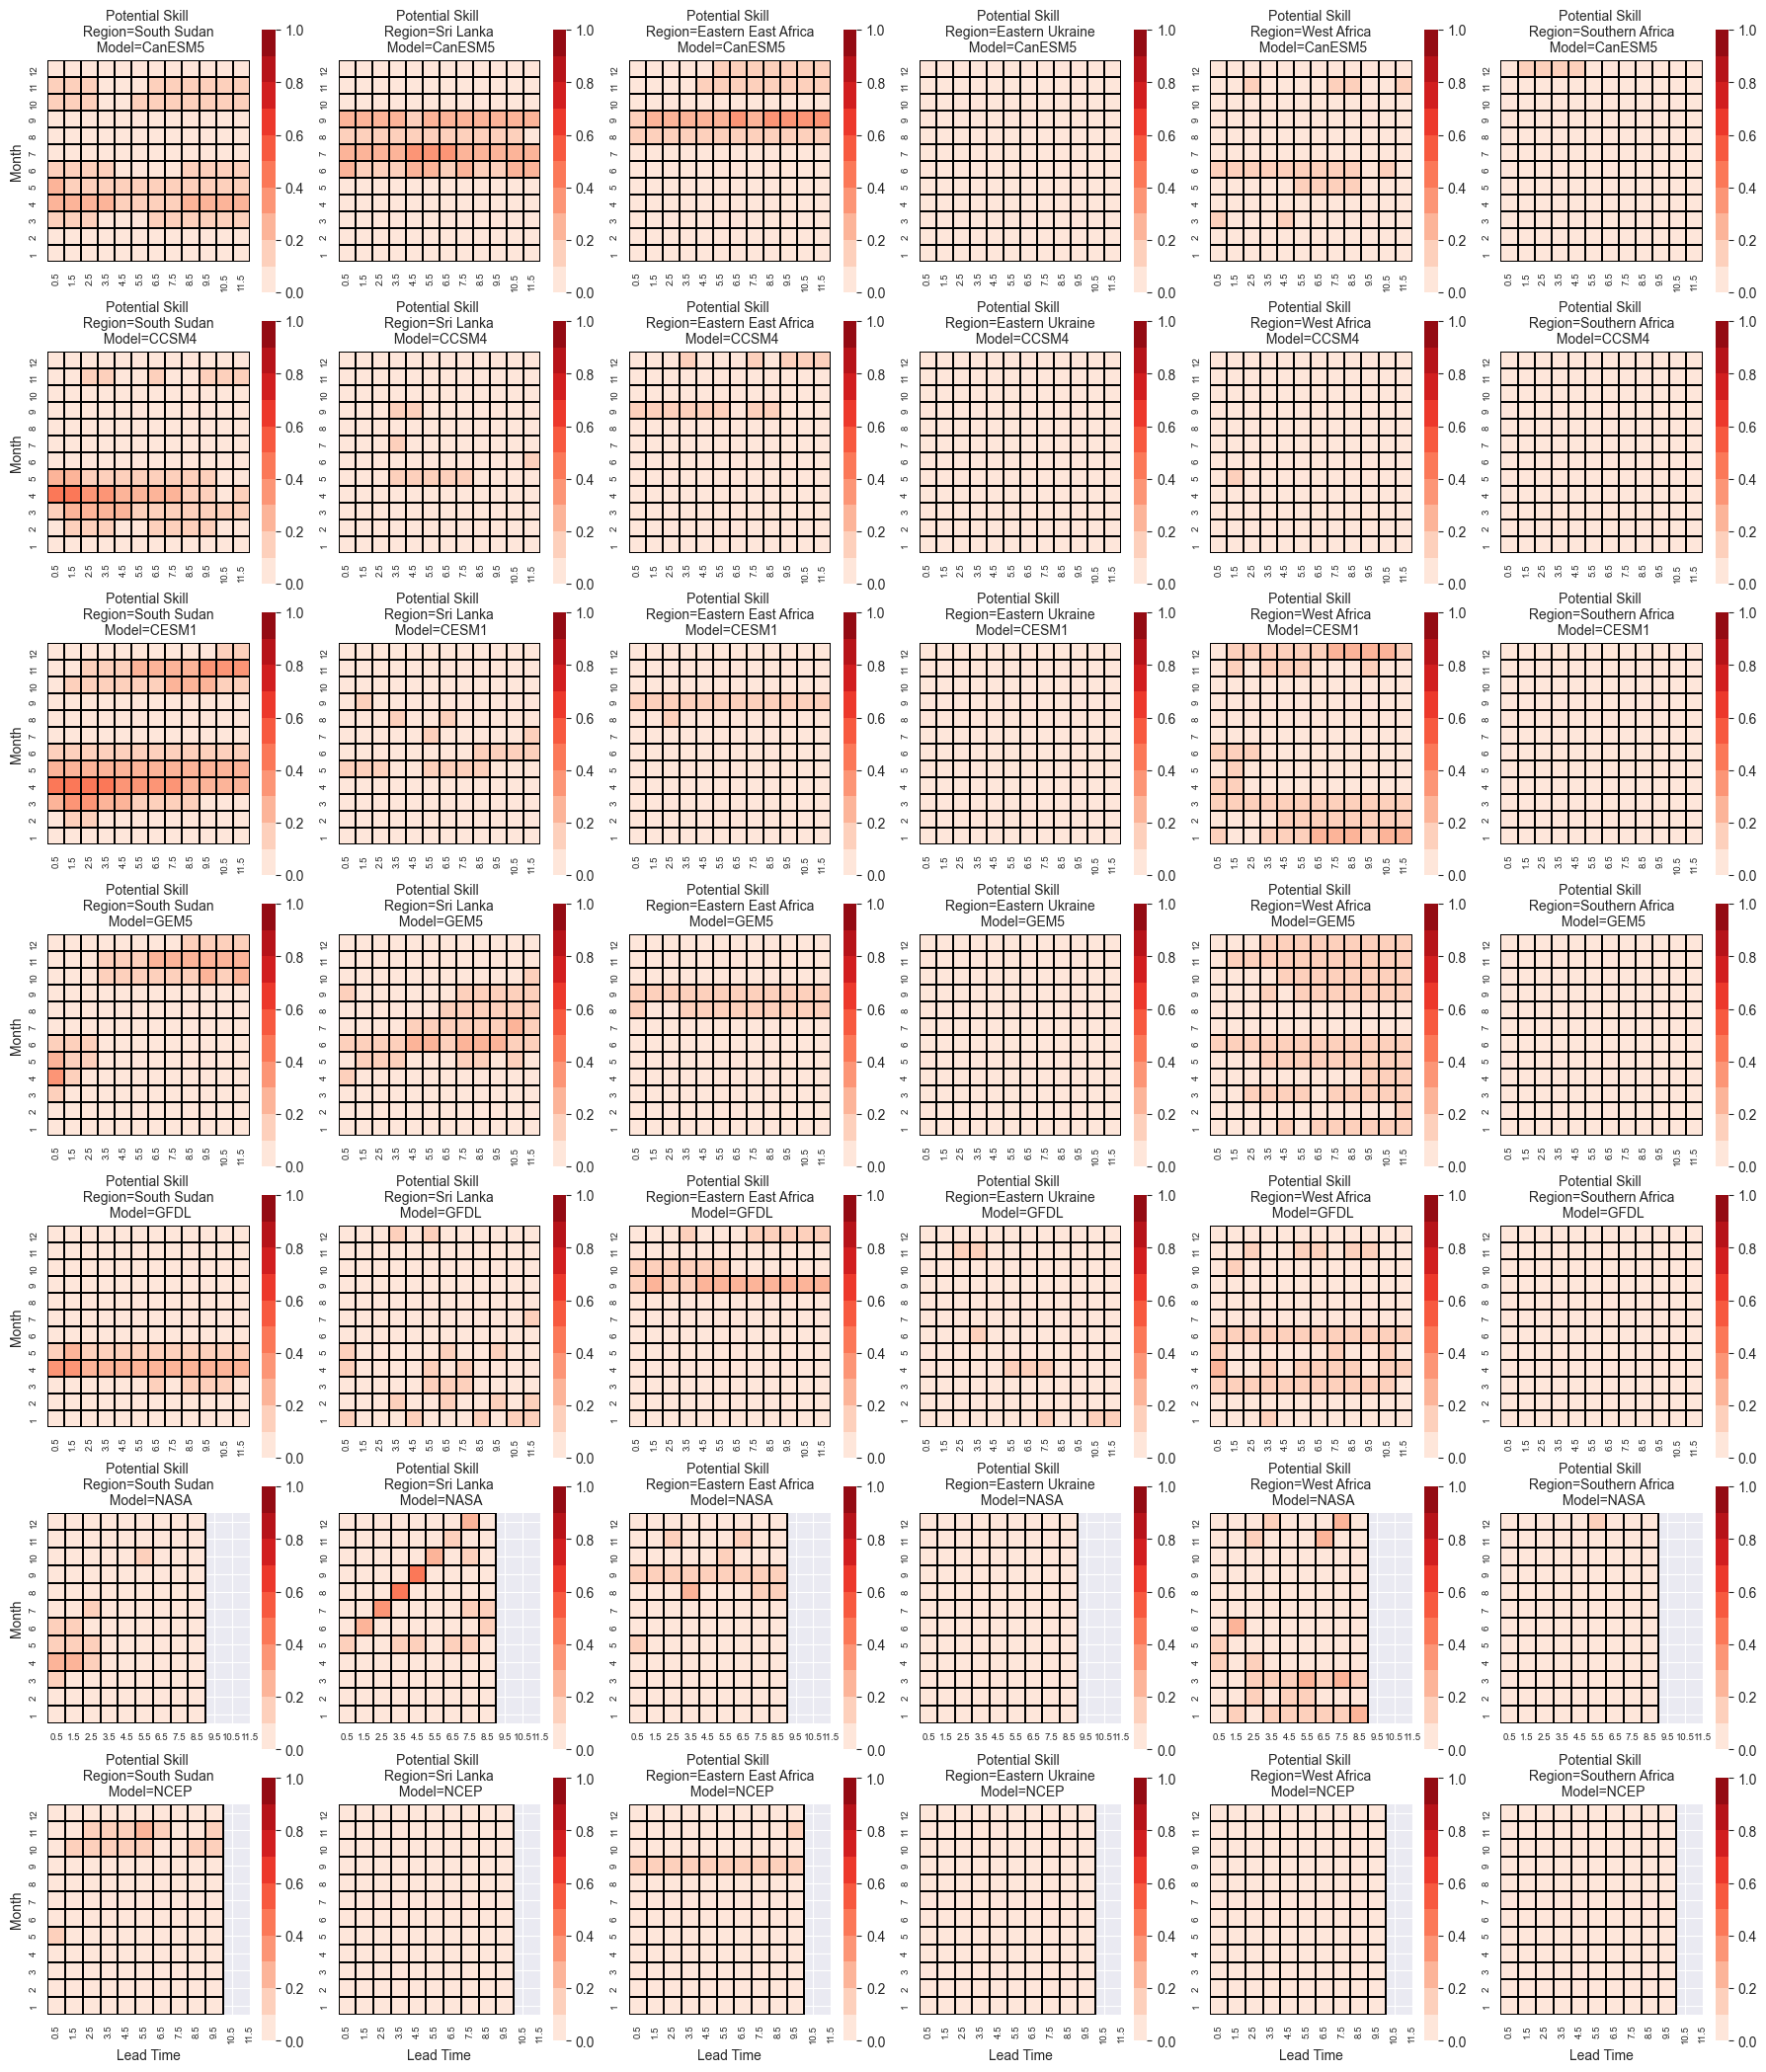

In [22]:
def draw_heatmap(*args, **kwargs):
    data = kwargs.pop('data')
    d = data.pivot(index=args[1], columns=args[0], values=args[2])
    sns.heatmap(d, **kwargs, vmin=0, vmax=1, 
                cmap=sns.color_palette('Reds', 10),
                linewidths=0.1, linecolor='black')
    plt.xticks(np.arange(0.5, 12.5, 1))  # Set xticks explicitly
    plt.gca().set_xticklabels(np.arange(0.5, 12.5, 1))  # Set xticklabels
    plt.xticks(fontsize=7)
    plt.yticks(fontsize=7)
    plt.gca().invert_yaxis()

fg = sns.FacetGrid(models_stat_final, col='region', row='model', sharex=False, sharey=False)
fg.map_dataframe(draw_heatmap, 'lead time', 'month', 'potential skill', square = True)

fg.set_titles('Potential Skill \n Region={col_name} \n Model={row_name}')
fg.set_ylabels("Month")
fg.set_xlabels("Lead Time")
plt.show()
fg.savefig('figures/potential_skill.png')

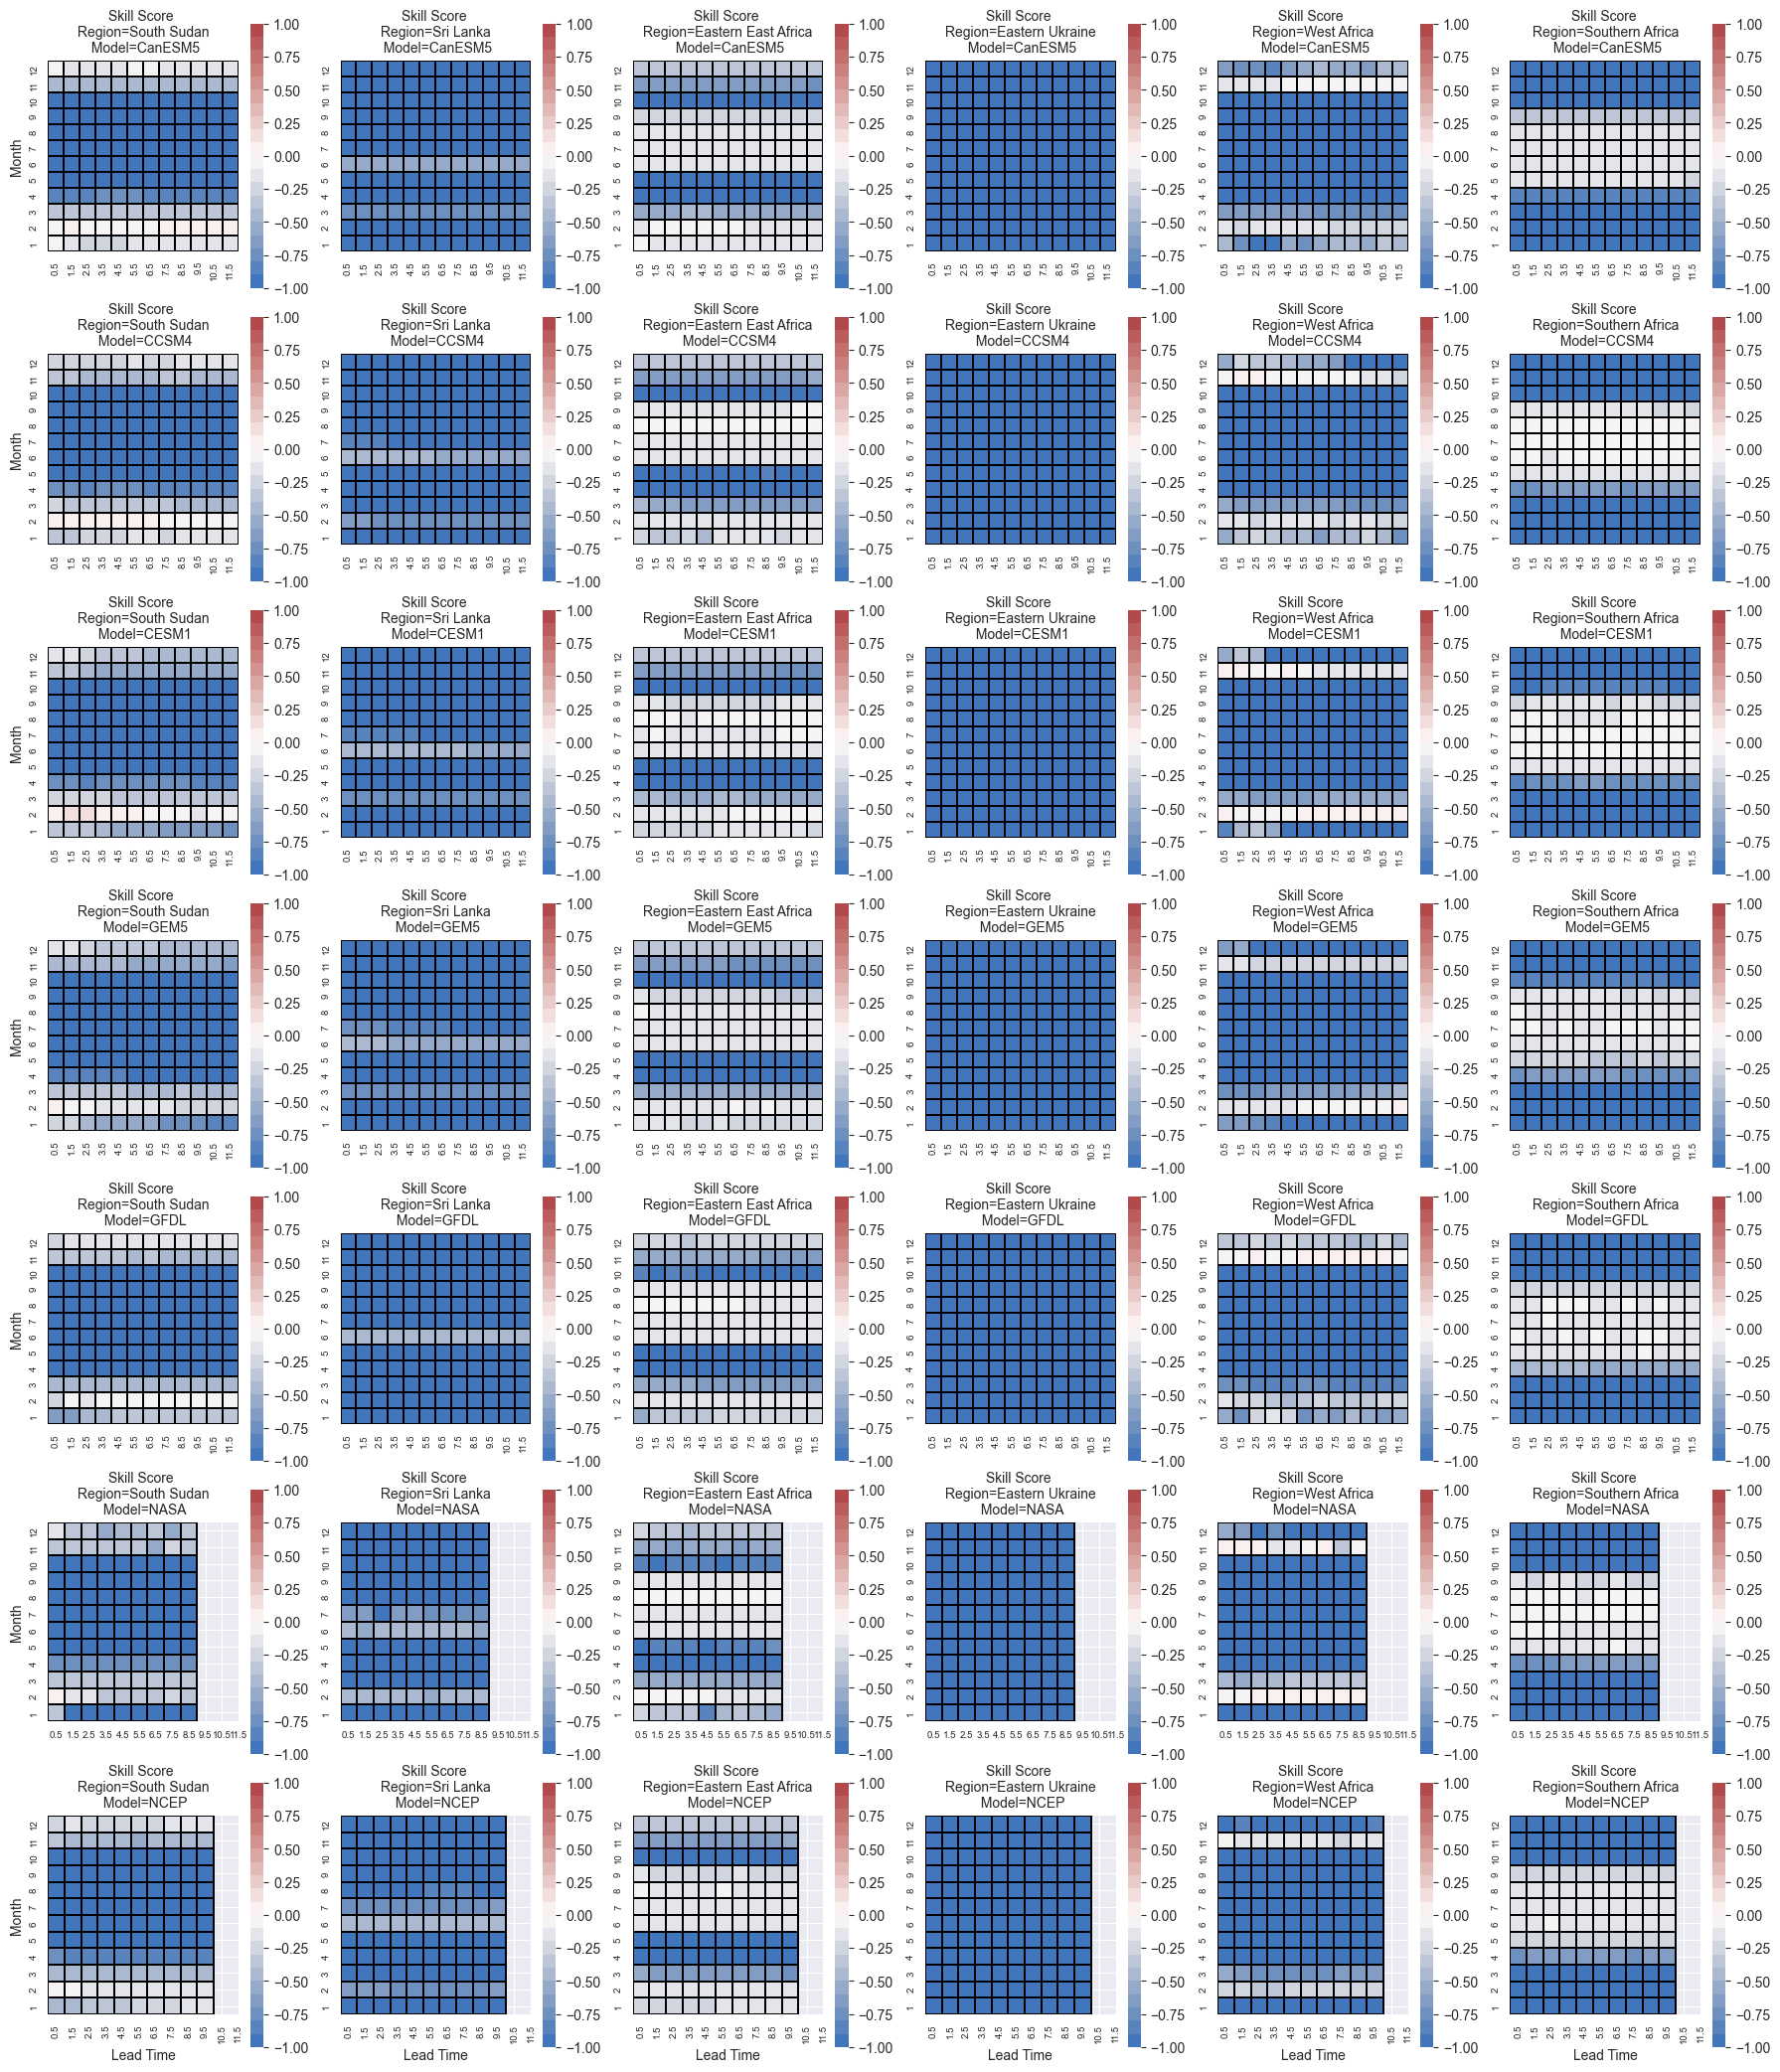

In [18]:
def draw_heatmap(*args, **kwargs):
    data = kwargs.pop('data')
    d = data.pivot(index=args[1], columns=args[0], values=args[2])
    sns.heatmap(d, **kwargs, vmin=-1, vmax=1, 
                cmap=sns.color_palette('vlag', 20),
                linewidths=0.1, linecolor='black')
    plt.xticks(np.arange(0.5, 12.5, 1))  # Set xticks explicitly
    plt.gca().set_xticklabels(np.arange(0.5, 12.5, 1))  # Set xticklabels
    plt.xticks(fontsize=7)
    plt.yticks(fontsize=7)
    plt.gca().invert_yaxis()

fg = sns.FacetGrid(models_stat_final, col='region', row='model',sharey=False, sharex=False)
fg.map_dataframe(draw_heatmap, 'lead time', 'month', 'skill score', square = True)

fg.set_titles('Skill Score \n Region={col_name} \n Model={row_name}')
fg.set_ylabels("Month")
fg.set_xlabels("Lead Time")
plt.show()
fg.savefig('figures/skill_score.png')

In [ ]:
def draw_heatmap(*args, **kwargs):
    data = kwargs.pop('data')
    d = data.pivot(index=args[1], columns=args[0], values=args[2])
    sns.heatmap(d, **kwargs, vmin=0, vmax=5, 
                cmap=sns.color_palette('Blues', 10),
                linewidths=0.1, linecolor='black')
    plt.xticks(np.arange(0.5, 12.5, 1))  # Set xticks explicitly
    plt.gca().set_xticklabels(np.arange(0.5, 12.5, 1))  # Set xticklabels
    plt.xticks(fontsize=7)
    plt.yticks(fontsize=7)
    plt.gca().invert_yaxis()

fg = sns.FacetGrid(models_stat_final, col='region', row='model', sharey=False, sharex=False)
fg.map_dataframe(draw_heatmap, 'lead time', 'month', 'unconditional bias', square = True)

fg.set_titles('Unconditional Bias \n Region={col_name} \n Model={row_name}')
fg.set_ylabels("Month")
fg.set_xlabels("Lead Time")
plt.show()
fg.savefig('figures/unconditional_bias.png')

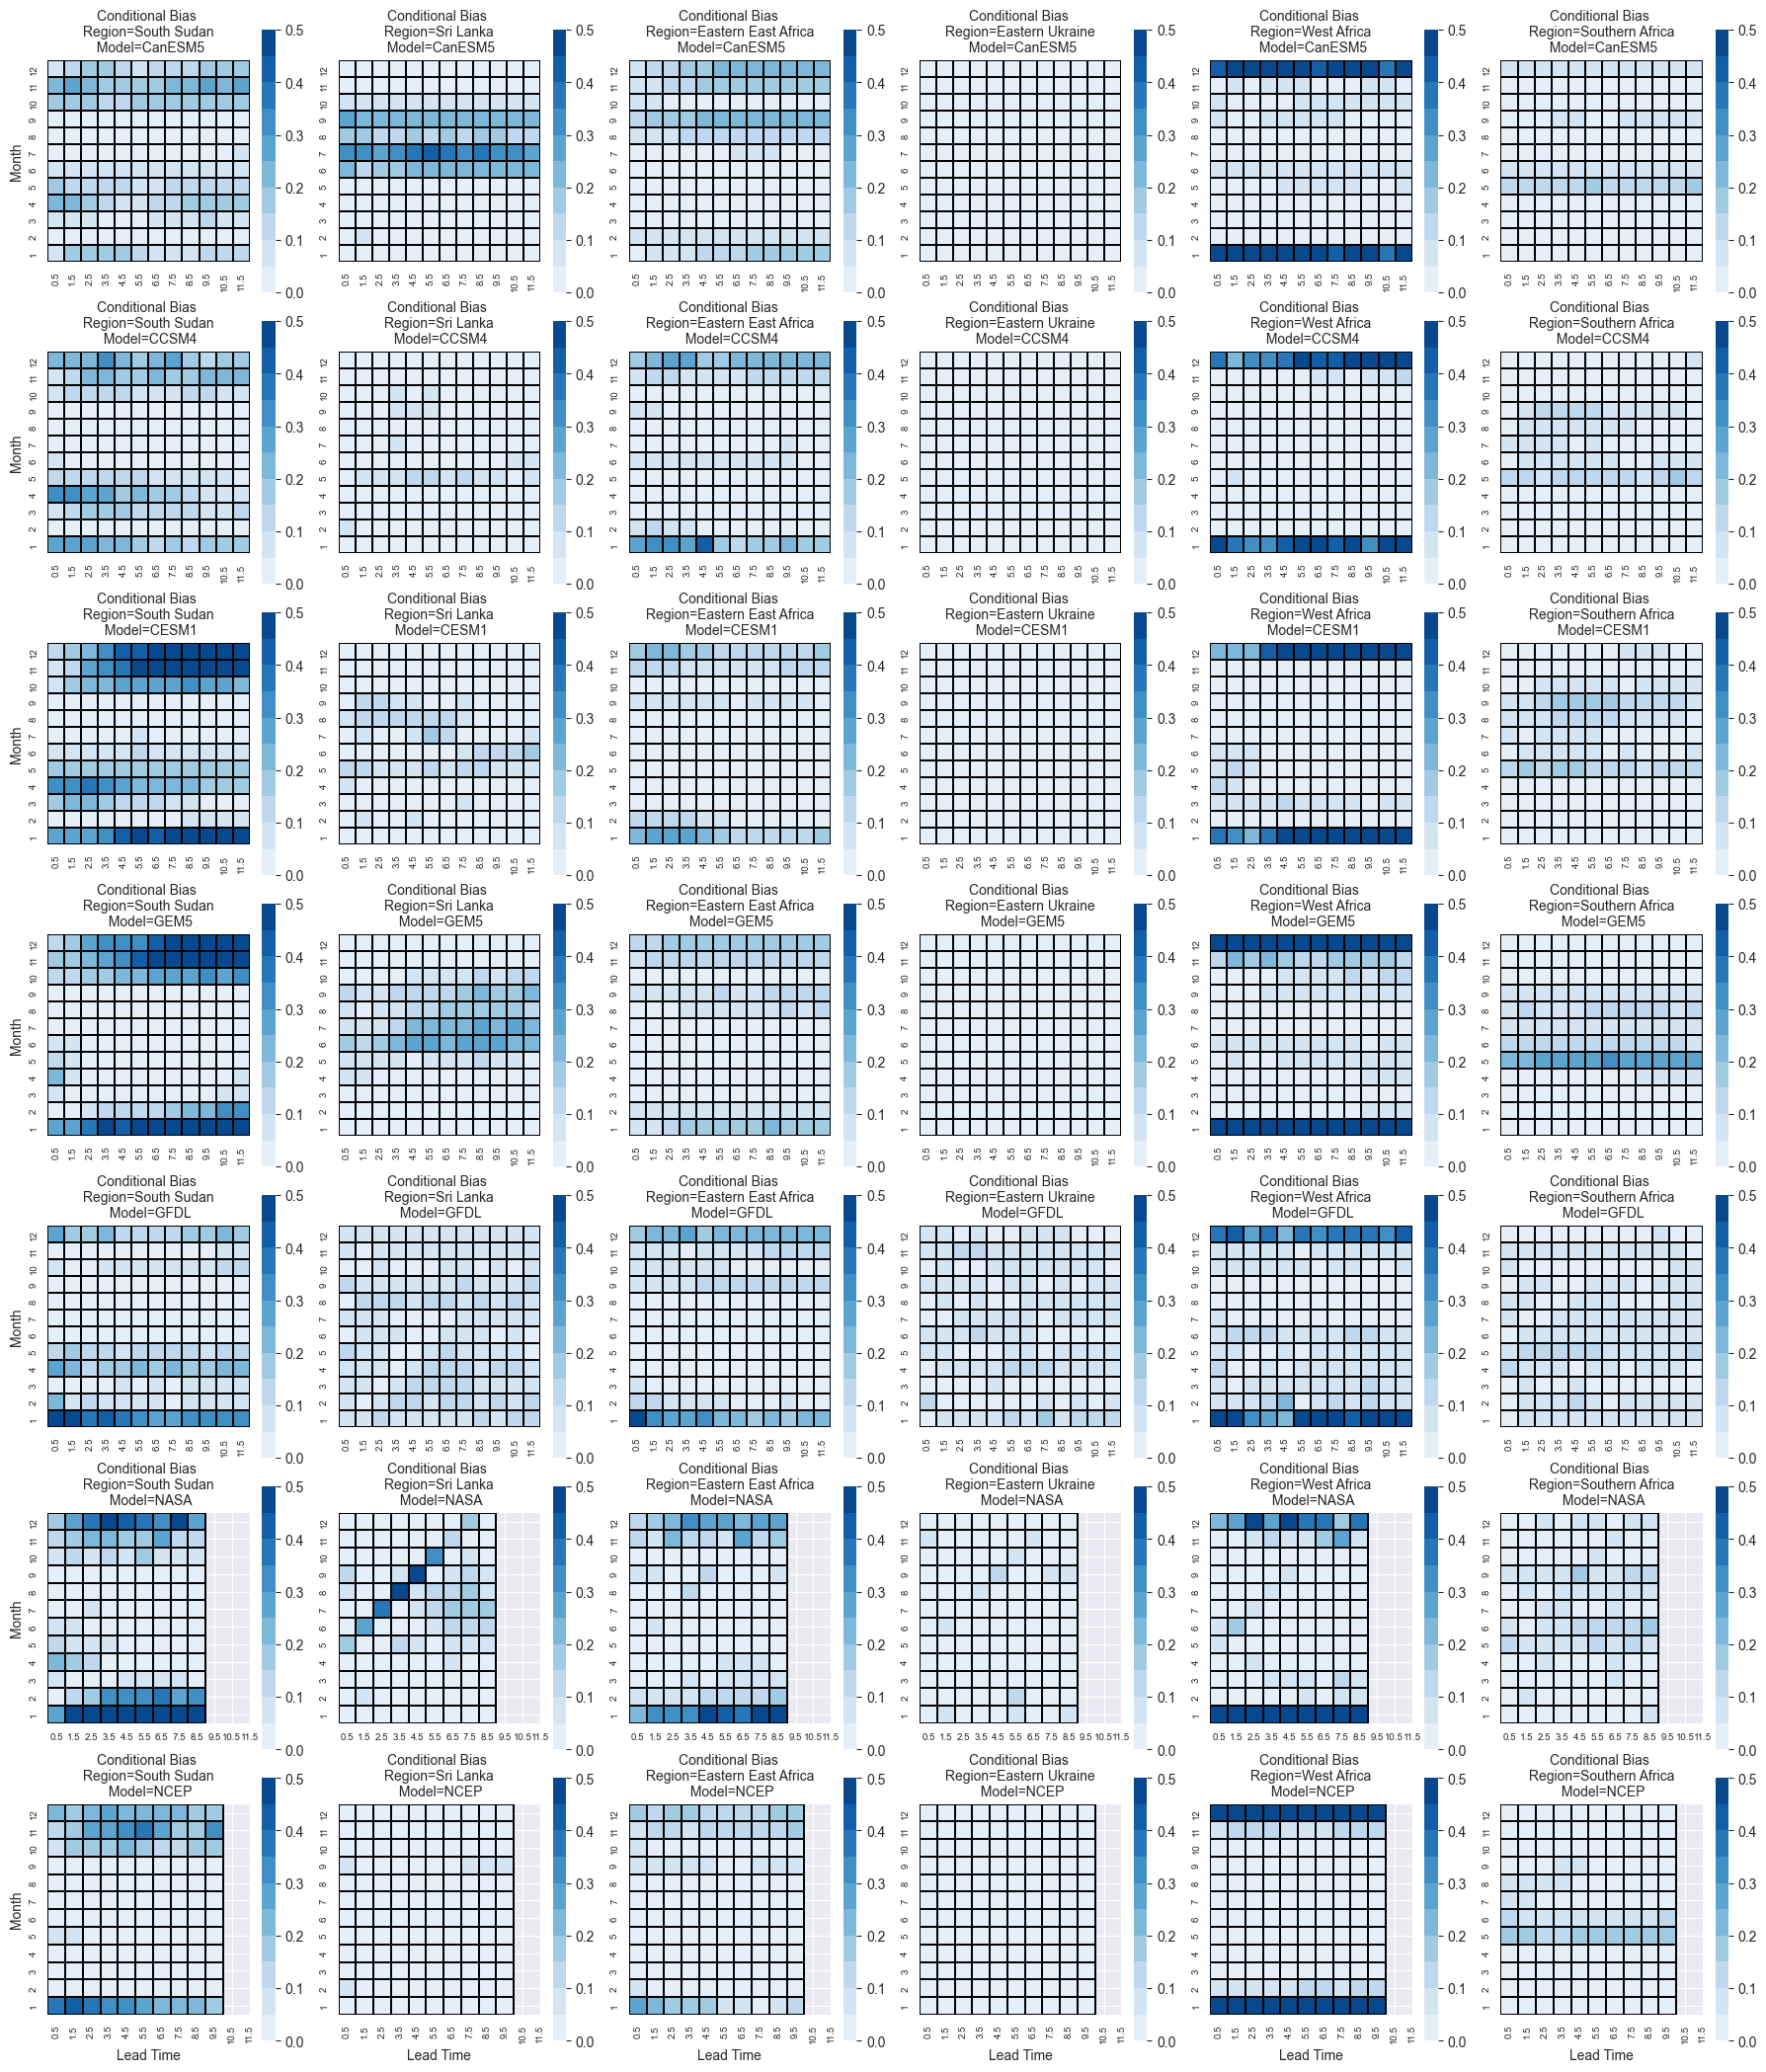

In [21]:
def draw_heatmap(*args, **kwargs):
    data = kwargs.pop('data')
    d = data.pivot(index=args[1], columns=args[0], values=args[2])
    sns.heatmap(d, **kwargs, vmin=0, vmax=0.5, 
                cmap=sns.color_palette('Blues', 10),
                linewidths=0.1, linecolor='black')
    plt.xticks(np.arange(0.5, 12.5, 1))  # Set xticks explicitly
    plt.gca().set_xticklabels(np.arange(0.5, 12.5, 1))  # Set xticklabels
    plt.xticks(fontsize=7)
    plt.yticks(fontsize=7)
    plt.gca().invert_yaxis()

fg = sns.FacetGrid(models_stat_final, col='region', row='model', sharex=False, sharey=False)
fg.map_dataframe(draw_heatmap, 'lead time', 'month', 'conditional bias', square = True)

fg.set_titles('Conditional Bias \n Region={col_name} \n Model={row_name}')
fg.set_ylabels("Month")
fg.set_xlabels("Lead Time")
plt.show()
fg.savefig('figures/conditional_bias.png')